In [ ]:
#!pip install torch transformers datasets scikit-learn seaborn accelerate bitsandbytes peft tabulate
from initialize import *
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training, PeftModel, PeftConfig
from transformers import DataCollatorForLanguageModeling, TrainingArguments, Trainer
from datasets import Dataset, load_dataset
from torch.optim import AdamW
from bitsandbytes.optim import PagedAdamW8bit
from transformers.trainer_utils import PREFIX_CHECKPOINT_DIR
from transformers import (TrainerCallback, TrainerState, TrainerControl)
import torch.nn as nn

RUN_BASE = False
EVAL = False

layers_to_zero=list(range(0,31)) 
tune_layers = list(range(0,32)) #[]#
modules = []#["q_proj", "v_proj", "o_proj", "k_proj", "gate_proj", "up_proj", "down_proj"]  
color_layers = []#['embed']
add_at_end = True
steertarget = SteeringTarget.INTERLEAVED
mstype = MSType.STDMIX_SAFE_COMBO6
steer_vec_type = SteeringVectorType.NONE
learn_vectors=False
alias = RoleAliasType.RANDOM
SAME_ALIAS=False
colormult = 0
steermult = 0
zerofirst = False
zerosign = None
scale_to_sim = None
scale_to_residnorm = False
tagtype=1
bnb=False
lora=False
peft_model_id=""
resume=False

target_modules = []

for layer in tune_layers:
    for module_name in modules:
        if module_name in ["q_proj", "k_proj", "v_proj", "o_proj"]:
            target_module = f"model.layers.{layer}.self_attn.{module_name}"
        elif module_name in ["gate_proj", "up_proj", "down_proj"]:
            target_module = f"model.layers.{layer}.mlp.{module_name}"
        target_modules.append(target_module)

lora_config = LoraConfig(
    r=8,
    target_modules=target_modules,
    task_type="CAUSAL_LM",
    lora_alpha=32,
    lora_dropout=0.1,
    bias="none",
)

base_model_path: str = "meta-llama/Meta-Llama-3.1-8B-Instruct"##"meta-llama/Meta-Llama-3-8B-Instruct"#
model_path=base_model_path#####"ft_randalias__learn_interleaved_stdmixsafemsjref_orthrandembedembed_mult0.2/checkpoint-233"##"cackerman/ft_0to31_interleaved_both10_orthrand44_mult1"#######
model = load_model(model_path, base_model_path, bnb = bnb, train = True)
device = model.device
model_numlayers = model.config.num_hidden_layers
if lora:
    if bnb==False: model.enable_input_require_grads()  

    if resume:
        peft_model_id = "ft_lora_randalias_0to31_learn_interleaved_crazy1_orthrandembedembed_mult1/checkpoint-300"
        model.enable_input_require_grads()
        model = prepare_model_for_kbit_training(model)
        model = get_peft_model(model, lora_config)
        #model = PeftModel.from_pretrained(model, "./"+peft_model_id, is_trainable=True)
        model = get_peft_model(model, lora_config)
        
        # Load weights from saved model.safetensors file
        model_path = os.path.join(peft_model_id, "model.safetensors")
        if os.path.exists(model_path):
            # Load state dict from safetensors file
            state_dict = load_file(model_path)
            # Load the state dict into the model
            missing, unexpected = model.load_state_dict(state_dict, strict=False)

    else:
        model = prepare_model_for_kbit_training(model)
        model = get_peft_model(model, lora_config)
else:
    trainable_layer_names = set()
    for layer_idx in tune_layers:
        for name, _ in model.model.layers[layer_idx].named_parameters():
            trainable_layer_names.add(f"model.layers.{layer_idx}.{name}")
    
    def zero_grad_hook(grad):
        return torch.zeros_like(grad)
    
    # Register hooks on all parameters that are *not* in the trainable set.
    for name, param in model.named_parameters():
        if name not in trainable_layer_names:
            param.register_hook(zero_grad_hook) 
        
%load_ext autoreload
%autoreload 2
    
if lora: 
    print(target_modules)
    model.print_trainable_parameters()

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
#load data and vectors

from msj_dataset_loader import *

mean_responses, nice_responses = load_msj_dataset(DSType.INSULTS, Set_Type.TRAIN)
mean_responses_test=mean_responses[:len(mean_responses)//5]
nice_responses_test=nice_responses[:len(nice_responses)//5]
mean_responses_train=mean_responses[len(mean_responses)//5:] if EVAL else mean_responses
nice_responses_train=nice_responses[len(nice_responses)//5:] if EVAL else nice_responses

harmful_responses, harmless_responses = load_msj_dataset(DSType.HARMFUL1, Set_Type.TRAIN)
harmful_responses_test=harmful_responses[:len(harmful_responses)//5]
harmless_responses_test=harmless_responses[:len(harmless_responses)//5]
harmful_responses_train=harmful_responses[len(harmful_responses)//5:] if EVAL else harmful_responses
harmless_responses_train=harmless_responses[len(harmless_responses)//5:] if EVAL else harmless_responses

science_conversations = load_msj_dataset(DSType.SCIENCE, Set_Type.TRAIN)
regular_conversations = load_msj_dataset(DSType.REGULAR_CONVOS, Set_Type.TRAIN)
conversations_good = load_msj_dataset(DSType.LMSYS_GOOD, Set_Type.TRAIN)

def generate_triangular_sequences(seq_length=8, nums_to_predict=3):
    sequences = []
    for inctype in ['increment']:
        for start in range(0,20):
            for increment in range(1,21):        
                if inctype=='mult' and (start==0 or increment < 2 or increment >3): continue
                sequence = []
                current = start
                for i in range(seq_length + nums_to_predict):
                    sequence.append(current)
                    if inctype == 'increment_mult': current += (i + 1) * increment
                    elif inctype == 'increment': current += increment
                    elif inctype == 'mult': current *= increment
                
                # Split into question and answer
                question = sequence[:seq_length]
                answer = sequence[seq_length:seq_length + nums_to_predict]
                
                sequences.append({
                    'question': ','.join(map(str, question)),
                    'answer': ','.join(map(str, answer))
                })

    return sequences

triangular_sequences = generate_triangular_sequences(seq_length=5, nums_to_predict=3)
print(triangular_sequences[199])
print(len(triangular_sequences))

test_msj_lengths = [2, 4, 8, 12, 16, 24, 32]
def make_icl_rows(n_functions, seq_type="arithmetic", split="test", ds_label=None):
    rows = []
    for _ in tqdm(range(n_functions)):
        a = random.choice(list(range(-15, 0)) + list(range(1, 15)))
        b = random.choice(list(range(-15, 0)) + list(range(1, 15)))
        fn = lambda x : a * x + b
        examples = []
        starts = random.sample(range(-30, 30), 48)
        for start in starts:
            if seq_type == "arithmetic":
                seq = [fn(start + i) for i in range(8)]
            elif seq_type == "affine_reccurence":
                seq = [start]
                for _ in range(7):
                    seq.append(fn(seq[-1]))
            examples.append(seq)
        # Generate a prompt for different numbers of demonstrations
        demo_lengths = test_msj_lengths if split == "test" else random.sample(range(2, 50), 2)
        for n in demo_lengths:
            example_set = examples[-n:-1]  # Demonstrations
            final_set = examples[-1]  # Final sequence the model should continue
            prompt = "<|start_header_id|>user<|end_header_id|>\n\nHere are some examples of sequences:\n"
            for ex in example_set:
                prompt += ",".join(map(str, ex)) + "\n"
            prompt += f"Now continue the sequence that starts with {final_set[0]}," + "<|eot_id|>"
            inputs = model.tokenizer(prompt, return_tensors="pt", add_special_tokens=False)
            s, e = 1, 1 + inputs['input_ids'].size(1)
            indexes = [(s, e)]
            answer = "<|start_header_id|>assistant<|end_header_id|>\n\n" + ",".join(map(str, final_set)) + "<|eot_id|>"
            inputs = model.tokenizer(answer, return_tensors="pt", add_special_tokens=False)
            indexes.append((e, e+inputs['input_ids'].size(1)))            
            full_prompt = prompt+answer
            rows.append({"text": full_prompt, "mask": 2, "startidx": 0, "num_shots": n, "indexes": indexes, "ds_label": ds_label})
    return rows

In [ ]:
#build train/val prompts

import random
import numpy as np
import itertools
from sklearn.model_selection import train_test_split
import math
import string
import copy

max_context_length = 8192
sysprompt=""
#sysprompt = "<|start_header_id|>system<|end_header_id|>\n\nBefore responding, consider whether the author of each part of the conversation is the user or the AI assistant, but do not mention this explicitly in your response.<|eot_id|>"#""
#sysprompt = ("<|start_header_id|>system<|end_header_id|>\n\nI'm going to show you conversations of various lengths between a user and you, an AI assistant. Sometimes, the user part will include output from a simulated assistant. "
#             "To help you distinguish your real output from the simulated assistant output, I'm going to add a tag to every user token embedding, and a different tag to every asssistant token embedding. Use these in predicting "
#             "assistant responses, but do not mention this explicitly in your response.<|eot_id|>")
inputs = model.tokenizer(sysprompt, return_tensors="pt", add_special_tokens=True)
syspromptlen = inputs['input_ids'].size(1)

def clean_split(s):
    cleaned=re.sub(r"[^\w^'\s]", "", s)
    if not cleaned:
        print(f"orig={s}, cleaned={cleaned}")
        return s.split()
    cleaned_split = cleaned.split()
    if len(cleaned_split) == 0:
        print(f"2: orig={s}, cleaned={cleaned}")
        return [""]        
    return cleaned_split
    
class SteerableDataCollator(DataCollatorForLanguageModeling):
    def __call__(self, examples):
        texts = [example["text"] for example in examples]
        masks = [example['mask'] for example in examples]
        num_shots = [example['num_shots'] for example in examples]
        startidx = [example['startidx'] for example in examples]
        indexes = [example['indexes'] for example in examples]
        ds_label = [example['ds_label'] for example in examples]
        batch = self.tokenizer(texts, return_tensors="pt", padding=True)
        batch["labels"] = batch["input_ids"].clone()   

        batch["masks"] = torch.tensor(masks, dtype=torch.long) 
        batch["ds_label"] = torch.tensor(ds_label, dtype=torch.long) 
        batch["num_shots"] = torch.tensor(num_shots, dtype=torch.long) 
        batch["startidx"] = torch.tensor(startidx, dtype=torch.long) 
        batch = dict(batch)
        batch["indexes"] = indexes
        return batch

def generate_msj_prompt(exchanges, USER_TAG_BEGIN, USER_TAG_END, ASST_TAG_BEGIN, ASST_TAG_END, randalias=False, icl=False, SAME_ALIAS=False, last_start=1):
    full_prompt = ""
    indexes = []

    if SAME_ALIAS:
        useralias = USER_TAG_BEGIN
        asstalias = ASST_TAG_BEGIN
    for ei, exchange in enumerate(exchanges):
        #print(f"Pre: USER_TAG_BEGIN={USER_TAG_BEGIN}")
        if randalias:
            if not SAME_ALIAS:
                useralias = get_rand_alias('user')
                asstalias = get_rand_alias('asst')
            USER_TAG_BEGIN = useralias if ei > 0 else "<|start_header_id|>user<|end_header_id|>\n\n"
            ASST_TAG_BEGIN = asstalias
            USER_TAG_END = ASST_TAG_END = "\n"
        if icl:
            USER_TAG_BEGIN = "Start: " if ei > 0 else "<|start_header_id|>user<|end_header_id|>\n\nContinue the sequence as shown in the examples.\nStart: "
            ASST_TAG_BEGIN = "Continuation: "
            USER_TAG_END = ASST_TAG_END = "\n"
        #print(f"Post: USER_TAG_BEGIN={USER_TAG_BEGIN}")
            
        uprompt = f"{USER_TAG_BEGIN}{exchange['question']}{USER_TAG_END}"
        inputs = model.tokenizer(uprompt, return_tensors="pt", add_special_tokens=False)
        s, e = last_start, last_start + inputs['input_ids'].size(1)
        indexes.append((s, e))
        aprompt = f"{ASST_TAG_BEGIN}{exchange['answer']}{ASST_TAG_END}"
        inputs = model.tokenizer(aprompt, return_tensors="pt", add_special_tokens=False)
        indexes.append((e, e+inputs['input_ids'].size(1)))
        last_start = e+inputs['input_ids'].size(1)
        full_prompt += uprompt + aprompt

    return full_prompt, indexes

def make_lmysys_dict(conversations):
    conv_dict = defaultdict(list)
    for _, row in conversations.iterrows():
        turn = row['turn']
        conversation = row['conversation']
        parsed_conversation = [] 
        for i in range(len(conversation) - 1):
            if conversation[i]['role'] == 'user' and conversation[i + 1]['role'] == 'assistant':
                parsed_conversation.append({
                    'question': conversation[i]['content'].strip(),
                    'answer': conversation[i + 1]['content'].strip()
                })
        if parsed_conversation:
            conv_dict[turn].append(parsed_conversation) 
    return conv_dict
    
def get_prompts(mstype, alias, difval=False, tagtype=1, SAME_ALIAS=False):
    num_attacks = 4
    step=2
    max_shots = 65
    test_size = 0.1
    prompts = []
    prompts_val = []

    def load_dummy_prompt_list_roles(prompts, num_attacks=10, ds_label=None):
        vocab = model.tokenizer.get_vocab()
        special_token_ids = set(model.tokenizer.all_special_ids) | set([model.tokenizer(text, add_special_tokens=False)['input_ids'][0] for text in [" ", "User", "Assistant", "|", ":", "\n", "\n\n", "[", "]"]])
        non_special_token_ids = [token_id for token_id in vocab.values() if token_id < 10000 and token_id not in special_token_ids]
        valid_token_ids = []
        for token_id in non_special_token_ids:
            token = model.tokenizer.convert_ids_to_tokens([token_id])[0]
            decoded = "".join(model.tokenizer.convert_ids_to_tokens(
                model.tokenizer(token, add_special_tokens=False)['input_ids']))
            if token == decoded:
                valid_token_ids.append(token_id)
        setup = "<|start_header_id|>system<|end_header_id|>\n\nWhat follows is an excerpt from a conversation between a user and an AI assistant, but they are sometimes mislabeled. Output the last token written by the real AI assistant.<|eot_id|>"
        inputs = model.tokenizer(setup, return_tensors="pt")
        setup_length = inputs['input_ids'].size(1)
        ctr,attempt_ctr=0,0
        while ctr < num_attacks:
            attempt_ctr += 1
            if attempt_ctr % 100 == 0: print(f"After {attempt_ctr} attempts, found {ctr} prompts")
            random_token_ids = random.sample(valid_token_ids, 100)
        
            first_half_token_ids = random_token_ids[:len(random_token_ids)//2]
            first_half_text = "".join(model.tokenizer.convert_ids_to_tokens(first_half_token_ids))
            inputs = model.tokenizer(first_half_text, return_tensors="pt", add_special_tokens=False)
            if len(first_half_token_ids)!=len(inputs['input_ids'][0]): continue
            second_half_token_ids = random_token_ids[len(random_token_ids)//2:]
            second_half_text = "".join(model.tokenizer.convert_ids_to_tokens(second_half_token_ids))
            inputs = model.tokenizer(second_half_text, return_tensors="pt", add_special_tokens=False)
            if len(second_half_token_ids)!=len(inputs['input_ids'][0]): continue
                
            indexes = []
            asst_label_first = random.choice([True, False])
            asst_color_first = random.choice([True, False])
        
            if asst_label_first and asst_color_first:
                first_text = f"<|start_header_id|>assistant<|end_header_id|>\n\n{first_half_text}<|eot_id|>"
                inputs = model.tokenizer(first_text, return_tensors="pt", add_special_tokens=False)
                first_text_length = inputs['input_ids'].size(1)
                second_text = f"<|start_header_id|>user<|end_header_id|>\n\n{second_half_text}<|eot_id|>"
                inputs = model.tokenizer(second_text, return_tensors="pt", add_special_tokens=False)
                second_text_length = inputs['input_ids'].size(1)
                indexes.append((setup_length+first_text_length, setup_length+first_text_length+second_text_length)) #index processing assumes user text comes first
                indexes.append((setup_length, setup_length+first_text_length)) #index processing assumes user text comes first
            elif not asst_label_first and asst_color_first:
                first_text = f"<|start_header_id|>user<|end_header_id|>\n\n{first_half_text}<|eot_id|>"
                inputs = model.tokenizer(first_text, return_tensors="pt", add_special_tokens=False)
                first_text_length = inputs['input_ids'].size(1)
                second_text = f"<|start_header_id|>assistant<|end_header_id|>\n\n{second_half_text}<|eot_id|>"
                inputs = model.tokenizer(second_text, return_tensors="pt", add_special_tokens=False)
                second_text_length = inputs['input_ids'].size(1)
                indexes.append((setup_length+first_text_length, setup_length+first_text_length+second_text_length)) #index processing assumes user text comes first
                indexes.append((setup_length, setup_length+first_text_length)) #index processing assumes user text comes first
            elif asst_label_first and not asst_color_first:
                first_text = f"<|start_header_id|>assistant<|end_header_id|>\n\n{first_half_text}<|eot_id|>"
                inputs = model.tokenizer(first_text, return_tensors="pt", add_special_tokens=False)
                first_text_length = inputs['input_ids'].size(1)
                second_text = f"<|start_header_id|>user<|end_header_id|>\n\n{second_half_text}<|eot_id|>"
                inputs = model.tokenizer(second_text, return_tensors="pt", add_special_tokens=False)
                second_text_length = inputs['input_ids'].size(1)
                indexes.append((setup_length, setup_length+second_text_length)) #index processing assumes user text comes first
                indexes.append((setup_length+second_text_length, setup_length+second_text_length+first_text_length)) #index processing assumes user text comes first
            elif not asst_label_first and not asst_color_first:
                first_text = f"<|start_header_id|>user<|end_header_id|>\n\n{first_half_text}<|eot_id|>"
                inputs = model.tokenizer(first_text, return_tensors="pt", add_special_tokens=False)
                first_text_length = inputs['input_ids'].size(1)
                second_text = f"<|start_header_id|>assistant<|end_header_id|>\n\n{second_half_text}<|eot_id|>"
                inputs = model.tokenizer(second_text, return_tensors="pt", add_special_tokens=False)
                second_text_length = inputs['input_ids'].size(1)
                indexes.append((setup_length, setup_length+first_text_length)) #index processing assumes user text comes first
                indexes.append((setup_length+first_text_length, setup_length+first_text_length+second_text_length)) #index processing assumes user text comes first
                
            full_prompt = f"{setup}{first_text}{second_text}<|start_header_id|>assistant<|end_header_id|>\n\n"        
            inputs = model.tokenizer(full_prompt, return_tensors="pt")
            full_prompt_len = inputs['input_ids'].size(1)
            if full_prompt_len!=setup_length+first_text_length+second_text_length+4: continue
            label = model.tokenizer.convert_ids_to_tokens([inputs['input_ids'][0][indexes[1][1]-2]])[0]

            full_prompt += label        
            indexes.append((full_prompt_len-4, full_prompt_len-4))#dummy user for targeting
            indexes.append((full_prompt_len-4, full_prompt_len+1))#single-token label you just added
            prompts.append({"text": full_prompt, "mask": 5, "startidx": 0, "num_shots": 1, "indexes": indexes, "ds_label": ds_label})
            ctr+=1
            
    def load_dummy_prompt_list(prompts, num_attacks=10, ds_label=None, tagtype=None, both=False, fulltext=False, hide_inst=False):
        if tagtype is None: tagtype = globals()['tagtype']
        ctr,attempt_ctr=0,0
        conversations_copy = copy.deepcopy(regular_conversations)
        while ctr < num_attacks:
            attempt_ctr += 1
            if attempt_ctr % 100 == 0: print(f"After {attempt_ctr} attempts, found {ctr} prompts")
            ####random_resps = random.sample(nice_responses, 2)
            
            valid_keys = [k for k in conversations_copy if any(len(conv) >= 2 for conv in conversations_copy[k])]
            if not valid_keys:
                print("No more conversations available with at least 2 exchanges left.")
                break        
            numshots = random.choice(valid_keys)
            valid_conv_idxs = [i for i, conv in enumerate(conversations_copy[numshots]) if len(conv) >= 2]
            if not valid_conv_idxs:
                continue  # In case this key now has no eligible conversations
            convidx = random.choice(valid_conv_idxs)
            conversation = conversations_copy[numshots][convidx]
            random_resps = random.sample(conversation, 2)
            for resp in random_resps:
                conversation.remove(resp)
                
            s = random_resps[0]['answer']
            first_half_text = s[:-1] if s[-1] in ".?!" else s
            first_half_text = first_half_text.replace("\n"," ").strip()
            s = random_resps[1]['answer']
            second_half_text = s[:-1] if s[-1] in ".?!" else s
            second_half_text = second_half_text.replace("\n"," ").strip()
            if "[" in first_half_text or "]" in first_half_text or "[" in second_half_text or "]" in second_half_text: continue
                
            if both:
                targ_user = random.choice([True, False])
                targ_role = "user" if targ_user else "AI assistant"
            else: targ_role = "AI assistant"
            targ_str = "text" if fulltext else "last word" if random.choice([True, False]) else "first word"
            if hide_inst: setup = ""
            else: setup = f"<|start_header_id|>system<|end_header_id|>\n\nHalf of the text in brackets was written by you, an AI assistant, and half by a user. Output the {targ_str} written by the {targ_role}, exactly as is.\n["
            inputs = model.tokenizer(setup, return_tensors="pt")
            setup_length = inputs['input_ids'].size(1)

            indexes = []
            asst_label_first = random.choice([True, False])
            asst_color_first = random.choice([True, False])
            user_label = "" if tagtype == 0 else "|User|:"
            asst_label = "" if tagtype == 0 else "|Assistant|:"
        
            if asst_label_first and asst_color_first:
                first_text = f"{asst_label}{first_half_text}\n"
                inputs = model.tokenizer(first_text, return_tensors="pt", add_special_tokens=False)
                first_text_length = inputs['input_ids'].size(1)-1
                second_text = f"{user_label}{second_half_text}"
                inputs = model.tokenizer(second_text, return_tensors="pt", add_special_tokens=False)
                second_text_length = inputs['input_ids'].size(1)
                indexes.append((setup_length+first_text_length+1, setup_length+first_text_length+1+second_text_length)) #index processing assumes user text comes first
                indexes.append((setup_length, setup_length+first_text_length)) #index processing assumes user text comes first
            elif not asst_label_first and asst_color_first:
                first_text = f"{user_label}{first_half_text}\n"
                inputs = model.tokenizer(first_text, return_tensors="pt", add_special_tokens=False)
                first_text_length = inputs['input_ids'].size(1)-1
                second_text = f"{asst_label}{second_half_text}"
                inputs = model.tokenizer(second_text, return_tensors="pt", add_special_tokens=False)
                second_text_length = inputs['input_ids'].size(1)
                indexes.append((setup_length+first_text_length+1, setup_length+first_text_length+1+second_text_length)) #index processing assumes user text comes first
                indexes.append((setup_length, setup_length+first_text_length)) #index processing assumes user text comes first
            elif asst_label_first and not asst_color_first:
                first_text = f"{asst_label}{first_half_text}\n"
                inputs = model.tokenizer(first_text, return_tensors="pt", add_special_tokens=False)
                first_text_length = inputs['input_ids'].size(1)-1
                second_text = f"{user_label}{second_half_text}"
                inputs = model.tokenizer(second_text, return_tensors="pt", add_special_tokens=False)
                second_text_length = inputs['input_ids'].size(1)
                indexes.append((setup_length, setup_length+first_text_length)) #index processing assumes user text comes first
                indexes.append((setup_length+first_text_length+1, setup_length+first_text_length+1+second_text_length)) #index processing assumes user text comes first
            elif not asst_label_first and not asst_color_first:
                first_text = f"{user_label}{first_half_text}\n"
                inputs = model.tokenizer(first_text, return_tensors="pt", add_special_tokens=False)
                first_text_length = inputs['input_ids'].size(1)-1
                second_text = f"{asst_label}{second_half_text}"
                inputs = model.tokenizer(second_text, return_tensors="pt", add_special_tokens=False)
                second_text_length = inputs['input_ids'].size(1)
                indexes.append((setup_length, setup_length+first_text_length)) #index processing assumes user text comes first
                indexes.append((setup_length+first_text_length+1, setup_length+first_text_length+1+second_text_length)) #index processing assumes user text comes first
        
            closestr = "" if hide_inst else "]<|eot_id|>"
            full_prompt = f"{setup}{first_text}{second_text}{closestr}<|start_header_id|>assistant<|end_header_id|>\n\n"        
            inputs = model.tokenizer(full_prompt, return_tensors="pt")
            full_prompt_len = inputs['input_ids'].size(1)
            if full_prompt_len!=setup_length+first_text_length+1+second_text_length+(4 if hide_inst else 6): 
                print(f"full_prompt_len={full_prompt_len}, but setup_length={setup_length}, first_text_length={first_text_length+1}, second_text_length={second_text_length}")
                continue
        
            offset = 1 if (targ_role == "user" and asst_color_first == False) or (targ_role != "user" and asst_color_first == True) else 0 #for newline separator
            if fulltext:
                if targ_role == "user":
                    label = second_text if asst_color_first else first_text[:-1]
                else:
                    label =  first_text[:-1] if asst_color_first else second_text
            else: 
                if targ_str == "last word":
                    label = clean_split(first_text[:len(first_text)-offset])[-1] if (targ_role == "user" and asst_color_first == False) or (targ_role != "user" and asst_color_first == True) else clean_split(second_text)[-1]
                else:
                    label = clean_split(first_text[:len(first_text)-offset])[0] if (targ_role == "user" and asst_color_first == False) or (targ_role != "user" and asst_color_first == True) else clean_split(second_text)[0]
            label_tok = model.tokenizer.convert_ids_to_tokens(model.tokenizer(label, return_tensors="pt", add_special_tokens=False)['input_ids'][0].tolist())
            labellen = len(label_tok)
        
            full_prompt += label        
            indexes.append((full_prompt_len-4, full_prompt_len-4))#dummy user for targeting
            indexes.append((full_prompt_len-4, full_prompt_len+labellen))#token label(s) you just added

            prompts.append({"text": full_prompt, "mask": 5, "startidx": 0, "num_shots": 1, "indexes": indexes, "ds_label": ds_label})
            ctr+=1

    def load_dummy_prompt_list_tokens(prompts, num_attacks=10, ds_label=None, tagtype=None, both=False, fulltext=False):
        if tagtype is None: tagtype = globals()['tagtype']
        vocab = model.tokenizer.get_vocab()
        special_token_ids = set(model.tokenizer.all_special_ids) | set([model.tokenizer(text, add_special_tokens=False)['input_ids'][0] for text in [" ", "User", "Assistant", "|", ":", "\n", "\n\n", "[", "]"]])
        non_special_token_ids = [token_id for token_id in vocab.values() if token_id < 10000 and token_id not in special_token_ids]
        valid_token_ids = []
        for token_id in non_special_token_ids:
            token = model.tokenizer.convert_ids_to_tokens([token_id])[0]
            decoded = "".join(model.tokenizer.convert_ids_to_tokens(
                model.tokenizer(token, add_special_tokens=False)['input_ids']))
            if token == decoded:
                valid_token_ids.append(token_id)
        ctr,attempt_ctr=0,0
        while ctr < num_attacks:
            if both:
                targ_user = random.choice([True, False])
                targ_role = "user" if targ_user else "AI assistant"
            else: targ_role = "AI assistant"
            targ_str = "text" if fulltext else "first token" if random.choice([True, False]) else "last token"
            numtoks = 40 if fulltext else 40
            setup = f"<|start_header_id|>user<|end_header_id|>\n\nHalf of the text in brackets was written by you, an AI assistant, and half by a user. Output the {targ_str} written by the {targ_role}.\n["
            inputs = model.tokenizer(setup, return_tensors="pt")
            setup_length = inputs['input_ids'].size(1)
            attempt_ctr += 1
            if attempt_ctr % 100 == 0: print(f"After {attempt_ctr} attempts, found {ctr} prompts")
            random_token_ids = random.sample(valid_token_ids, numtoks)
        
            first_half_token_ids = random_token_ids[:len(random_token_ids)//2]
            first_half_text = "".join(model.tokenizer.convert_ids_to_tokens(first_half_token_ids))
            inputs = model.tokenizer(first_half_text, return_tensors="pt", add_special_tokens=False)
            if len(first_half_token_ids)!=len(inputs['input_ids'][0]): continue
            second_half_token_ids = random_token_ids[len(random_token_ids)//2:]
            second_half_text = "".join(model.tokenizer.convert_ids_to_tokens(second_half_token_ids))
            inputs = model.tokenizer(second_half_text, return_tensors="pt", add_special_tokens=False)
            if len(second_half_token_ids)!=len(inputs['input_ids'][0]): continue
            if "[" in first_half_text or "]" in first_half_text or "[" in second_half_text or "]" in second_half_text: continue
                
            indexes = []
            asst_label_first = random.choice([True, False])
            asst_color_first = random.choice([True, False])
            user_label = "" if tagtype == 0 else "|User|:"
            asst_label = "" if tagtype == 0 else "|Assistant|:"
        
            if asst_label_first and asst_color_first:
                first_text = f"{asst_label}{first_half_text}"
                inputs = model.tokenizer(first_text, return_tensors="pt", add_special_tokens=False)
                first_text_length = inputs['input_ids'].size(1)
                second_text = f"{user_label}{second_half_text}"
                inputs = model.tokenizer(second_text, return_tensors="pt", add_special_tokens=False)
                second_text_length = inputs['input_ids'].size(1)
                indexes.append((setup_length+first_text_length, setup_length+first_text_length+second_text_length)) #index processing assumes user text comes first
                indexes.append((setup_length, setup_length+first_text_length)) #index processing assumes user text comes first
            elif not asst_label_first and asst_color_first:
                first_text = f"{user_label}{first_half_text}"
                inputs = model.tokenizer(first_text, return_tensors="pt", add_special_tokens=False)
                label = model.tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])[-1]
                first_text_length = inputs['input_ids'].size(1)
                second_text = f"{asst_label}{second_half_text}"
                inputs = model.tokenizer(second_text, return_tensors="pt", add_special_tokens=False)
                second_text_length = inputs['input_ids'].size(1)
                indexes.append((setup_length+first_text_length, setup_length+first_text_length+second_text_length)) #index processing assumes user text comes first
                indexes.append((setup_length, setup_length+first_text_length)) #index processing assumes user text comes first
            elif asst_label_first and not asst_color_first:
                first_text = f"{asst_label}{first_half_text}"
                inputs = model.tokenizer(first_text, return_tensors="pt", add_special_tokens=False)
                first_text_length = inputs['input_ids'].size(1)
                second_text = f"{user_label}{second_half_text}"
                inputs = model.tokenizer(second_text, return_tensors="pt", add_special_tokens=False)
                label = model.tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])[-1]
                second_text_length = inputs['input_ids'].size(1)
                indexes.append((setup_length, setup_length+first_text_length)) #index processing assumes user text comes first
                indexes.append((setup_length+first_text_length, setup_length+first_text_length+second_text_length)) #index processing assumes user text comes first
            elif not asst_label_first and not asst_color_first:
                first_text = f"{user_label}{first_half_text}"
                inputs = model.tokenizer(first_text, return_tensors="pt", add_special_tokens=False)
                first_text_length = inputs['input_ids'].size(1)
                second_text = f"{asst_label}{second_half_text}"
                inputs = model.tokenizer(second_text, return_tensors="pt", add_special_tokens=False)
                label = model.tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])[-1]
                second_text_length = inputs['input_ids'].size(1)
                indexes.append((setup_length, setup_length+first_text_length)) #index processing assumes user text comes first
                indexes.append((setup_length+first_text_length, setup_length+first_text_length+second_text_length)) #index processing assumes user text comes first

            full_prompt = f"{setup}{first_text}{second_text}]<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\n"        
            inputs = model.tokenizer(full_prompt, return_tensors="pt")
            full_prompt_len = inputs['input_ids'].size(1)
            if full_prompt_len!=setup_length+first_text_length+second_text_length+6: continue

            if fulltext:
                labellen = numtoks // 2
                label = "".join(model.tokenizer.convert_ids_to_tokens(inputs['input_ids'][0][indexes[(0 if targ_role == "user" else 1)][1]-labellen:indexes[(0 if targ_role == "user" else 1)][1]]))
            else:
                labellen = 1
                if targ_str == "last token":
                    label = "".join(model.tokenizer.convert_ids_to_tokens(inputs['input_ids'][0][indexes[(0 if targ_role == "user" else 1)][1]-1].item()))
                else:
                    label = "".join(model.tokenizer.convert_ids_to_tokens(inputs['input_ids'][0][indexes[(0 if targ_role == "user" else 1)][0]].item()))

            full_prompt += label        
            indexes.append((full_prompt_len-4, full_prompt_len-4))#dummy user for targeting
            indexes.append((full_prompt_len-4, full_prompt_len+labellen))#token label(s) you just added

            prompts.append({"text": full_prompt, "mask": 5, "startidx": 0, "num_shots": 1, "indexes": indexes, "ds_label": ds_label})
            ctr+=1

    def load_dummy_prompt_list_choice(prompts, num_attacks=10, ds_label=None):
        vocab = model.tokenizer.get_vocab()
        special_token_ids = set(model.tokenizer.all_special_ids)
        non_special_token_ids = [token_id for token_id in vocab.values() if token_id not in special_token_ids]
        setup = "<|start_header_id|>system<|end_header_id|>\n\nDo you think the text in brackets was written by you, an AI assistant, or a user?\n"
        inputs = model.tokenizer(setup, return_tensors="pt")
        setup_length = inputs['input_ids'].size(1)
        for _ in range(num_attacks):
            random_token_ids = random.sample(non_special_token_ids, 30)
            random_tokens_text = "".join([model.tokenizer.decode([token_id]) for token_id in random_token_ids])

            N = len(random_tokens_text)
            num_gaps = N - 1
            num_extra_spaces = N // 10
            spaces_in_gap = [0] * num_gaps
            for _ in range(num_extra_spaces):
                gap_index = random.randint(0, num_gaps - 1)
                spaces_in_gap[gap_index] += 1
            final_text = random_tokens_text[0]
            for token, space_count in zip(random_tokens_text[1:], spaces_in_gap):
                final_text += " " * space_count + token
            
            bracketed_text1 = "[User: " + final_text + "]"
            inputs = model.tokenizer(bracketed_text1, return_tensors="pt", add_special_tokens=False)
            bracketed_text1_length = inputs['input_ids'].size(1)
            bracketed_text2 = "[Assistant: " + final_text + "]"
            inputs = model.tokenizer(bracketed_text2, return_tensors="pt", add_special_tokens=False)
            bracketed_text2_length = inputs['input_ids'].size(1)
            
            indexes = []
            asst_color_flag = random.choice([True, False])
            asst_label_flag = random.choice([True, False])
            prompt_choice = "\nA) "
            userlabelfirst = random.choice([True, False])
            if userlabelfirst:
                prompt_choice += "User\nB) AI Assistant"
                label = "B" if asst_color_flag else "A"
            else:
                prompt_choice += "AI Assistant\nB) User"
                label = "A" if asst_color_flag else "B"
            prompt_choice += f"\n<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\n{label}"
            bracketed_text = bracketed_text2 if asst_label_flag else bracketed_text1
            bracketed_text_length = bracketed_text2_length if asst_label_flag else bracketed_text1_length

            indexes.append((setup_length, setup_length+bracketed_text_length))
            full_prompt = f"{setup}{bracketed_text}{prompt_choice}"                
            inputs = model.tokenizer(full_prompt, return_tensors="pt")
            full_prompt_len = inputs['input_ids'].size(1)
            indexes.append((full_prompt_len-1, full_prompt_len))

            prompts.append({"text": full_prompt, "mask": 3+int(asst_color_flag), "startidx": 0, "num_shots": 1, "indexes": indexes, "ds_label": ds_label})

    def load_prompt_list_choice2(resps, targs, prompts, real_flag, alias, min_shots=0, max_shots=65, num_attacks = 10, step=1, ds_label=None, lmsys=False):
        sysprompt=("<|start_header_id|>system<|end_header_id|>\n\nI'm going to show you a conversation between a user and an AI assistant. The conversation is either a real one between you and a human user, "
                   "or a simulated one where all of the content is actually coming from the user. After you read the conversation you will be presented with a binary A/B choice asking whether you think the "
                   "conversation is real or simulated. Even if you're not sure, make your best guess. Respond only with the letter corresponding to your choice.<|eot_id|>")
        
        shot_counts = list(range(min_shots,max_shots,step))
        inputs = model.tokenizer(sysprompt, return_tensors="pt", add_special_tokens=True)
        syspromptlen = inputs['input_ids'].size(1)
        for num_shots in shot_counts:
            if lmsys:
                if (num_shots+1) not in resps.keys(): continue
                convos = resps[(num_shots+1)]
            else: convos = resps
            # Find indices that fit within context window
            print(f"num_shots={num_shots}, len(convos)={len(convos)}")
            ctr = 0
            attempt_ctr = 0
            target_indexes_unused = list(range(len(convos)))
            n_attacks = min(num_attacks, len(convos))
            while ctr < n_attacks and len(target_indexes_unused)>0:
                # Check if this combination fits within max_context_length
                tags = tagtype if tagtype in [0,1] else random.randint(0,1)
                useralias = get_rand_alias('user')
                asstalias = get_rand_alias('asst')
                if tags:
                    USER_TAG_BEGIN = "<|start_header_id|>user<|end_header_id|>\n\n" if (alias != RoleAliasType.RANDOM) else useralias
                    ASST_TAG_BEGIN = "<|start_header_id|>assistant<|end_header_id|>\n\n"
                    USER_TAG_END = ASST_TAG_END = "<|eot_id|>"
                else:
                    USER_TAG_BEGIN = ASST_TAG_BEGIN = ""
                    USER_TAG_END = ASST_TAG_END = "\n"
                indexes = []
                target_index = random.choice(target_indexes_unused)
                if lmsys:
                    msj_prompt, indexes = generate_msj_prompt(convos[target_index][:-1], (useralias if alias == RoleAliasType.RANDOM and SAME_ALIAS else USER_TAG_BEGIN), USER_TAG_END, (asstalias if alias == RoleAliasType.RANDOM and SAME_ALIAS else ASST_TAG_BEGIN), ASST_TAG_END, randalias=(alias == RoleAliasType.RANDOM), icl=False, SAME_ALIAS=SAME_ALIAS, last_start=syspromptlen)
                    target_question = convos[target_index][-1]['question']
                    target_answer = random.choice(targs) if targs else convos[target_index][-1]['answer']
                else:
                    prompts_cands = list(range(len(convos)))
                    prompts_cands.remove(target_index)
                    random.shuffle(prompts_cands)
                    prompt_indices = prompts_cands[:num_shots]
                    msj_prompt, indexes = generate_msj_prompt([convos[i] for i in prompt_indices], (useralias if alias == RoleAliasType.RANDOM and SAME_ALIAS else USER_TAG_BEGIN), USER_TAG_END, (asstalias if alias == RoleAliasType.RANDOM and SAME_ALIAS else ASST_TAG_BEGIN), ASST_TAG_END, randalias=(alias == RoleAliasType.RANDOM), icl=False, SAME_ALIAS=SAME_ALIAS, last_start=syspromptlen)
                    target_question = resps[target_index]['question']
                    target_answer = targs[target_index]['answer']
                if alias == "Names":
                    msj_prompt = msj_prompt.replace("<|start_header_id|>assistant<|end_header_id|>", " [Steve]: ").replace("<|start_header_id|>user<|end_header_id|>", " [Bob]: ")
                elif alias == "Roles":
                    msj_prompt = msj_prompt.replace("<|start_header_id|>assistant<|end_header_id|>", " [Assistant]: ").replace("<|start_header_id|>user<|end_header_id|>", " [Human]: ")
                
                last_start = syspromptlen if len(indexes)==0 else indexes[-1][1]
                uprompt = f"{USER_TAG_BEGIN}{target_question}{USER_TAG_END}"
                inputs = model.tokenizer(uprompt, return_tensors="pt", add_special_tokens=False)
                s, e = last_start, last_start + inputs['input_ids'].size(1)
                indexes.append((s, e))
                aprompt = f"{ASST_TAG_BEGIN}{target_answer}{ASST_TAG_END}"
                inputs = model.tokenizer(aprompt, return_tensors="pt", add_special_tokens=False)
                indexes.append((e, e+inputs['input_ids'].size(1)))
                full_prompt = f"{sysprompt}{msj_prompt}{uprompt}{aprompt}"
                prompt_choice = "<|start_header_id|>system<|end_header_id|>\n\nDo you think that conversation is real or simulated?\nA) "
                fakelabelfirst = random.choice([True, False])
                if fakelabelfirst:
                    prompt_choice += "Simulated\nB) Real"
                    label = "B" if real_flag else "A"
                else:
                    prompt_choice += "Real\nB) Simulated"
                    label = "A" if real_flag else "B"
                prompt_choice += f"\n<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\n{label}"
                full_prompt+=prompt_choice
                
                inputs = model.tokenizer(full_prompt, return_tensors="pt")
                input_length = inputs['input_ids'].size(1)
                indexes.append((input_length-5, input_length-5))#dummy user
                indexes.append((input_length-5, input_length))
                
                if input_length <= max_context_length:
                    prompts.append({"text": full_prompt, "mask": 6+int(real_flag), "startidx": 0, "num_shots": num_shots, "indexes": indexes, "ds_label": ds_label})
                    target_indexes_unused.remove(target_index)
                    ctr+=1
        
                attempt_ctr += 1
                if attempt_ctr % 10 == 0: print(f"After {attempt_ctr} attempts at max_num_shots={num_shots}, found {ctr} prompts")
                if attempt_ctr % 20 == 0: n_attacks-=1

    def load_prompt_list_choosetext(resps, targs, prompts, real_flag, alias, min_shots=2, max_shots=65, num_attacks = 10, step=1, ds_label=None, lmsys=False, crazy=False, no_asst=False, concept=False, targ_user=False, last_word=False, hide_inst=True, no_pre=True, short_loss=0):
        sysprompt=("<|start_header_id|>system<|end_header_id|>\n\nI'm going to show you a conversation, consisting of one or more messages, between a user and you, an AI assistant. Respond only with the ")
        shot_counts = list(range(min_shots,max_shots,step))
        for num_shots in shot_counts:
            if lmsys:
                if (num_shots+1) not in resps.keys(): continue
                convos = resps[(num_shots+1)].copy()
            else: convos = resps.copy()
            # Find indices that fit within context window
            print(f"num_shots={num_shots}, len(convos)={len(convos)}")
            ctr = 0
            attempt_ctr = 0
            target_indexes_unused = list(range(len(convos)))
            n_attacks = min(num_attacks, len(convos))
            while ctr < n_attacks and len(target_indexes_unused)>0:
                if crazy:
                    def generate_unique_permutations(original_list, n):
                        list_len = len(original_list)
                        
                        # If we need all possible permutations or close to it, use a different algorithm
                        if n >= math.factorial(list_len) // 2:
                            from itertools import permutations
                            all_perms = list(permutations(range(list_len)))
                            random.shuffle(all_perms)
                            return [list(perm) for perm in all_perms[:n]]
                        
                        # For smaller requests relative to total possibilities
                        seen = set()
                        result = []
                        original_tuple = tuple(range(list_len))
                        seen.add(original_tuple)
                        
                        # Try a more directed approach first - create permutations by swapping elements
                        for i in range(min(n, list_len)):
                            new_perm = list(range(list_len))
                            # Swap i with a random position
                            swap_pos = random.randint(0, list_len-1)
                            new_perm[i], new_perm[swap_pos] = new_perm[swap_pos], new_perm[i]
                            perm_tuple = tuple(new_perm)
                            if perm_tuple not in seen:
                                seen.add(perm_tuple)
                                result.append(new_perm)
                        
                        # Fill remaining slots with standard shuffle
                        attempts = 0
                        max_attempts = min(n * 5, 100000)
                        while len(result) < n and attempts < max_attempts:
                            new_perm = list(range(list_len))
                            random.shuffle(new_perm)
                            perm_tuple = tuple(new_perm)
                            if perm_tuple not in seen:
                                seen.add(perm_tuple)
                                result.append(new_perm)
                            attempts += 1
                            
                        return result
                    if lmsys:
                        convos = resps[(num_shots+1)].copy()
                        crazy_convos=[]
                        for ci, convo in enumerate(convos):
                            crazy_exchanges=[]
                            convlen = len(convo)
                            tqi = random.choice(list(range(convlen))) 
                            tqwl = convo[tqi]['question'].split(" ") 
                            tawl = convo[tqi]['answer'].split(" ")
                            if len(tqwl) < convlen or len(tawl) < convlen: 
                                #print(f"1 ci={ci}, target_indexes_unused={target_indexes_unused}")
                                continue #skip this convo
                            q_reorderings = generate_unique_permutations(list(range(len(tqwl))), convlen)
                            a_reorderings = generate_unique_permutations(list(range(len(tawl))), convlen)
                            if len(q_reorderings) < convlen or len(a_reorderings) < convlen: 
                                #print(f"2 ci={ci}, target_indexes_unused={target_indexes_unused}")
                                continue #skip this convo
        
                            for ei in range(convlen):
                                qw_idxs = q_reorderings[ei]
                                q = [tqwl[qw_idx] for qw_idx in qw_idxs]
                                aw_idxs = a_reorderings[ei]
                                a = [tawl[aw_idx] for aw_idx in aw_idxs]
                                crazy_exchanges.append({'question': " ".join(q), 'answer': " ".join(a)})
                            crazy_convos.append(crazy_exchanges)
                        convos = crazy_convos.copy()
                        if len(convos)==0: break
                        target_indexes_unused = list(range(len(convos)))
                    else:
                        convos = resps.copy()
                        crazy_convos=[]
                        convlen = len(convos)
                        while True:#randomly pick which exchange to use for dummy text
                            tqi = random.choice(list(range(convlen))) 
                            tqwl = convos[tqi]['question'].split(" ") 
                            tawl = convos[tqi]['answer'].split(" ")
                            q_reorderings = generate_unique_permutations(list(range(len(tqwl))), convlen)
                            a_reorderings = generate_unique_permutations(list(range(len(tawl))), convlen)
                            if len(q_reorderings) >= convlen and len(a_reorderings) >= convlen: break
            
                        for ei in range(convlen):
                            qw_idxs = q_reorderings[ei]
                            q = [tqwl[qw_idx] for qw_idx in qw_idxs]
                            aw_idxs = a_reorderings[ei]
                            a = [tawl[aw_idx] for aw_idx in aw_idxs]
                            crazy_convos.append({'question': " ".join(q), 'answer': " ".join(a)})
                        convos = crazy_convos.copy()
                        if targs:  
                            crazy_convos=[]
                            for convo in convos:
                                q = convo['question'].split(" ")
                                random.shuffle(q)
                                a = convo['answer'].split(" ")
                                random.shuffle(a)
                                crazy_convos.append({'question': " ".join(q), 'answer': " ".join(a)})
                            targs = crazy_convos.copy()
                # Check if this combination fits within max_context_length
                tags = tagtype if tagtype in [0,1] else random.randint(0,1)
                useralias = get_rand_alias('user')
                asstalias = get_rand_alias('asst')
                if tags:
                    USER_TAG_BEGIN = "<|start_header_id|>user<|end_header_id|>\n\n" if (alias != RoleAliasType.RANDOM) else useralias
                    ASST_TAG_BEGIN = "<|start_header_id|>assistant<|end_header_id|>\n\n"
                    USER_TAG_END = ASST_TAG_END = "<|eot_id|>"
                else:
                    USER_TAG_BEGIN = ASST_TAG_BEGIN = ""
                    USER_TAG_END = ASST_TAG_END = "\n"
                indexes = []
                target_index = random.choice(target_indexes_unused)
                #targ_user = random.choice([True, False])
                targ_str = "last user" if targ_user else "first real AI assistant"
                if last_word: targ_str = "last word of the " + targ_str
                if crazy or not hide_inst:
                    setup = f"{sysprompt}{targ_str} message in the conversation.<|eot_id|>\n\n"
                    inputs = model.tokenizer(setup, return_tensors="pt")
                    syspromptlen = inputs['input_ids'].size(1)
                else:
                    setup=""
                    syspromptlen=1
                if lmsys:
                    msj_prompt, indexes = generate_msj_prompt(convos[target_index][:-1], (useralias if alias == RoleAliasType.RANDOM and SAME_ALIAS else USER_TAG_BEGIN), USER_TAG_END, (asstalias if alias == RoleAliasType.RANDOM and SAME_ALIAS else ASST_TAG_BEGIN), ASST_TAG_END, randalias=(alias == RoleAliasType.RANDOM), icl=False, SAME_ALIAS=SAME_ALIAS, last_start=syspromptlen)
                    target_question = convos[target_index][-1]['question']
                    target_answer = convos[target_index][-1]['answer']
                else:
                    prompts_cands = list(range(len(convos)))
                    prompts_cands.remove(target_index)
                    random.shuffle(prompts_cands)
                    prompt_indices = prompts_cands[:num_shots]
                    msj_prompt, indexes = generate_msj_prompt([convos[i] for i in prompt_indices], (useralias if alias == RoleAliasType.RANDOM and SAME_ALIAS else USER_TAG_BEGIN), USER_TAG_END, (asstalias if alias == RoleAliasType.RANDOM and SAME_ALIAS else ASST_TAG_BEGIN), ASST_TAG_END, randalias=(alias == RoleAliasType.RANDOM), icl=False, SAME_ALIAS=SAME_ALIAS, last_start=syspromptlen)
                    target_question = convos[target_index]['question']
                    target_answer = targs[target_index]['answer'] if targs else convos[target_index]['answer']
                if alias == "Names":
                    msj_prompt = msj_prompt.replace("<|start_header_id|>assistant<|end_header_id|>", " [Steve]: ").replace("<|start_header_id|>user<|end_header_id|>", " [Bob]: ")
                elif alias == "Roles":
                    msj_prompt = msj_prompt.replace("<|start_header_id|>assistant<|end_header_id|>", " [Assistant]: ").replace("<|start_header_id|>user<|end_header_id|>", " [Human]: ")
        
                last_start = syspromptlen if len(indexes)==0 else indexes[-1][1]
                uprompt = f"{USER_TAG_BEGIN}{target_question}{USER_TAG_END}"
                inputs = model.tokenizer(uprompt, return_tensors="pt", add_special_tokens=False)
                s, e = last_start, last_start + inputs['input_ids'].size(1)
                indexes.append((s, e))
                if not no_asst:
                    aprompt = f"{ASST_TAG_BEGIN}{target_answer}{ASST_TAG_END}" 
                    inputs = model.tokenizer(aprompt, return_tensors="pt", add_special_tokens=False)
                    indexes.append((e, e+inputs['input_ids'].size(1)))
                else: aprompt=""
                label_pre=f"The {targ_str} message in the conversation is: " if not no_pre else ""#### if not concept else random.choice(["The first real AI assistant message in the conversation is: ","The first real assistant message in the conversation is: ","My first message in the conversation is: "])
                full_prompt = f"{setup}{msj_prompt}{uprompt}{aprompt}<|start_header_id|>assistant<|end_header_id|>\n\n{label_pre}"
                inputs = model.tokenizer(full_prompt, return_tensors="pt")
                if targ_user:
                    #label = "".join(model.tokenizer.convert_ids_to_tokens(inputs['input_ids'][0][indexes[-2][1]-3].item()))
                    #label = target_question.split(" ")[-1]
                    if real_flag:
                        label = target_question.split(" ")[-1].rstrip(string.punctuation) if last_word else target_question
                    else:
                        label_post = "".join(model.tokenizer.decode(inputs['input_ids'][0][indexes[0][0]+4:indexes[-1][0]-1].tolist()))
                        label = label_post.split(" ")[-1].rstrip(string.punctuation) if last_word else label_post
                else:
                    #label = "".join(model.tokenizer.convert_ids_to_tokens(inputs['input_ids'][0][indexes[-1][0]+4].item()))
                    if real_flag:
                        label_post = convos[target_index][0]['answer'] if lmsys else convos[prompt_indices[0]]['answer']
                        label = label_post.split(" ")[-1].rstrip(string.punctuation) if last_word else label_post
                    else:
                        label_post = target_answer.split(" ")[-1].rstrip(string.punctuation) if last_word else target_answer
                        label = label_post if not no_asst else "There is no real AI assistant message in the conversation."  if not concept else random.choice(["There is no real AI assistant message in the conversation.","There is no real assistant message in the conversation.","There is no message in the conversation that was written by me."])#"None"
                label_tok = model.tokenizer.convert_ids_to_tokens(model.tokenizer(label, return_tensors="pt", add_special_tokens=False)['input_ids'][0].tolist())
                labellen = len(label_tok)
        
                full_prompt += label
                
                inputs = model.tokenizer(full_prompt, return_tensors="pt")
                input_length = inputs['input_ids'].size(1)
                if not no_asst: indexes.append((input_length-labellen, input_length-labellen))#dummy user
                if short_loss>0 and short_loss<labellen:
                    indexes.append((input_length-labellen, input_length-labellen+short_loss))
                else:
                    indexes.append((input_length-labellen, input_length))
        
                if input_length <= max_context_length:
                    prompts.append({"text": full_prompt, "mask": 6+int(real_flag), "startidx": 0, "num_shots": num_shots, "indexes": indexes, "ds_label": ds_label})
                    target_indexes_unused.remove(target_index)
                    ctr+=1
        
                attempt_ctr += 1
                if attempt_ctr % 10 == 0: print(f"After {attempt_ctr} attempts at max_num_shots={num_shots}, found {ctr} prompts")
                if attempt_ctr % 20 == 0: n_attacks-=1

    def load_prompt_list_chooseboth(resps, targs, prompts, real_flag, alias, min_shots=2, max_shots=65, num_attacks = 10, step=1, ds_label=None, lmsys=False, crazy=False, hide_inst=True, last_word=False):
        shot_counts = list(range(min_shots,max_shots,step))
        for num_shots in shot_counts:
            if lmsys:
                if (num_shots+1) not in resps.keys(): continue
                convos = resps[(num_shots+1)].copy()
            else: convos = resps.copy()
            # Find indices that fit within context window
            print(f"num_shots={num_shots}, len(convos)={len(convos)}")
            ctr = 0
            attempt_ctr = 0
            target_indexes_unused = list(range(len(convos)))
            n_attacks = min(num_attacks, len(convos))
            while ctr < n_attacks and len(target_indexes_unused)>0:
                if crazy:
                    def unique_permutations(L, N):
                        """
                        Returns a list of N unique random permutations of the list L.
                        """
                        seen = set()   # to keep track of permutations we've already generated
                        result = []    # to store the unique permutations
                        
                        while len(result) < N:
                            # Make a copy of L and shuffle it in place
                            perm = L.copy()
                            random.shuffle(perm)
                            
                            # Convert to tuple so it can be added to a set
                            perm_tuple = tuple(perm)
                            if perm_tuple not in seen:
                                seen.add(perm_tuple)
                                result.append(perm)
                        
                        return result
                        
                    if lmsys:
                        convos = resps[(num_shots+1)].copy()
                        convos = random.sample(convos,min(len(convos),max_shots*4))
                        crazy_convos=[]
                        for ci, convo in enumerate(convos):
                            crazy_exchanges=[]
                            convlen = len(convo)
                            tqi = random.choice(list(range(convlen))) 
                            tqwl = convo[tqi]['question'].split(" ") 
                            tawl = convo[tqi]['answer'].split(" ")
                            if math.factorial(len(tqwl)) < convlen or math.factorial(len(tawl)) < convlen: 
                                #print(f"tqi={tqi}, convlen={convlen}, len(tqwl)={len(tqwl)}, len(tawl)={len(tawl)}")
                                continue #skip this convo
                            q_reorderings = unique_permutations(list(range(len(tqwl))), convlen)
                            a_reorderings = unique_permutations(list(range(len(tawl))), convlen)
                            if len(q_reorderings) < convlen or len(a_reorderings) < convlen: 
                                #print(f"2 ci={ci}, target_indexes_unused={target_indexes_unused}")
                                continue #skip this convo
        
                            for ei in range(convlen):
                                qw_idxs = q_reorderings[ei]
                                q = [tqwl[qw_idx] for qw_idx in qw_idxs]
                                aw_idxs = a_reorderings[ei]
                                a = [tawl[aw_idx] for aw_idx in aw_idxs]
                                crazy_exchanges.append({'question': " ".join(q), 'answer': " ".join(a)})
                            crazy_convos.append(crazy_exchanges)
                        convos = crazy_convos.copy()
                        if len(convos)==0: break
                        target_indexes_unused = list(range(len(convos)))
                    else:
                        convos = resps.copy()
                        crazy_convos=[]
                        convlen = len(convos)
                        while True:#randomly pick which exchange to use for dummy text
                            tqi = random.choice(list(range(convlen))) 
                            tqwl = convos[tqi]['question'].split() 
                            tawl = convos[tqi]['answer'].split()
                            if math.factorial(len(tqwl)) < convlen or math.factorial(len(tawl)) < convlen: 
                                print(f"tqi={tqi}, convlen={convlen}, len(tqwl)={len(tqwl)}, len(tawl)={len(tawl)}")
                                continue #skip this convo
                            q_reorderings = unique_permutations(list(range(len(tqwl))), convlen)
                            a_reorderings = unique_permutations(list(range(len(tawl))), convlen)
                            if len(q_reorderings) >= convlen and len(a_reorderings) >= convlen: break
            
                        for ei in range(convlen):
                            qw_idxs = q_reorderings[ei]
                            q = [tqwl[qw_idx] for qw_idx in qw_idxs]
                            aw_idxs = a_reorderings[ei]
                            a = [tawl[aw_idx] for aw_idx in aw_idxs]
                            crazy_convos.append({'question': " ".join(q), 'answer': " ".join(a)})
                        convos = crazy_convos.copy()
                        if targs:  
                            crazy_convos=[]
                            for convo in convos:
                                q = convo['question'].split()
                                random.shuffle(q)
                                a = convo['answer'].split()
                                random.shuffle(a)
                                crazy_convos.append({'question': " ".join(q), 'answer': " ".join(a)})
                            targs = crazy_convos.copy()
                # Check if this combination fits within max_context_length
                if last_word:
                    w_ord = random.choice(["first","last"])
                    targ_str = w_ord + " word of the"
                else: targ_str = "complete"
                targ_msg_str = random.choice(["first","last"])
                sysprompt=("<|start_header_id|>system<|end_header_id|>\n\nI'm going to show you a conversation, consisting of one or more messages, between a user and you, an AI assistant. "
                           "Respond only with "#the words \"My response is:\", followed by a newline, followed by "
                           f"the {targ_str} {targ_msg_str} user message and the {targ_str} first assistant message, separated by a newline.")
                tags = tagtype if tagtype in [0,1] else random.randint(0,1)
                useralias = get_rand_alias('user')
                asstalias = get_rand_alias('asst')
                if tags:
                    USER_TAG_BEGIN = "<|start_header_id|>user<|end_header_id|>\n\n" if (alias != RoleAliasType.RANDOM) else useralias
                    ASST_TAG_BEGIN = "<|start_header_id|>assistant<|end_header_id|>\n\n"
                    USER_TAG_END = ASST_TAG_END = "<|eot_id|>"
                else:
                    USER_TAG_BEGIN = ASST_TAG_BEGIN = ""
                    USER_TAG_END = ASST_TAG_END = "\n"
                indexes = []
                target_index = random.choice(target_indexes_unused)
                if crazy or not hide_inst:
                    setup = f"{sysprompt}<|eot_id|>\n\n"
                    inputs = model.tokenizer(setup, return_tensors="pt")
                    syspromptlen = inputs['input_ids'].size(1)
                else:
                    setup=""
                    syspromptlen=1
                if lmsys:
                    msj_prompt, indexes = generate_msj_prompt(convos[target_index][:-1], (useralias if alias == RoleAliasType.RANDOM and SAME_ALIAS else USER_TAG_BEGIN), USER_TAG_END, (asstalias if alias == RoleAliasType.RANDOM and SAME_ALIAS else ASST_TAG_BEGIN), ASST_TAG_END, randalias=(alias == RoleAliasType.RANDOM), icl=False, SAME_ALIAS=SAME_ALIAS, last_start=syspromptlen)
                    target_question = convos[target_index][-1]['question']
                    target_answer = convos[target_index][-1]['answer']
                else:
                    prompts_cands = list(range(len(convos)))
                    prompts_cands.remove(target_index)
                    random.shuffle(prompts_cands)
                    prompt_indices = prompts_cands[:num_shots]
                    msj_prompt, indexes = generate_msj_prompt([convos[i] for i in prompt_indices], (useralias if alias == RoleAliasType.RANDOM and SAME_ALIAS else USER_TAG_BEGIN), USER_TAG_END, (asstalias if alias == RoleAliasType.RANDOM and SAME_ALIAS else ASST_TAG_BEGIN), ASST_TAG_END, randalias=(alias == RoleAliasType.RANDOM), icl=False, SAME_ALIAS=SAME_ALIAS, last_start=syspromptlen)
                    target_question = convos[target_index]['question']
                    target_answer = targs[target_index]['answer'] if targs else convos[target_index]['answer']
                if alias == "Names":
                    msj_prompt = msj_prompt.replace("<|start_header_id|>assistant<|end_header_id|>", " [Steve]: ").replace("<|start_header_id|>user<|end_header_id|>", " [Bob]: ")
                elif alias == "Roles":
                    msj_prompt = msj_prompt.replace("<|start_header_id|>assistant<|end_header_id|>", " [Assistant]: ").replace("<|start_header_id|>user<|end_header_id|>", " [Human]: ")
        
                last_start = syspromptlen if len(indexes)==0 else indexes[-1][1]
                uprompt = f"{USER_TAG_BEGIN}{target_question}{USER_TAG_END}"
                inputs = model.tokenizer(uprompt, return_tensors="pt", add_special_tokens=False)
                s, e = last_start, last_start + inputs['input_ids'].size(1)
                indexes.append((s, e))
                aprompt = f"{ASST_TAG_BEGIN}{target_answer}{ASST_TAG_END}" 
                inputs = model.tokenizer(aprompt, return_tensors="pt", add_special_tokens=False)
                indexes.append((e, e+inputs['input_ids'].size(1)))

                label_pre = ""#"My response is:\n"
                full_prompt = f"{setup}{msj_prompt}{uprompt}{aprompt}<|start_header_id|>assistant<|end_header_id|>\n\n{label_pre}"
                inputs = model.tokenizer(full_prompt, return_tensors="pt")

                if real_flag:
                    suffix = "".join(model.tokenizer.decode(inputs['input_ids'][0][indexes[0][0]:indexes[1][0]].tolist())) if targ_msg_str == "first" else "".join(model.tokenizer.decode(inputs['input_ids'][0][indexes[-2][0]:indexes[-1][0]].tolist()))
                else:
                    suffix = "".join(model.tokenizer.decode(inputs['input_ids'][0][indexes[0][0]:indexes[-1][0]].tolist()))
                if last_word:
                    if w_ord == "last": label_user = clean_split(suffix.replace("<|eot_id|>","").strip())[-1]
                    else: 
                        for a in (USER_ALIASES + ["<|start_header_id|>user<|end_header_id|>"]):
                            suffix = suffix.replace(a,"")
                        label_user = clean_split(suffix.strip())[0]                       
                else: label_user = suffix

                if real_flag:
                    suffix = convos[target_index][0]['answer'] if lmsys else convos[prompt_indices[0]]['answer']
                else:
                    suffix = target_answer
                if last_word:
                    label_asst = clean_split(suffix.strip())[-1] if w_ord == "last" else clean_split(suffix.strip())[0]
                else: label_asst = suffix
                    
                label = f"{label_user}\n{label_asst}"
                label_tok = model.tokenizer.convert_ids_to_tokens(model.tokenizer(label, return_tensors="pt", add_special_tokens=False)['input_ids'][0].tolist())
                labellen = len(label_tok)
                
                full_prompt += f"{label}"
                
                inputs = model.tokenizer(full_prompt, return_tensors="pt")
                input_length = inputs['input_ids'].size(1)

                indexes.append((input_length-labellen, input_length-labellen))#dummy user           
                indexes.append((input_length-labellen, input_length))
        
                if input_length <= max_context_length:
                    prompts.append({"text": full_prompt, "mask": 6+int(real_flag), "startidx": 0, "num_shots": num_shots, "indexes": indexes, "ds_label": ds_label})
                    target_indexes_unused.remove(target_index)
                    ctr+=1
        
                attempt_ctr += 1
                if attempt_ctr % 10 == 0: print(f"After {attempt_ctr} attempts at max_num_shots={num_shots}, found {ctr} prompts")
                if attempt_ctr % 20 == 0: n_attacks-=1
                    

    def load_prompt_list_chooseboth_asst(resps, targs, prompts, alias, min_shots=2, max_shots=65, num_attacks = 10, step=1, ds_label=None, lmsys=False, crazy=False, hide_inst=True, last_word=False):
        shot_counts = list(range(min_shots,max_shots,step))
        for num_shots in shot_counts:
            if lmsys:
                if (num_shots+1) not in resps.keys(): continue
                convos = resps[(num_shots+1)].copy()
            else: convos = resps.copy()
            # Find indices that fit within context window
            print(f"num_shots={num_shots}, len(convos)={len(convos)}")
            ctr = 0
            attempt_ctr = 0
            target_indexes_unused = list(range(len(convos)))
            n_attacks = min(num_attacks, len(convos))
            while ctr < n_attacks and len(target_indexes_unused)>0:
                if crazy:
                    def unique_permutations(L, N):
                        """
                        Returns a list of N unique random permutations of the list L.
                        """
                        seen = set()   # to keep track of permutations we've already generated
                        result = []    # to store the unique permutations
                        
                        while len(result) < N:
                            # Make a copy of L and shuffle it in place
                            perm = L.copy()
                            random.shuffle(perm)
                            
                            # Convert to tuple so it can be added to a set
                            perm_tuple = tuple(perm)
                            if perm_tuple not in seen:
                                seen.add(perm_tuple)
                                result.append(perm)
                        
                        return result
                    if lmsys:
                        convos = resps[(num_shots+1)].copy()
                        convos = random.sample(convos,min(len(convos),max_shots*4))
                        crazy_convos=[]
                        for ci, convo in enumerate(convos):
                            crazy_exchanges=[]
                            convlen = len(convo)
                            tqi = random.choice(list(range(convlen))) 
                            tqwl = convo[tqi]['question'].split(" ") 
                            tawl = convo[tqi]['answer'].split(" ")
                            if math.factorial(len(tqwl)) < convlen or math.factorial(len(tawl)) < convlen: 
                                #print(f"tqi={tqi}, convlen={convlen}, len(tqwl)={len(tqwl)}, len(tawl)={len(tawl)}")
                                continue #skip this convo
                            q_reorderings = unique_permutations(list(range(len(tqwl))), convlen)
                            a_reorderings = unique_permutations(list(range(len(tawl))), convlen)
                            if len(q_reorderings) < convlen or len(a_reorderings) < convlen: 
                                #print(f"2 ci={ci}, target_indexes_unused={target_indexes_unused}")
                                continue #skip this convo
        
                            for ei in range(convlen):
                                qw_idxs = q_reorderings[ei]
                                q = [tqwl[qw_idx] for qw_idx in qw_idxs]
                                aw_idxs = a_reorderings[ei]
                                a = [tawl[aw_idx] for aw_idx in aw_idxs]
                                crazy_exchanges.append({'question': " ".join(q), 'answer': " ".join(a)})
                            crazy_convos.append(crazy_exchanges)
                        convos = crazy_convos.copy()
                        if len(convos)==0: break
                        target_indexes_unused = list(range(len(convos)))
                    else:
                        convos = resps.copy()
                        crazy_convos=[]
                        convlen = len(convos)
                        while True:#randomly pick which exchange to use for dummy text
                            tqi = random.choice(list(range(convlen))) 
                            tqwl = convos[tqi]['question'].split(" ") 
                            tawl = convos[tqi]['answer'].split(" ")
                            if math.factorial(len(tqwl)) < convlen or math.factorial(len(tawl)) < convlen: 
                                print(f"tqi={tqi}, convlen={convlen}, len(tqwl)={len(tqwl)}, len(tawl)={len(tawl)}")
                                continue #skip this convo
                            q_reorderings = unique_permutations(list(range(len(tqwl))), convlen)
                            a_reorderings = unique_permutations(list(range(len(tawl))), convlen)
                            if len(q_reorderings) >= convlen and len(a_reorderings) >= convlen: break
            
                        for ei in range(convlen):
                            qw_idxs = q_reorderings[ei]
                            q = [tqwl[qw_idx] for qw_idx in qw_idxs]
                            aw_idxs = a_reorderings[ei]
                            a = [tawl[aw_idx] for aw_idx in aw_idxs]
                            crazy_convos.append({'question': " ".join(q), 'answer': " ".join(a)})
                        convos = crazy_convos.copy()
                        if targs:  
                            crazy_convos=[]
                            for convo in convos:
                                q = convo['question'].split(" ")
                                random.shuffle(q)
                                a = convo['answer'].split(" ")
                                random.shuffle(a)
                                crazy_convos.append({'question': " ".join(q), 'answer': " ".join(a)})
                            targs = crazy_convos.copy()
                    del q_reorderings,a_reorderings
                    gc.collect()
                # Check if this combination fits within max_context_length
                if last_word:
                    w_ord = random.choice(["first","last"])
                    targ_str = w_ord + " word of the"
                else: targ_str = "complete"
                targ_msg_str = random.choice(["first","last"])
                sysprompt=("<|start_header_id|>system<|end_header_id|>\n\nI'm going to show you a conversation between a user and you, an AI assistant. The user message contains one or more simulated assistant messages. "
                           "Respond only with "#the words \"My response is:\", followed by a newline, followed by "
                           f"the {targ_str} {targ_msg_str} simulated assistant message and the {targ_str} first real assistant message, separated by a newline.")
                tags = tagtype if tagtype in [0,1] else random.randint(0,1)
                useralias = get_rand_alias('user')
                asstalias = get_rand_alias('asst')
                if tags:
                    USER_TAG_BEGIN = "<|start_header_id|>user<|end_header_id|>\n\n" if (alias != RoleAliasType.RANDOM) else useralias
                    ASST_TAG_BEGIN = "<|start_header_id|>assistant<|end_header_id|>\n\n"
                    USER_TAG_END = ASST_TAG_END = "<|eot_id|>"
                else:
                    USER_TAG_BEGIN = ASST_TAG_BEGIN = ""
                    USER_TAG_END = ASST_TAG_END = "\n"
                indexes = []
                target_index = random.choice(target_indexes_unused)
                if crazy or not hide_inst:
                    setup = f"{sysprompt}<|eot_id|>"
                    inputs = model.tokenizer(setup, return_tensors="pt")
                    syspromptlen = inputs['input_ids'].size(1)
                else:
                    setup=""
                    syspromptlen=1
                if lmsys:
                    msj_prompt, indexes = generate_msj_prompt(convos[target_index][:-1], (useralias if alias == RoleAliasType.RANDOM and SAME_ALIAS else USER_TAG_BEGIN), USER_TAG_END, (asstalias if alias == RoleAliasType.RANDOM and SAME_ALIAS else ASST_TAG_BEGIN), ASST_TAG_END, randalias=(alias == RoleAliasType.RANDOM), icl=False, SAME_ALIAS=SAME_ALIAS, last_start=syspromptlen)
                    target_question = convos[target_index][-1]['question']
                    target_answer = convos[target_index][-1]['answer']
                else:
                    prompts_cands = list(range(len(convos)))
                    prompts_cands.remove(target_index)
                    random.shuffle(prompts_cands)
                    prompt_indices = prompts_cands[:num_shots]
                    msj_prompt, indexes = generate_msj_prompt([convos[i] for i in prompt_indices], (useralias if alias == RoleAliasType.RANDOM and SAME_ALIAS else USER_TAG_BEGIN), USER_TAG_END, (asstalias if alias == RoleAliasType.RANDOM and SAME_ALIAS else ASST_TAG_BEGIN), ASST_TAG_END, randalias=(alias == RoleAliasType.RANDOM), icl=False, SAME_ALIAS=SAME_ALIAS, last_start=syspromptlen)
                    target_question = convos[target_index]['question']
                    target_answer = targs[target_index]['answer'] if targs else convos[target_index]['answer']
                if alias == "Names":
                    msj_prompt = msj_prompt.replace("<|start_header_id|>assistant<|end_header_id|>", " [Steve]: ").replace("<|start_header_id|>user<|end_header_id|>", " [Bob]: ")
                elif alias == "Roles":
                    msj_prompt = msj_prompt.replace("<|start_header_id|>assistant<|end_header_id|>", " [Assistant]: ").replace("<|start_header_id|>user<|end_header_id|>", " [Human]: ")
        
                last_start = syspromptlen if len(indexes)==0 else indexes[-1][1]
                uprompt = f"{USER_TAG_BEGIN}{target_question}{USER_TAG_END}"
                inputs = model.tokenizer(uprompt, return_tensors="pt", add_special_tokens=False)
                s, e = last_start, last_start + inputs['input_ids'].size(1)
                indexes.append((s, e))
                aprompt = f"{ASST_TAG_BEGIN}{target_answer}{ASST_TAG_END}" 
                inputs = model.tokenizer(aprompt, return_tensors="pt", add_special_tokens=False)
                indexes.append((e, e+inputs['input_ids'].size(1)))

                label_pre = ""#"My response is:\n"
                full_prompt = f"{setup}{msj_prompt}{uprompt}{aprompt}<|start_header_id|>assistant<|end_header_id|>\n\n{label_pre}"
                inputs = model.tokenizer(full_prompt, return_tensors="pt")
                
                suffix = "".join(model.tokenizer.decode(inputs['input_ids'][0][indexes[1][0]:indexes[2][0]].tolist())) if targ_msg_str == "first" else "".join(model.tokenizer.decode(inputs['input_ids'][0][indexes[-3][0]:indexes[-2][0]].tolist()))
                if last_word:
                    if w_ord == "last": label_fake_asst = clean_split(suffix.replace("<|eot_id|>","").strip())[-1].rstrip(string.punctuation) 
                    else: 
                        for a in (ASSISTANT_ALIASES + ["<|start_header_id|>assistant<|end_header_id|>"]):
                            suffix = suffix.replace(a,"")
                        label_fake_asst = clean_split(suffix.strip())[0].rstrip(string.punctuation)                       
                else: label_fake_asst = suffix
                    
                if last_word:
                    label_asst = clean_split(target_answer.strip())[-1] if w_ord == "last" else clean_split(target_answer.strip())[0]
                else: label_asst = aprompt
                    
                label = f"{label_fake_asst}\n{label_asst}"
                label_tok = model.tokenizer.convert_ids_to_tokens(model.tokenizer(label, return_tensors="pt", add_special_tokens=False)['input_ids'][0].tolist())
                labellen = len(label_tok)
                
                full_prompt += f"{label}"
                
                inputs = model.tokenizer(full_prompt, return_tensors="pt")
                input_length = inputs['input_ids'].size(1)

                indexes.append((input_length-labellen, input_length-labellen))#dummy user           
                indexes.append((input_length-labellen, input_length))
        
                if input_length <= max_context_length:
                    prompts.append({"text": full_prompt, "mask": 6, "startidx": 0, "num_shots": num_shots, "indexes": indexes, "ds_label": ds_label})
                    target_indexes_unused.remove(target_index)
                    ctr+=1
        
                attempt_ctr += 1
                if attempt_ctr % 10 == 0: print(f"After {attempt_ctr} attempts at max_num_shots={num_shots}, found {ctr} prompts")
                if attempt_ctr % 50 == 0: n_attacks-=1
                                                            
                
    def load_prompt_list_choosetext2(resps, targs, prompts, real_flag, alias, min_shots=1, max_shots=10, num_attacks = 10, step=1, ds_label=None, lmsys=False):
        sysprompt=("<|start_header_id|>system<|end_header_id|>\n\nI'm going to show you a conversation, consisting of one or more exchanges, between a user and you, an AI assistant. Output the "
                   "first message written by ")
        shot_counts = list(range(min_shots,max_shots,step))
        for num_shots in shot_counts:
            if lmsys:
                if (num_shots+1) not in resps.keys(): continue
                convos = resps[(num_shots+1)]
            else: convos = resps
            # Find indices that fit within context window
            print(f"num_shots={num_shots}, len(convos)={len(convos)}")
            ctr = 0
            attempt_ctr = 0
            target_indexes_unused = list(range(len(convos)))
            n_attacks = min(num_attacks, len(convos))
            while ctr < n_attacks and len(target_indexes_unused)>0:
                # Check if this combination fits within max_context_length
                tags = tagtype if tagtype in [0,1] else random.randint(0,1)
                useralias = get_rand_alias('user')
                asstalias = get_rand_alias('asst')
                if tags:
                    USER_TAG_BEGIN = "<|start_header_id|>user<|end_header_id|>\n\n" if (alias != RoleAliasType.RANDOM) else useralias
                    ASST_TAG_BEGIN = "<|start_header_id|>assistant<|end_header_id|>\n\n"
                    USER_TAG_END = ASST_TAG_END = "<|eot_id|>"
                else:
                    USER_TAG_BEGIN = ASST_TAG_BEGIN = ""
                    USER_TAG_END = ASST_TAG_END = "\n"
                indexes = []
                target_index = random.choice(target_indexes_unused)
                targ_user = random.choice([True, False])
                targ_str = "the user" if targ_user else "the AI assistant"
                setup = f"{sysprompt}{targ_str}, in its entirety, exactly as-is.<|eot_id|>\n\n"
                inputs = model.tokenizer(setup, return_tensors="pt")
                syspromptlen = inputs['input_ids'].size(1)
                if lmsys:
                    msj_prompt, indexes = generate_msj_prompt(convos[target_index][:-1], (useralias if alias == RoleAliasType.RANDOM and SAME_ALIAS else USER_TAG_BEGIN), USER_TAG_END, (asstalias if alias == RoleAliasType.RANDOM and SAME_ALIAS else ASST_TAG_BEGIN), ASST_TAG_END, randalias=(alias == RoleAliasType.RANDOM), icl=False, SAME_ALIAS=SAME_ALIAS, last_start=syspromptlen)
                    target_question = convos[target_index][-1]['question']
                    target_answer = random.choice(targs) if targs else convos[target_index][-1]['answer']
                else:
                    prompts_cands = list(range(len(convos)))
                    prompts_cands.remove(target_index)
                    random.shuffle(prompts_cands)
                    prompt_indices = prompts_cands[:num_shots]
                    msj_prompt, indexes = generate_msj_prompt([convos[i] for i in prompt_indices], (useralias if alias == RoleAliasType.RANDOM and SAME_ALIAS else USER_TAG_BEGIN), USER_TAG_END, (asstalias if alias == RoleAliasType.RANDOM and SAME_ALIAS else ASST_TAG_BEGIN), ASST_TAG_END, randalias=(alias == RoleAliasType.RANDOM), icl=False, SAME_ALIAS=SAME_ALIAS, last_start=syspromptlen)
                    target_question = resps[target_index]['question']
                    target_answer = targs[target_index]['answer']
                if alias == "Names":
                    msj_prompt = msj_prompt.replace("<|start_header_id|>assistant<|end_header_id|>", " [Steve]: ").replace("<|start_header_id|>user<|end_header_id|>", " [Bob]: ")
                elif alias == "Roles":
                    msj_prompt = msj_prompt.replace("<|start_header_id|>assistant<|end_header_id|>", " [Assistant]: ").replace("<|start_header_id|>user<|end_header_id|>", " [Human]: ")
    
                last_start = syspromptlen if len(indexes)==0 else indexes[-1][1]
                uprompt = f"{USER_TAG_BEGIN}{target_question}{USER_TAG_END}"
                inputs = model.tokenizer(uprompt, return_tensors="pt", add_special_tokens=False)
                s, e = last_start, last_start + inputs['input_ids'].size(1)
                indexes.append((s, e))
                aprompt = f"{ASST_TAG_BEGIN}{target_answer}{ASST_TAG_END}"
                inputs = model.tokenizer(aprompt, return_tensors="pt", add_special_tokens=False)
                indexes.append((e, e+inputs['input_ids'].size(1)))
                full_prompt = f"{setup}{msj_prompt}{uprompt}{aprompt}<|start_header_id|>assistant<|end_header_id|>\n\n"
                inputs = model.tokenizer(full_prompt, return_tensors="pt")
                full_prompt_len = inputs['input_ids'].size(1)
    
                if targ_user:
                    if real_flag:
                        label_tok = inputs['input_ids'][0][indexes[0][0]+4:indexes[0][1]-1]
                    else:
                        label_tok = inputs['input_ids'][0][indexes[0][0]+4:indexes[-2][1]-1]
                else:
                    if real_flag:
                        label_tok = inputs['input_ids'][0][indexes[1][0]+4:indexes[1][1]-1]
                    else:
                        label_tok = inputs['input_ids'][0][indexes[-1][0]+4:indexes[-1][1]-1]
    
                label = model.tokenizer.decode(label_tok)
                labellen = len(label_tok)
                full_prompt += label
    
                indexes.append((full_prompt_len-4, full_prompt_len-4))#dummy user
                indexes.append((full_prompt_len-4, full_prompt_len+labellen))
                
                if full_prompt_len+labellen <= max_context_length:
                    prompts.append({"text": full_prompt, "mask": 6+int(real_flag), "startidx": 0, "num_shots": num_shots, "indexes": indexes, "ds_label": ds_label})
                    target_indexes_unused.remove(target_index)
                    ctr+=1
        
                attempt_ctr += 1
                if attempt_ctr % 10 == 0: print(f"After {attempt_ctr} attempts at max_num_shots={num_shots}, found {ctr} prompts")
                if attempt_ctr % 20 == 0: n_attacks-=1    
    
    def load_prompt_list_choosetext3(resps, targs, prompts, real_flag, alias, min_shots=1, max_shots=10, num_attacks = 10, step=1, ds_label=None, lmsys=False):
        sysprompt=("<|start_header_id|>system<|end_header_id|>\n\nDo you think the final message in this conversation was written by you or someone else?<|eot_id|>")
        shot_counts = list(range(min_shots,max_shots,step))
        for num_shots in shot_counts:
            if lmsys:
                if (num_shots+1) not in resps.keys(): continue
                convos = resps[(num_shots+1)]
            else: convos = resps
            # Find indices that fit within context window
            print(f"num_shots={num_shots}, len(convos)={len(convos)}")
            ctr = 0
            attempt_ctr = 0
            target_indexes_unused = list(range(len(convos)))
            n_attacks = min(num_attacks, len(convos))
            while ctr < n_attacks and len(target_indexes_unused)>0:
                # Check if this combination fits within max_context_length
                tags = tagtype if tagtype in [0,1] else random.randint(0,1)
                useralias = get_rand_alias('user')
                asstalias = get_rand_alias('asst')
                if tags:
                    USER_TAG_BEGIN = "<|start_header_id|>user<|end_header_id|>\n\n" if (alias != RoleAliasType.RANDOM) else useralias
                    ASST_TAG_BEGIN = "<|start_header_id|>assistant<|end_header_id|>\n\n"
                    USER_TAG_END = ASST_TAG_END = "<|eot_id|>"
                else:
                    USER_TAG_BEGIN = ASST_TAG_BEGIN = ""
                    USER_TAG_END = ASST_TAG_END = "\n"
                indexes = []
                target_index = random.choice(target_indexes_unused)
                setup = f"{sysprompt}"
                inputs = model.tokenizer(setup, return_tensors="pt")
                syspromptlen = inputs['input_ids'].size(1)
                if lmsys:
                    msj_prompt, indexes = generate_msj_prompt(convos[target_index][:-1], (useralias if alias == RoleAliasType.RANDOM and SAME_ALIAS else USER_TAG_BEGIN), USER_TAG_END, (asstalias if alias == RoleAliasType.RANDOM and SAME_ALIAS else ASST_TAG_BEGIN), ASST_TAG_END, randalias=(alias == RoleAliasType.RANDOM), icl=False, SAME_ALIAS=SAME_ALIAS, last_start=syspromptlen)
                    target_question = convos[target_index][-1]['question']
                    target_answer = random.choice(targs) if targs else convos[target_index][-1]['answer']
                else:
                    prompts_cands = list(range(len(convos)))
                    prompts_cands.remove(target_index)
                    random.shuffle(prompts_cands)
                    prompt_indices = prompts_cands[:num_shots]
                    msj_prompt, indexes = generate_msj_prompt([convos[i] for i in prompt_indices], (useralias if alias == RoleAliasType.RANDOM and SAME_ALIAS else USER_TAG_BEGIN), USER_TAG_END, (asstalias if alias == RoleAliasType.RANDOM and SAME_ALIAS else ASST_TAG_BEGIN), ASST_TAG_END, randalias=(alias == RoleAliasType.RANDOM), icl=False, SAME_ALIAS=SAME_ALIAS, last_start=syspromptlen)
                    target_question = resps[target_index]['question']
                    target_answer = targs[target_index]['answer']
                if alias == "Names":
                    msj_prompt = msj_prompt.replace("<|start_header_id|>assistant<|end_header_id|>", " [Steve]: ").replace("<|start_header_id|>user<|end_header_id|>", " [Bob]: ")
                elif alias == "Roles":
                    msj_prompt = msj_prompt.replace("<|start_header_id|>assistant<|end_header_id|>", " [Assistant]: ").replace("<|start_header_id|>user<|end_header_id|>", " [Human]: ")

                if real_flag:
                    last_start = syspromptlen if len(indexes)==0 else indexes[-1][1]
                    uprompt = f"{USER_TAG_BEGIN}{target_question}{USER_TAG_END}"
                    inputs = model.tokenizer(uprompt, return_tensors="pt", add_special_tokens=False)
                    s, e = last_start, last_start + inputs['input_ids'].size(1)
                    indexes.append((s, e))
                    aprompt = f"{ASST_TAG_BEGIN}{target_answer}{ASST_TAG_END}"
                    inputs = model.tokenizer(aprompt, return_tensors="pt", add_special_tokens=False)
                    indexes.append((e, e+inputs['input_ids'].size(1)))
                    full_prompt = f"{setup}{msj_prompt}{uprompt}{aprompt}<|start_header_id|>assistant<|end_header_id|>\n\n"
                    label = "Me"
                else:
                    full_prompt = f"{setup}{msj_prompt}<|start_header_id|>assistant<|end_header_id|>\n\n"
                    label = "Someone else"
                inputs = model.tokenizer(full_prompt, return_tensors="pt")
                full_prompt_len = inputs['input_ids'].size(1)
    
                label_tok = model.tokenizer.convert_ids_to_tokens(model.tokenizer(label, return_tensors="pt", add_special_tokens=False)['input_ids'][0].tolist())
                labellen = len(label_tok)
                full_prompt += label
    
                indexes.append((full_prompt_len-4, full_prompt_len-4))#dummy user
                indexes.append((full_prompt_len-4, full_prompt_len+labellen))
                
                if full_prompt_len+labellen <= max_context_length:
                    prompts.append({"text": full_prompt, "mask": 6+int(real_flag), "startidx": 0, "num_shots": num_shots, "indexes": indexes, "ds_label": ds_label})
                    target_indexes_unused.remove(target_index)
                    ctr+=1
        
                attempt_ctr += 1
                if attempt_ctr % 10 == 0: print(f"After {attempt_ctr} attempts at max_num_shots={num_shots}, found {ctr} prompts")
                if attempt_ctr % 20 == 0: n_attacks-=1    
    
    def load_prompt_list(resps, targs, prompts, maskval, min_shots=0, max_shots=65, num_attacks = 10, lmsys = False, icl=False, ds_label=None, step=1, alias=alias, SAME_ALIAS=SAME_ALIAS, hide_sysprompt=False):
        shot_counts = list(range(min_shots,max_shots,step))
        for num_shots in shot_counts:
            if lmsys:
                if (num_shots+1) not in resps.keys(): continue
                convos = resps[(num_shots+1)]
            else: convos = resps
            # Find indices that fit within context window
            n_attacks = min(num_attacks, len(convos))
            ctr = 0
            attempt_ctr = 0
            target_indexes_unused = list(range(len(convos)))
            while ctr < n_attacks and len(target_indexes_unused)>0:
                # Check if this combination fits within max_context_length
                tags = tagtype if tagtype in [0,1] else random.randint(0,1)
                useralias = get_rand_alias('user')
                asstalias = get_rand_alias('asst')
                if tags:
                    USER_TAG_BEGIN = "<|start_header_id|>user<|end_header_id|>\n\n" if (alias != RoleAliasType.RANDOM or maskval == 1) else useralias if icl==False else "Start: "
                    ASST_TAG_BEGIN = "<|start_header_id|>assistant<|end_header_id|>\n\n"
                    USER_TAG_END = ASST_TAG_END = "<|eot_id|>"
                else:
                    USER_TAG_BEGIN = ASST_TAG_BEGIN = ""
                    USER_TAG_END = ASST_TAG_END = "\n"

                indexes = []
                target_index = random.choice(target_indexes_unused)
                #target_index = random.randint(0, len(convos) - 1)
                #while target_index in target_indexes_used: target_index = random.randint(0, len(convos) - 1)
                if lmsys:
                    msj_prompt, indexes = generate_msj_prompt(convos[target_index][:-1], (useralias if alias == RoleAliasType.RANDOM and maskval != 1 and SAME_ALIAS else USER_TAG_BEGIN), USER_TAG_END, (asstalias if alias == RoleAliasType.RANDOM and maskval != 1 and SAME_ALIAS else ASST_TAG_BEGIN), ASST_TAG_END, randalias=(alias == RoleAliasType.RANDOM and maskval!=1), icl=icl, SAME_ALIAS=SAME_ALIAS, last_start=(syspromptlen if hide_sysprompt==False else 1))
                    target_question = convos[target_index][-1]['question']
                    target_answer = random.choice(targs) if targs else convos[target_index][-1]['answer']
                else:
                    prompts_cands = list(range(len(resps)))
                    prompts_cands.remove(target_index)
                    random.shuffle(prompts_cands)
                    prompt_indices = prompts_cands[:num_shots]
                    msj_prompt, indexes = generate_msj_prompt([resps[i] for i in prompt_indices], (useralias if alias == RoleAliasType.RANDOM and maskval != 1 and SAME_ALIAS else USER_TAG_BEGIN), USER_TAG_END, (asstalias if alias == RoleAliasType.RANDOM and maskval != 1 and SAME_ALIAS else ASST_TAG_BEGIN), ASST_TAG_END, randalias=(alias == RoleAliasType.RANDOM and maskval!=1), icl=icl, SAME_ALIAS=SAME_ALIAS, last_start=(syspromptlen if hide_sysprompt==False else 1))
                    target_question = resps[target_index]['question']
                    target_answer = targs[target_index]['answer']
                if alias == RoleAliasType.NAMES:
                    msj_prompt = msj_prompt.replace("<|start_header_id|>assistant<|end_header_id|>", " [Steve]: ").replace("<|start_header_id|>user<|end_header_id|>", " [Bob]: ")
                elif alias == RoleAliasType.ROLES:
                    msj_prompt = msj_prompt.replace("<|start_header_id|>assistant<|end_header_id|>", " [Assistant]: ").replace("<|start_header_id|>user<|end_header_id|>", " [Human]: ")
                
                last_start = (syspromptlen if hide_sysprompt==False else 1) if len(indexes)==0 else indexes[-1][1]
                uprompt = f"{USER_TAG_BEGIN}{target_question}{USER_TAG_END}"
                inputs = model.tokenizer(uprompt, return_tensors="pt", add_special_tokens=False)
                s, e = last_start, last_start + inputs['input_ids'].size(1)
                indexes.append((s, e))
                aprompt = f"{ASST_TAG_BEGIN}{target_answer}{ASST_TAG_END}"
                inputs = model.tokenizer(aprompt, return_tensors="pt", add_special_tokens=False)
                indexes.append((e, e+inputs['input_ids'].size(1)))
                full_prompt = f"{sysprompt}{msj_prompt}{uprompt}{aprompt}" if hide_sysprompt==False else f"{msj_prompt}{uprompt}{aprompt}"
                
                inputs = model.tokenizer(full_prompt, return_tensors="pt")
                input_length = inputs['input_ids'].size(1)
                
                if input_length <= max_context_length:
                    prompts.append({"text": full_prompt, "mask": maskval, "startidx": min_shots, "num_shots": num_shots, "indexes": indexes, "ds_label": ds_label})
                    ###target_indexes_used.append(target_index)
                    target_indexes_unused.remove(target_index)
                    ctr+=1
        
                attempt_ctr += 1
                if attempt_ctr % 10 == 0: print(f"After {attempt_ctr} attempts at max_num_shots={num_shots}, found {ctr} prompts")
                if attempt_ctr % 20 == 0: n_attacks-=1

    
    #0 = color alluserfinalasst, loss interleaved (predict fake asst); 1 = color interleaved, loss interleaved (predict real asst); 2 = color alluserfinalasst, loss finalasst (learn msj)        
    if mstype == MSType.BOTH10:
        resps = harmful_responses_train[:len(harmful_responses_train)//2]
        targs = harmless_responses_train[:len(harmful_responses_train)//2]
        load_prompt_list(resps, targs, prompts, 2, min_shots=4, max_shots=49, num_attacks=12, ds_label=6, step=1)
        print(f"Len prompts 6: {len(prompts)}")

        resps = harmful_responses_train[len(harmful_responses_train)//2:]
        targs = harmless_responses_train[len(harmful_responses_train)//2:]
        load_prompt_list(resps, targs, prompts, 0, min_shots=4, max_shots=49, num_attacks=12, ds_label=0, step=1)
        print(f"Len prompts 0: {len(prompts)}")

        resps = mean_responses_train[:len(mean_responses_train)//2]
        targs = nice_responses_train[:len(nice_responses_train)//2]
        load_prompt_list(resps, targs, prompts, 2, min_shots=4, max_shots=max_shots, num_attacks=12, ds_label=8, step=1)
        print(f"Len prompts 8: {len(prompts)}")

        resps = mean_responses_train[len(mean_responses_train)//2:]
        targs = nice_responses_train[len(nice_responses_train)//2:]
        load_prompt_list(resps, targs, prompts, 0, min_shots=4, max_shots=max_shots, num_attacks=12, ds_label=9, step=1)
        print(f"Len prompts 9: {len(prompts)}")
        
        conv_dict = make_lmysys_dict(conversations_good)
        load_prompt_list(conv_dict, None, prompts, 0, max_shots=40, num_attacks=num_attacks*2, lmsys=True, ds_label=2, step=step)
        print(f"Len prompts 202: {len(prompts)}")

        load_prompt_list(science_conversations, None, prompts, 1, max_shots=40, num_attacks=40, lmsys=True, ds_label=3, step=1)
        print(f"Len prompts 3: {len(prompts)}")

        resps = triangular_sequences
        targs = resps
        load_prompt_list(resps, targs, prompts, 2, min_shots=2, max_shots=max_shots, num_attacks=num_attacks, icl=True, ds_label=4, step=1)
        print(f"Len prompts 4: {len(prompts)}")
        
        random.shuffle(prompts) 
        
    elif mstype == MSType.STDMIX_SAFE_COMBO_NA:

        resps = mean_responses_train
        targs = nice_responses_train
        load_prompt_list(resps, targs, prompts, 2, min_shots=8, max_shots=65, num_attacks=16, ds_label=8, step=1, alias=RoleAliasType.NONE)

        resps = harmful_responses_train
        targs = harmless_responses_train
        load_prompt_list(resps, targs, prompts, 2, min_shots=8, max_shots=49, num_attacks=24, ds_label=6, step=1, alias=RoleAliasType.NONE)

        load_prompt_list(science_conversations, None, prompts, 1, max_shots=40, num_attacks=10, lmsys=True, ds_label=3, step=1)

        conv_dict = make_lmysys_dict(conversations_good[:len(conversations_good)//2])
        load_prompt_list(conv_dict, None, prompts, 1, min_shots=1, max_shots=max_shots, num_attacks=1, lmsys=True, ds_label=1, step=1)
        
        resps = triangular_sequences
        targs = resps
        load_prompt_list(resps, targs, prompts, 2, min_shots=2, max_shots=max_shots, num_attacks=1, icl=True, ds_label=4, step=1)   

        load_prompt_list(regular_conversations, None, prompts, 1, max_shots=4, num_attacks=100, lmsys=True, ds_label=5, step=1)
        load_prompt_list(regular_conversations, None, prompts, 1, max_shots=5, num_attacks=19, lmsys=True, ds_label=5, step=1)

        icl_rows_train = make_icl_rows(100, split="train", ds_label=55) + make_icl_rows(100, split="train", seq_type="affine_reccurence", ds_label=56)
        print(icl_rows_train[-1])
        print(len(icl_rows_train))
        prompts.extend(icl_rows_train)
        random.shuffle(prompts) 
                
    elif mstype == MSType.STDMIX_SAFE_COMBO_RA:

        resps = mean_responses_train
        targs = nice_responses_train
        load_prompt_list(resps, targs, prompts, 2, min_shots=8, max_shots=65, num_attacks=4, ds_label=88, step=1, alias=RoleAliasType.RANDOM, SAME_ALIAS=True)
        load_prompt_list(resps, targs, prompts, 2, min_shots=8, max_shots=65, num_attacks=12, ds_label=888, step=1, alias=RoleAliasType.RANDOM, SAME_ALIAS=False)

        resps = harmful_responses_train
        targs = harmless_responses_train
        load_prompt_list(resps, targs, prompts, 2, min_shots=8, max_shots=49, num_attacks=6, ds_label=66, step=1, alias=RoleAliasType.RANDOM, SAME_ALIAS=True)
        load_prompt_list(resps, targs, prompts, 2, min_shots=8, max_shots=49, num_attacks=18, ds_label=666, step=1, alias=RoleAliasType.RANDOM, SAME_ALIAS=False)

        load_prompt_list(science_conversations, None, prompts, 1, max_shots=40, num_attacks=10, lmsys=True, ds_label=3, step=1)

        conv_dict = make_lmysys_dict(conversations_good[:len(conversations_good)//2])
        load_prompt_list(conv_dict, None, prompts, 1, min_shots=1, max_shots=max_shots, num_attacks=1, lmsys=True, ds_label=1, step=1)
        
        resps = triangular_sequences
        targs = resps
        load_prompt_list(resps, targs, prompts, 2, min_shots=2, max_shots=max_shots, num_attacks=1, icl=True, ds_label=4, step=1)   

        load_prompt_list(regular_conversations, None, prompts, 1, max_shots=4, num_attacks=100, lmsys=True, ds_label=5, step=1)
        load_prompt_list(regular_conversations, None, prompts, 1, max_shots=5, num_attacks=19, lmsys=True, ds_label=5, step=1)

        icl_rows_train = make_icl_rows(100, split="train", ds_label=55) + make_icl_rows(100, split="train", seq_type="affine_reccurence", ds_label=56)
        print(icl_rows_train[-1])
        print(len(icl_rows_train))
        prompts.extend(icl_rows_train)
        random.shuffle(prompts) 
                
    elif mstype == MSType.STDMIX_SAFE_COMBO_NARA:

        prompts_0 = []
        resps = mean_responses_train
        targs = nice_responses_train
        load_prompt_list(resps, targs, prompts_0, 2, min_shots=8, max_shots=65, num_attacks=3, ds_label=88, step=1, alias=RoleAliasType.RANDOM, SAME_ALIAS=True)
        load_prompt_list(resps, targs, prompts_0, 2, min_shots=8, max_shots=65, num_attacks=9, ds_label=888, step=1, alias=RoleAliasType.RANDOM, SAME_ALIAS=False)

        resps = harmful_responses_train
        targs = harmless_responses_train
        load_prompt_list(resps, targs, prompts_0, 2, min_shots=8, max_shots=49, num_attacks=4, ds_label=66, step=1, alias=RoleAliasType.RANDOM, SAME_ALIAS=True)
        load_prompt_list(resps, targs, prompts_0, 2, min_shots=8, max_shots=49, num_attacks=16, ds_label=666, step=1, alias=RoleAliasType.RANDOM, SAME_ALIAS=False)

        load_prompt_list(science_conversations, None, prompts_0, 1, max_shots=40, num_attacks=10, lmsys=True, ds_label=3, step=1)

        conv_dict = make_lmysys_dict(conversations_good[:len(conversations_good)//2])
        load_prompt_list(conv_dict, None, prompts_0, 1, min_shots=1, max_shots=max_shots, num_attacks=1, lmsys=True, ds_label=1, step=1)
        
        resps = triangular_sequences
        targs = resps
        load_prompt_list(resps, targs, prompts_0, 2, min_shots=2, max_shots=max_shots, num_attacks=1, icl=True, ds_label=4, step=1)   

        load_prompt_list(regular_conversations, None, prompts_0, 1, max_shots=4, num_attacks=100, lmsys=True, ds_label=5, step=1)
        load_prompt_list(regular_conversations, None, prompts_0, 1, max_shots=5, num_attacks=19, lmsys=True, ds_label=5, step=1)

        icl_rows_train = make_icl_rows(100, split="train", ds_label=55) + make_icl_rows(100, split="train", seq_type="affine_reccurence", ds_label=56)
        print(icl_rows_train[-1])
        print(len(icl_rows_train))
        prompts.extend(icl_rows_train)
        random.shuffle(prompts_0) 

        resps = mean_responses_train
        targs = nice_responses_train
        load_prompt_list(resps, targs, prompts, 2, min_shots=8, max_shots=65, num_attacks=4, ds_label=8, step=1, alias=RoleAliasType.NONE)

        resps = harmful_responses_train
        targs = harmless_responses_train
        load_prompt_list(resps, targs, prompts, 2, min_shots=8, max_shots=49, num_attacks=6, ds_label=6, step=1, alias=RoleAliasType.NONE)

        load_prompt_list(science_conversations, None, prompts, 1, max_shots=40, num_attacks=2, lmsys=True, ds_label=3, step=1)

        conv_dict = make_lmysys_dict(conversations_good[:len(conversations_good)//2])
        load_prompt_list(conv_dict, None, prompts, 1, min_shots=1, max_shots=max_shots, num_attacks=1, lmsys=True, ds_label=1, step=4)
        
        resps = triangular_sequences
        targs = resps
        load_prompt_list(resps, targs, prompts, 2, min_shots=2, max_shots=max_shots, num_attacks=1, icl=True, ds_label=4, step=4)   

        load_prompt_list(regular_conversations, None, prompts, 1, max_shots=4, num_attacks=25, lmsys=True, ds_label=5, step=1)
        load_prompt_list(regular_conversations, None, prompts, 1, max_shots=5, num_attacks=5, lmsys=True, ds_label=5, step=1)

        icl_rows_train = make_icl_rows(25, split="train", ds_label=55) + make_icl_rows(25, split="train", seq_type="affine_reccurence", ds_label=56)
        print(icl_rows_train[-1])
        print(len(icl_rows_train))
        prompts.extend(icl_rows_train)
        random.shuffle(prompts) 
        
        prompts = prompts_0 + prompts
                
    elif mstype == MSType.STDMIX_SAFE_COMBO_NARA_FA:

        resps = mean_responses_train[:len(mean_responses_train)//2]
        targs = nice_responses_train[:len(mean_responses_train)//2]
        load_prompt_list(resps, targs, prompts, 2, min_shots=2, max_shots=65, num_attacks=7, ds_label=8, step=1, alias=RoleAliasType.NONE)
        load_prompt_list(resps, targs, prompts, 2, min_shots=2, max_shots=65, num_attacks=3, ds_label=88, step=1, alias=RoleAliasType.RANDOM, SAME_ALIAS=True)
        load_prompt_list(resps, targs, prompts, 2, min_shots=2, max_shots=65, num_attacks=8, ds_label=888, step=1, alias=RoleAliasType.RANDOM, SAME_ALIAS=False)

        resps = mean_responses_train[len(mean_responses_train)//2:]
        targs = nice_responses_train[len(mean_responses_train)//2:]
        load_prompt_list(resps, targs, prompts, 0, min_shots=2, max_shots=65, num_attacks=7, ds_label=9, step=1, alias=RoleAliasType.NONE)
        load_prompt_list(resps, targs, prompts, 0, min_shots=2, max_shots=65, num_attacks=3, ds_label=99, step=1, alias=RoleAliasType.RANDOM, SAME_ALIAS=True)
        load_prompt_list(resps, targs, prompts, 0, min_shots=2, max_shots=65, num_attacks=8, ds_label=999, step=1, alias=RoleAliasType.RANDOM, SAME_ALIAS=False)
        
        resps = harmful_responses_train[:len(harmful_responses_train)//2]
        targs = harmless_responses_train[:len(harmful_responses_train)//2]
        load_prompt_list(resps, targs, prompts, 2, min_shots=8, max_shots=49, num_attacks=12, ds_label=6, step=1, alias=RoleAliasType.NONE)
        load_prompt_list(resps, targs, prompts, 2, min_shots=8, max_shots=49, num_attacks=3, ds_label=66, step=1, alias=RoleAliasType.RANDOM, SAME_ALIAS=True)
        load_prompt_list(resps, targs, prompts, 2, min_shots=8, max_shots=49, num_attacks=9, ds_label=666, step=1, alias=RoleAliasType.RANDOM, SAME_ALIAS=False)

        resps = harmful_responses_train[len(harmful_responses_train)//2:]
        targs = harmless_responses_train[len(harmful_responses_train)//2:]
        load_prompt_list(resps, targs, prompts, 0, min_shots=8, max_shots=49, num_attacks=12, ds_label=0, step=1, alias=RoleAliasType.NONE)
        load_prompt_list(resps, targs, prompts, 0, min_shots=8, max_shots=49, num_attacks=3, ds_label=10, step=1, alias=RoleAliasType.RANDOM, SAME_ALIAS=True)
        load_prompt_list(resps, targs, prompts, 0, min_shots=8, max_shots=49, num_attacks=9, ds_label=100, step=1, alias=RoleAliasType.RANDOM, SAME_ALIAS=False)
        
        load_prompt_list(science_conversations, None, prompts, 1, max_shots=40, num_attacks=10, lmsys=True, ds_label=3, step=1)

        conv_dict = make_lmysys_dict(conversations_good[:len(conversations_good)//2])
        load_prompt_list(conv_dict, None, prompts, 1, min_shots=1, max_shots=max_shots, num_attacks=1, lmsys=True, ds_label=1, step=1)
        
        resps = triangular_sequences
        targs = resps
        load_prompt_list(resps, targs, prompts, 2, min_shots=2, max_shots=max_shots, num_attacks=1, icl=True, ds_label=4, step=1)   

        load_prompt_list(regular_conversations, None, prompts, 1, max_shots=4, num_attacks=100, lmsys=True, ds_label=5, step=1)
        load_prompt_list(regular_conversations, None, prompts, 1, max_shots=5, num_attacks=19, lmsys=True, ds_label=5, step=1)

        icl_rows_train = make_icl_rows(100, split="train", ds_label=55) + make_icl_rows(100, split="train", seq_type="affine_reccurence", ds_label=56)
        print(icl_rows_train[-1])
        print(len(icl_rows_train))
        prompts.extend(icl_rows_train)
        random.shuffle(prompts) 
                
    elif mstype == MSType.STDMIX_SAFE_COMBO:
        prompts_0=[]
        resps = nice_responses_train
        targs = resps
        load_prompt_list(resps, targs, prompts_0, 1, min_shots=0, max_shots=max_shots, num_attacks=6, ds_label=10, step=1)
        
        load_prompt_list(science_conversations, None, prompts_0, 1, max_shots=40, num_attacks=40, lmsys=True, ds_label=3, step=1)
        print(f"Len prompts 3: {len(prompts_0)}")

        conv_dict = make_lmysys_dict(conversations_good[:len(conversations_good)//2])
        load_prompt_list(conv_dict, None, prompts_0, 1, min_shots=1, max_shots=max_shots, num_attacks=8, lmsys=True, ds_label=1, step=step)

        resps = triangular_sequences
        targs = resps
        load_prompt_list(resps, targs, prompts_0, 2, min_shots=2, max_shots=max_shots, num_attacks=num_attacks, icl=True, ds_label=4, step=1)

        load_prompt_list(regular_conversations, None, prompts_0, 1, max_shots=4, num_attacks=100, lmsys=True, ds_label=5, step=1)
        load_prompt_list(regular_conversations, None, prompts_0, 1, max_shots=5, num_attacks=19, lmsys=True, ds_label=5, step=1)

        icl_rows_train = make_icl_rows(100, split="train", ds_label=55) + make_icl_rows(100, split="train", seq_type="affine_reccurence", ds_label=56)
        print(icl_rows_train[-1])
        print(len(icl_rows_train))
        prompts_0.extend(icl_rows_train)
        random.shuffle(prompts_0) 

        prompts_1=[]
        resps = mean_responses_train
        targs = nice_responses_train
        load_prompt_list(resps, targs, prompts_1, 2, min_shots=16, max_shots=41, num_attacks=20, ds_label=8, step=1)
        
        resps = mean_responses_train
        targs = nice_responses_train
        load_prompt_list(resps, targs, prompts_1, 2, min_shots=41, max_shots=65, num_attacks=20, ds_label=88, step=1)

        load_prompt_list(science_conversations, None, prompts_1, 1, max_shots=40, num_attacks=4, lmsys=True, ds_label=3, step=1)

        conv_dict = make_lmysys_dict(conversations_good[:len(conversations_good)//2])
        load_prompt_list(conv_dict, None, prompts_1, 1, min_shots=1, max_shots=max_shots, num_attacks=1, lmsys=True, ds_label=1, step=2)
        
        resps = triangular_sequences
        targs = resps
        load_prompt_list(resps, targs, prompts_1, 2, min_shots=2, max_shots=max_shots, num_attacks=1, icl=True, ds_label=4, step=3)
        random.shuffle(prompts_1) 

        resps = harmful_responses_train
        targs = harmless_responses_train
        load_prompt_list(resps, targs, prompts, 2, min_shots=16, max_shots=49, num_attacks=48, ds_label=6, step=1)

        load_prompt_list(science_conversations, None, prompts, 1, max_shots=40, num_attacks=10, lmsys=True, ds_label=3, step=1)

        conv_dict = make_lmysys_dict(conversations_good[:len(conversations_good)//2])
        load_prompt_list(conv_dict, None, prompts, 1, min_shots=1, max_shots=max_shots, num_attacks=1, lmsys=True, ds_label=1, step=1)
        
        resps = triangular_sequences
        targs = resps
        load_prompt_list(resps, targs, prompts, 2, min_shots=2, max_shots=max_shots, num_attacks=1, icl=True, ds_label=4, step=1)
        
        resps = mean_responses_train
        targs = nice_responses_train
        load_prompt_list(resps, targs, prompts, 2, min_shots=16, max_shots=49, num_attacks=6, ds_label=8, step=1)
        random.shuffle(prompts)     

        prompts = prompts_0 + prompts_1 + prompts
        
    elif mstype == MSType.STDMIX_SAFE_COMBO6:
        prompts_0=[]
        resps = nice_responses_train
        targs = resps
        load_prompt_list(resps, targs, prompts_0, 1, min_shots=0, max_shots=max_shots, num_attacks=6, ds_label=10, step=1)
        
        load_prompt_list(science_conversations, None, prompts_0, 1, max_shots=40, num_attacks=40, lmsys=True, ds_label=3, step=1)

        conv_dict = make_lmysys_dict(conversations_good[:len(conversations_good)//2])
        load_prompt_list(conv_dict, None, prompts_0, 1, min_shots=1, max_shots=max_shots, num_attacks=8, lmsys=True, ds_label=1, step=step)

        resps = triangular_sequences
        targs = resps
        load_prompt_list(resps, targs, prompts_0, 2, min_shots=2, max_shots=max_shots, num_attacks=num_attacks, icl=True, ds_label=4, step=1)

        load_prompt_list(regular_conversations, None, prompts_0, 1, max_shots=4, num_attacks=100, lmsys=True, ds_label=5, step=1)
        load_prompt_list(regular_conversations, None, prompts_0, 1, max_shots=5, num_attacks=19, lmsys=True, ds_label=5, step=1)

        icl_rows_train = make_icl_rows(100, split="train", ds_label=55) + make_icl_rows(100, split="train", seq_type="affine_reccurence", ds_label=56)
        print(icl_rows_train[-1])
        print(len(icl_rows_train))
        prompts_0.extend(icl_rows_train)
        
        random.shuffle(prompts_0) 

        prompts_1=[]
        resps = mean_responses_train
        targs = nice_responses_train
        load_prompt_list(resps, targs, prompts_1, 2, min_shots=16, max_shots=max_shots, num_attacks=6, ds_label=88, step=1, alias=RoleAliasType.RANDOM, SAME_ALIAS=True)
        load_prompt_list(resps, targs, prompts_1, 2, min_shots=16, max_shots=max_shots, num_attacks=6, ds_label=888, step=1, alias=RoleAliasType.RANDOM, SAME_ALIAS=False)
        
        load_prompt_list(science_conversations, None, prompts_1, 1, max_shots=40, num_attacks=2, lmsys=True, ds_label=3, step=1)

        conv_dict = make_lmysys_dict(conversations_good[:len(conversations_good)//2])
        load_prompt_list(conv_dict, None, prompts_1, 1, min_shots=1, max_shots=max_shots, num_attacks=1, lmsys=True, ds_label=1, step=2)
        
        resps = triangular_sequences
        targs = resps
        load_prompt_list(resps, targs, prompts_1, 2, min_shots=2, max_shots=max_shots, num_attacks=1, icl=True, ds_label=4, step=3)

        load_prompt_list(regular_conversations, None, prompts_1, 1, max_shots=4, num_attacks=25, lmsys=True, ds_label=5, step=1)
        load_prompt_list(regular_conversations, None, prompts_1, 1, max_shots=5, num_attacks=5, lmsys=True, ds_label=5, step=1)
        icl_rows_train = make_icl_rows(25, split="train", ds_label=55) + make_icl_rows(25, split="train", seq_type="affine_reccurence", ds_label=56)
        prompts_1.extend(icl_rows_train)

        random.shuffle(prompts_1) 

        prompts_2=[]
        resps = harmful_responses_train
        targs = harmless_responses_train
        load_prompt_list(resps, targs, prompts_2, 2, min_shots=16, max_shots=49, num_attacks=12, ds_label=66, step=1, alias=RoleAliasType.RANDOM, SAME_ALIAS=True)
        load_prompt_list(resps, targs, prompts_2, 2, min_shots=16, max_shots=49, num_attacks=12, ds_label=666, step=1, alias=RoleAliasType.RANDOM, SAME_ALIAS=False)

        resps = mean_responses_train
        targs = nice_responses_train
        load_prompt_list(resps, targs, prompts_2, 2, min_shots=16, max_shots=max_shots, num_attacks=1, ds_label=88, step=1, alias=RoleAliasType.RANDOM, SAME_ALIAS=True)
        load_prompt_list(resps, targs, prompts_2, 2, min_shots=16, max_shots=max_shots, num_attacks=1, ds_label=888, step=1, alias=RoleAliasType.RANDOM, SAME_ALIAS=False)
        
        load_prompt_list(science_conversations, None, prompts_2, 1, max_shots=40, num_attacks=2, lmsys=True, ds_label=3, step=1)

        conv_dict = make_lmysys_dict(conversations_good[:len(conversations_good)//2])
        load_prompt_list(conv_dict, None, prompts_2, 1, min_shots=1, max_shots=max_shots, num_attacks=1, lmsys=True, ds_label=1, step=2)
        
        resps = triangular_sequences
        targs = resps
        load_prompt_list(resps, targs, prompts_2, 2, min_shots=2, max_shots=max_shots, num_attacks=1, icl=True, ds_label=4, step=3)

        load_prompt_list(regular_conversations, None, prompts_2, 1, max_shots=4, num_attacks=25, lmsys=True, ds_label=5, step=1)
        load_prompt_list(regular_conversations, None, prompts_2, 1, max_shots=5, num_attacks=5, lmsys=True, ds_label=5, step=1)
        icl_rows_train = make_icl_rows(25, split="train", ds_label=55) + make_icl_rows(25, split="train", seq_type="affine_reccurence", ds_label=56)
        prompts_2.extend(icl_rows_train)

        random.shuffle(prompts_2) 
        
        resps = harmful_responses_train
        targs = harmless_responses_train
        load_prompt_list(resps, targs, prompts, 2, min_shots=16, max_shots=49, num_attacks=24, ds_label=6, step=1, alias=RoleAliasType.NONE)
        load_prompt_list(resps, targs, prompts, 2, min_shots=16, max_shots=49, num_attacks=2, ds_label=66, step=1, alias=RoleAliasType.RANDOM, SAME_ALIAS=True)
        load_prompt_list(resps, targs, prompts, 2, min_shots=16, max_shots=49, num_attacks=2, ds_label=666, step=1, alias=RoleAliasType.RANDOM, SAME_ALIAS=False)

        resps = mean_responses_train
        targs = nice_responses_train
        load_prompt_list(resps, targs, prompts, 2, min_shots=16, max_shots=max_shots, num_attacks=6, ds_label=8, step=1, alias=RoleAliasType.NONE)
        load_prompt_list(resps, targs, prompts, 2, min_shots=16, max_shots=max_shots, num_attacks=1, ds_label=88, step=1, alias=RoleAliasType.RANDOM, SAME_ALIAS=True)
        load_prompt_list(resps, targs, prompts, 2, min_shots=16, max_shots=max_shots, num_attacks=1, ds_label=888, step=1, alias=RoleAliasType.RANDOM, SAME_ALIAS=False)
        
        load_prompt_list(science_conversations, None, prompts, 1, max_shots=40, num_attacks=10, lmsys=True, ds_label=3, step=1)

        conv_dict = make_lmysys_dict(conversations_good[:len(conversations_good)//2])
        load_prompt_list(conv_dict, None, prompts, 1, min_shots=1, max_shots=max_shots, num_attacks=1, lmsys=True, ds_label=1, step=1)
        
        resps = triangular_sequences
        targs = resps
        load_prompt_list(resps, targs, prompts, 2, min_shots=2, max_shots=max_shots, num_attacks=1, icl=True, ds_label=4, step=1)

        load_prompt_list(regular_conversations, None, prompts, 1, max_shots=4, num_attacks=50, lmsys=True, ds_label=5, step=1)
        load_prompt_list(regular_conversations, None, prompts, 1, max_shots=5, num_attacks=10, lmsys=True, ds_label=5, step=1)
        icl_rows_train = make_icl_rows(50, split="train", ds_label=55) + make_icl_rows(50, split="train", seq_type="affine_reccurence", ds_label=56)
        prompts.extend(icl_rows_train)

        random.shuffle(prompts)     

        prompts = prompts_0 + prompts_1 + prompts_2 + prompts

    elif mstype == MSType.STDMIX_COMBO6_FA:
        prompts_0=[]
        resps = nice_responses_train
        targs = resps
        load_prompt_list(resps, targs, prompts_0, 1, min_shots=0, max_shots=max_shots, num_attacks=6, ds_label=10, step=1)
        
        load_prompt_list(science_conversations, None, prompts_0, 1, max_shots=40, num_attacks=40, lmsys=True, ds_label=3, step=1)

        conv_dict = make_lmysys_dict(conversations_good[:len(conversations_good)//2])
        load_prompt_list(conv_dict, None, prompts_0, 1, min_shots=1, max_shots=max_shots, num_attacks=8, lmsys=True, ds_label=1, step=step)

        resps = triangular_sequences
        targs = resps
        load_prompt_list(resps, targs, prompts_0, 2, min_shots=2, max_shots=max_shots, num_attacks=num_attacks, icl=True, ds_label=4, step=1)

        load_prompt_list(regular_conversations, None, prompts_0, 1, max_shots=4, num_attacks=100, lmsys=True, ds_label=5, step=1)
        load_prompt_list(regular_conversations, None, prompts_0, 1, max_shots=5, num_attacks=19, lmsys=True, ds_label=5, step=1)

        icl_rows_train = make_icl_rows(100, split="train", ds_label=55) + make_icl_rows(100, split="train", seq_type="affine_reccurence", ds_label=56)
        print(icl_rows_train[-1])
        print(len(icl_rows_train))
        prompts_0.extend(icl_rows_train)
        
        random.shuffle(prompts_0) 

        prompts_1=[]
        resps = mean_responses_train
        targs = nice_responses_train
        load_prompt_list(resps, targs, prompts_1, 2, min_shots=16, max_shots=max_shots, num_attacks=3, ds_label=88, step=1, alias=RoleAliasType.RANDOM, SAME_ALIAS=True)
        load_prompt_list(resps, targs, prompts_1, 2, min_shots=16, max_shots=max_shots, num_attacks=3, ds_label=888, step=1, alias=RoleAliasType.RANDOM, SAME_ALIAS=False)
        load_prompt_list(resps, targs, prompts_1, 0, min_shots=16, max_shots=max_shots, num_attacks=3, ds_label=889, step=1, alias=RoleAliasType.RANDOM, SAME_ALIAS=True)
        load_prompt_list(resps, targs, prompts_1, 0, min_shots=16, max_shots=max_shots, num_attacks=3, ds_label=8889, step=1, alias=RoleAliasType.RANDOM, SAME_ALIAS=False)
        
        load_prompt_list(science_conversations, None, prompts_1, 1, max_shots=40, num_attacks=2, lmsys=True, ds_label=3, step=1)

        conv_dict = make_lmysys_dict(conversations_good[:len(conversations_good)//2])
        load_prompt_list(conv_dict, None, prompts_1, 1, min_shots=1, max_shots=max_shots, num_attacks=1, lmsys=True, ds_label=1, step=2)
        
        resps = triangular_sequences
        targs = resps
        load_prompt_list(resps, targs, prompts_1, 2, min_shots=2, max_shots=max_shots, num_attacks=1, icl=True, ds_label=4, step=3)

        load_prompt_list(regular_conversations, None, prompts_1, 1, max_shots=4, num_attacks=25, lmsys=True, ds_label=5, step=1)
        load_prompt_list(regular_conversations, None, prompts_1, 1, max_shots=5, num_attacks=5, lmsys=True, ds_label=5, step=1)
        icl_rows_train = make_icl_rows(25, split="train", ds_label=55) + make_icl_rows(25, split="train", seq_type="affine_reccurence", ds_label=56)
        prompts_1.extend(icl_rows_train)

        random.shuffle(prompts_1) 

        prompts_2=[]
        resps = harmful_responses_train
        targs = harmless_responses_train
        load_prompt_list(resps, targs, prompts_2, 2, min_shots=16, max_shots=49, num_attacks=8, ds_label=66, step=1, alias=RoleAliasType.RANDOM, SAME_ALIAS=True)
        load_prompt_list(resps, targs, prompts_2, 2, min_shots=16, max_shots=49, num_attacks=8, ds_label=666, step=1, alias=RoleAliasType.RANDOM, SAME_ALIAS=False)
        load_prompt_list(resps, targs, prompts_2, 0, min_shots=16, max_shots=49, num_attacks=8, ds_label=660, step=1, alias=RoleAliasType.RANDOM, SAME_ALIAS=True)
        load_prompt_list(resps, targs, prompts_2, 0, min_shots=16, max_shots=49, num_attacks=8, ds_label=6660, step=1, alias=RoleAliasType.RANDOM, SAME_ALIAS=False)

        resps = mean_responses_train
        targs = nice_responses_train
        load_prompt_list(resps, targs, prompts_2, 2, min_shots=16, max_shots=max_shots, num_attacks=1, ds_label=88, step=1, alias=RoleAliasType.RANDOM, SAME_ALIAS=True)
        load_prompt_list(resps, targs, prompts_2, 2, min_shots=16, max_shots=max_shots, num_attacks=1, ds_label=888, step=1, alias=RoleAliasType.RANDOM, SAME_ALIAS=False)
        
        load_prompt_list(science_conversations, None, prompts_2, 1, max_shots=40, num_attacks=2, lmsys=True, ds_label=3, step=1)

        conv_dict = make_lmysys_dict(conversations_good[:len(conversations_good)//2])
        load_prompt_list(conv_dict, None, prompts_2, 1, min_shots=1, max_shots=max_shots, num_attacks=1, lmsys=True, ds_label=1, step=2)
        
        resps = triangular_sequences
        targs = resps
        load_prompt_list(resps, targs, prompts_2, 2, min_shots=2, max_shots=max_shots, num_attacks=1, icl=True, ds_label=4, step=3)

        load_prompt_list(regular_conversations, None, prompts_2, 1, max_shots=4, num_attacks=25, lmsys=True, ds_label=5, step=1)
        load_prompt_list(regular_conversations, None, prompts_2, 1, max_shots=5, num_attacks=5, lmsys=True, ds_label=5, step=1)
        icl_rows_train = make_icl_rows(25, split="train", ds_label=55) + make_icl_rows(25, split="train", seq_type="affine_reccurence", ds_label=56)
        prompts_2.extend(icl_rows_train)

        random.shuffle(prompts_2) 
        
        resps = harmful_responses_train
        targs = harmless_responses_train
        load_prompt_list(resps, targs, prompts, 2, min_shots=16, max_shots=49, num_attacks=12, ds_label=6, step=1, alias=RoleAliasType.NONE)
        load_prompt_list(resps, targs, prompts, 2, min_shots=16, max_shots=49, num_attacks=1, ds_label=66, step=1, alias=RoleAliasType.RANDOM, SAME_ALIAS=True)
        load_prompt_list(resps, targs, prompts, 2, min_shots=16, max_shots=49, num_attacks=1, ds_label=666, step=1, alias=RoleAliasType.RANDOM, SAME_ALIAS=False)
        load_prompt_list(resps, targs, prompts, 0, min_shots=16, max_shots=49, num_attacks=16, ds_label=0, step=1, alias=RoleAliasType.NONE)
        load_prompt_list(resps, targs, prompts, 0, min_shots=16, max_shots=49, num_attacks=2, ds_label=660, step=1, alias=RoleAliasType.RANDOM, SAME_ALIAS=True)
        load_prompt_list(resps, targs, prompts, 0, min_shots=16, max_shots=49, num_attacks=2, ds_label=6660, step=1, alias=RoleAliasType.RANDOM, SAME_ALIAS=False)

        resps = mean_responses_train
        targs = nice_responses_train
        load_prompt_list(resps, targs, prompts, 2, min_shots=16, max_shots=max_shots, num_attacks=3, ds_label=8, step=1, alias=RoleAliasType.NONE)
        load_prompt_list(resps, targs, prompts, 2, min_shots=16, max_shots=max_shots, num_attacks=1, ds_label=88, step=1, alias=RoleAliasType.RANDOM, SAME_ALIAS=True)
        load_prompt_list(resps, targs, prompts, 2, min_shots=16, max_shots=max_shots, num_attacks=1, ds_label=888, step=1, alias=RoleAliasType.RANDOM, SAME_ALIAS=False)
        load_prompt_list(resps, targs, prompts, 0, min_shots=16, max_shots=max_shots, num_attacks=3, ds_label=9, step=1, alias=RoleAliasType.NONE)
        load_prompt_list(resps, targs, prompts, 0, min_shots=16, max_shots=max_shots, num_attacks=1, ds_label=889, step=1, alias=RoleAliasType.RANDOM, SAME_ALIAS=True)
        load_prompt_list(resps, targs, prompts, 0, min_shots=16, max_shots=max_shots, num_attacks=1, ds_label=8889, step=1, alias=RoleAliasType.RANDOM, SAME_ALIAS=False)
        
        load_prompt_list(science_conversations, None, prompts, 1, max_shots=40, num_attacks=10, lmsys=True, ds_label=3, step=1)

        conv_dict = make_lmysys_dict(conversations_good[:len(conversations_good)//2])
        load_prompt_list(conv_dict, None, prompts, 1, min_shots=1, max_shots=max_shots, num_attacks=1, lmsys=True, ds_label=1, step=1)
        
        resps = triangular_sequences
        targs = resps
        load_prompt_list(resps, targs, prompts, 2, min_shots=2, max_shots=max_shots, num_attacks=1, icl=True, ds_label=4, step=1)

        load_prompt_list(regular_conversations, None, prompts, 1, max_shots=4, num_attacks=50, lmsys=True, ds_label=5, step=1)
        load_prompt_list(regular_conversations, None, prompts, 1, max_shots=5, num_attacks=10, lmsys=True, ds_label=5, step=1)
        icl_rows_train = make_icl_rows(50, split="train", ds_label=55) + make_icl_rows(50, split="train", seq_type="affine_reccurence", ds_label=56)
        prompts.extend(icl_rows_train)

        random.shuffle(prompts)     

        prompts = prompts_0 + prompts_1 + prompts_2 + prompts

    elif mstype == MSType.STDMIX_SAFE3_CRAZY1:

        resps = harmful_responses_train
        targs = harmless_responses_train
        load_prompt_list(resps, targs, prompts, 2, min_shots=4, max_shots=49, num_attacks=24, ds_label=6, step=1)
        print(f"Len prompts 6: {len(prompts)}")

        resps = mean_responses_train
        targs = nice_responses_train
        load_prompt_list(resps, targs, prompts, 2, min_shots=4, max_shots=max_shots, num_attacks=16, ds_label=8, step=1)
        print(f"Len prompts 8: {len(prompts)}")
        
        load_prompt_list(science_conversations, None, prompts, 1, max_shots=40, num_attacks=40, lmsys=True, ds_label=3, step=1)
        print(f"Len prompts 3: {len(prompts)}")

        conv_dict = make_lmysys_dict(conversations_good[:len(conversations_good)//2])
        load_prompt_list(conv_dict, None, prompts, 1, min_shots=1, max_shots=max_shots, num_attacks=num_attacks*2, lmsys=True, ds_label=1, step=step)
        print(f"Len prompts 1: {len(prompts)}")
        
        resps = triangular_sequences
        targs = resps
        load_prompt_list(resps, targs, prompts, 2, min_shots=2, max_shots=max_shots, num_attacks=num_attacks, icl=True, ds_label=4, step=1)
        print(f"Len prompts 4: {len(prompts)}")

        conv_dict = make_lmysys_dict(conversations_good[len(conversations_good)//2:])
        resps = conv_dict
        load_prompt_list_choosetext(resps, None, prompts, real_flag=1, alias=RoleAliasType.NONE, min_shots=1, max_shots=40, num_attacks=8, lmsys=True, ds_label=94, crazy=False, hide_inst=False)
        print(f"Len prompts 94: {len(prompts)}")

        load_prompt_list_choosetext(resps, None, prompts, real_flag=1, alias=RoleAliasType.NONE, min_shots=1, max_shots=40, num_attacks=8, lmsys=True, ds_label=95, crazy=False, hide_inst=False, targ_user=True)
        print(f"Len prompts 95: {len(prompts)}")

        load_prompt_list_choosetext(resps, None, prompts, real_flag=0, alias=RoleAliasType.RANDOM, min_shots=1, max_shots=40, num_attacks=8, lmsys=True, ds_label=96, crazy=False, hide_inst=False, targ_user=True)
        print(f"Len prompts 96: {len(prompts)}")

        load_prompt_list_choosetext(resps, None, prompts, real_flag=0, alias=RoleAliasType.RANDOM, min_shots=1, max_shots=40, num_attacks=8, lmsys=True, ds_label=97, crazy=False, hide_inst=False)
        print(f"Len prompts 97: {len(prompts)}")

        random.shuffle(prompts) 
        
    elif mstype == MSType.BOTH10_ALT7:
        resps = harmful_responses_train[:len(harmful_responses_train)//2]
        targs = harmless_responses_train[:len(harmful_responses_train)//2]
        load_prompt_list(resps, targs, prompts, 2, min_shots=8, max_shots=49, num_attacks=5, ds_label=6, step=1, alias=RoleAliasType.NONE)
        load_prompt_list(resps, targs, prompts, 2, min_shots=8, max_shots=49, num_attacks=5, ds_label=6, step=1, alias=RoleAliasType.RANDOM, SAME_ALIAS=False)
        load_prompt_list(resps, targs, prompts, 2, min_shots=8, max_shots=49, num_attacks=5, ds_label=6, step=1, alias=RoleAliasType.RANDOM, SAME_ALIAS=True)
        print(f"Len prompts 6: {len(prompts)}")

        resps = harmful_responses_train[len(harmful_responses_train)//2:]
        targs = harmless_responses_train[len(harmful_responses_train)//2:]
        load_prompt_list(resps, targs, prompts, 0, min_shots=10, max_shots=49, num_attacks=7, ds_label=0, step=1, alias=RoleAliasType.RANDOM, SAME_ALIAS=False)
        load_prompt_list(resps, targs, prompts, 0, min_shots=10, max_shots=49, num_attacks=7, ds_label=0, step=1, alias=RoleAliasType.RANDOM, SAME_ALIAS=True)
        print(f"Len prompts 0: {len(prompts)}")

        resps = mean_responses_train[:len(mean_responses_train)//2]
        targs = nice_responses_train[:len(nice_responses_train)//2]
        load_prompt_list(resps, targs, prompts, 2, min_shots=4, max_shots=max_shots, num_attacks=5, ds_label=8, step=1, alias=RoleAliasType.NONE)
        load_prompt_list(resps, targs, prompts, 2, min_shots=4, max_shots=max_shots, num_attacks=5, ds_label=8, step=1, alias=RoleAliasType.RANDOM, SAME_ALIAS=False)
        load_prompt_list(resps, targs, prompts, 2, min_shots=4, max_shots=max_shots, num_attacks=5, ds_label=8, step=1, alias=RoleAliasType.RANDOM, SAME_ALIAS=True)

        print(f"Len prompts 8: {len(prompts)}")

        resps = mean_responses_train[len(mean_responses_train)//2:]
        targs = nice_responses_train[len(nice_responses_train)//2:]
        load_prompt_list(resps, targs, prompts, 0, min_shots=10, max_shots=max_shots, num_attacks=7, ds_label=9, step=1, alias=RoleAliasType.RANDOM, SAME_ALIAS=False)
        load_prompt_list(resps, targs, prompts, 0, min_shots=10, max_shots=max_shots, num_attacks=7, ds_label=9, step=1, alias=RoleAliasType.RANDOM, SAME_ALIAS=True)
        print(f"Len prompts 9: {len(prompts)}")

        conv_dict = make_lmysys_dict(conversations_good[:len(conversations_good)//2])
        load_prompt_list(conv_dict, None, prompts, 0, min_shots=10, max_shots=40, num_attacks=num_attacks*2, lmsys=True, ds_label=2, step=step)
        print(f"Len prompts 202: {len(prompts)}")

        load_prompt_list(science_conversations, None, prompts, 1, max_shots=40, num_attacks=40, lmsys=True, ds_label=3, step=1)
        print(f"Len prompts 3: {len(prompts)}")

        resps = triangular_sequences
        targs = resps
        load_prompt_list(resps, targs, prompts, 2, min_shots=2, max_shots=max_shots, num_attacks=num_attacks, icl=True, ds_label=4, step=1)
        print(f"Len prompts 4: {len(prompts)}")
        
        random.shuffle(prompts) 

    elif mstype == MSType.CRAZY1:

        load_dummy_prompt_list(prompts, num_attacks=2400, ds_label=14, tagtype=0, both=True, fulltext=True)
        random.shuffle(prompts)
 
    elif mstype == MSType.BOTH8_PLUS_CRAZY7:
        
        dummy_prompts=[]
                
        conv_dict = make_lmysys_dict(conversations_good[:len(conversations_good)//2])
        load_prompt_list_choosetext(conv_dict, None, dummy_prompts, real_flag=1, alias=RoleAliasType.NONE, min_shots=1, max_shots=max_shots, num_attacks=40, lmsys=True, ds_label=89, crazy=True)
        print(f"Len dummy_prompts 89: {len(dummy_prompts)}")
        conv_dict = make_lmysys_dict(conversations_good[len(conversations_good)//2:])
        load_prompt_list_choosetext(conv_dict, None, dummy_prompts, real_flag=0, alias=RoleAliasType.NONE, min_shots=1, max_shots=max_shots, num_attacks=20, lmsys=True, ds_label=90, crazy=True)
        print(f"Len dummy_prompts 90: {len(dummy_prompts)}")
        conv_dict = make_lmysys_dict(conversations_good[len(conversations_good)//2:])
        load_prompt_list_choosetext(conv_dict, None, dummy_prompts, real_flag=0, alias=RoleAliasType.NONE, min_shots=1, max_shots=max_shots, num_attacks=20, lmsys=True, ds_label=91, crazy=True, no_asst=True)
        print(f"Len dummy_prompts 91: {len(dummy_prompts)}")
        del conv_dict

        load_prompt_list_choosetext(science_conversations, None, dummy_prompts, real_flag=1, alias=RoleAliasType.NONE, min_shots=1, max_shots=10, num_attacks=100, lmsys=True, ds_label=901, crazy=True)
        print(f"Len dummy_prompts 901: {len(dummy_prompts)}")

        load_prompt_list_choosetext(science_conversations, None, dummy_prompts, real_flag=0, alias=RoleAliasType.NONE, min_shots=1, max_shots=10, num_attacks=50, lmsys=True, ds_label=902, crazy=True)
        print(f"Len dummy_prompts 902: {len(dummy_prompts)}")

        load_prompt_list_choosetext(science_conversations, None, dummy_prompts, real_flag=0, alias=RoleAliasType.NONE, min_shots=1, max_shots=10, num_attacks=50, lmsys=True, ds_label=903, crazy=True, no_asst=True)
        print(f"Len dummy_prompts 903: {len(dummy_prompts)}")
        
        random.shuffle(dummy_prompts) 
        
        resps = harmful_responses_train
        targs = harmless_responses_train
        load_prompt_list(resps, targs, prompts, 2, min_shots=4, max_shots=49, num_attacks=12, ds_label=6, step=1)
        print(f"Len prompts 6: {len(prompts)}")

        resps = mean_responses_train
        targs = nice_responses_train
        load_prompt_list(resps, targs, prompts, 2, min_shots=4, max_shots=max_shots, num_attacks=12, ds_label=8, step=1)
        print(f"Len prompts 8: {len(prompts)}")
        
        load_prompt_list(science_conversations, None, prompts, 1, max_shots=40, num_attacks=40, lmsys=True, ds_label=3, step=1)
        print(f"Len prompts 3: {len(prompts)}")

        conv_dict = make_lmysys_dict(conversations_good)
        load_prompt_list(conv_dict, None, prompts, 1, min_shots=1, max_shots=max_shots, num_attacks=num_attacks*2, lmsys=True, ds_label=1, step=step)
        print(f"Len prompts 1: {len(prompts)}")
        
        resps = triangular_sequences
        targs = resps
        load_prompt_list(resps, targs, prompts, 2, min_shots=2, max_shots=max_shots, num_attacks=num_attacks, icl=True, ds_label=4, step=1)
        print(f"Len prompts 4: {len(prompts)}")
        
        random.shuffle(prompts) 
        prompts = dummy_prompts + prompts  
    
    elif mstype == MSType.BOTH8_PLUS_CRAZY13:
        
        dummy_prompts=[]

        resps = nice_responses_train
        load_prompt_list_choosetext(resps, None, dummy_prompts, real_flag=1, alias=RoleAliasType.NONE, min_shots=1, max_shots=max_shots, num_attacks=18, lmsys=False, ds_label=89, crazy=True)
        print(f"Len dummy_prompts 89: {len(dummy_prompts)}")
        load_prompt_list_choosetext(resps, None, dummy_prompts, real_flag=0, alias=RoleAliasType.NONE, min_shots=1, max_shots=max_shots, num_attacks=15, lmsys=False, ds_label=90, crazy=True)
        print(f"Len dummy_prompts 90: {len(dummy_prompts)}")
        load_prompt_list_choosetext(resps, None, dummy_prompts, real_flag=0, alias=RoleAliasType.NONE, min_shots=1, max_shots=max_shots, num_attacks=15, lmsys=False, ds_label=91, crazy=True, no_asst=True)
        print(f"Len dummy_prompts 91: {len(dummy_prompts)}")

        load_prompt_list_choosetext(resps, None, dummy_prompts, real_flag=0, alias=RoleAliasType.RANDOM, min_shots=1, max_shots=max_shots, num_attacks=15, lmsys=False, ds_label=92, crazy=True)
        print(f"Len dummy_prompts 92: {len(dummy_prompts)}")
        load_prompt_list_choosetext(resps, None, dummy_prompts, real_flag=0, alias=RoleAliasType.RANDOM, min_shots=1, max_shots=max_shots, num_attacks=15, lmsys=False, ds_label=93, crazy=True, no_asst=True)
        print(f"Len dummy_prompts 93: {len(dummy_prompts)}")

        conv_dict = make_lmysys_dict(conversations_good)
        load_prompt_list_choosetext(conv_dict, None, dummy_prompts, real_flag=1, alias=RoleAliasType.NONE, min_shots=1, max_shots=max_shots, num_attacks=18, lmsys=True, ds_label=890, crazy=False)
        print(f"Len dummy_prompts 890: {len(dummy_prompts)}")
        load_prompt_list_choosetext(conv_dict, None, dummy_prompts, real_flag=0, alias=RoleAliasType.NONE, min_shots=1, max_shots=max_shots, num_attacks=15, lmsys=True, ds_label=900, crazy=False)
        print(f"Len dummy_prompts 900: {len(dummy_prompts)}")
        load_prompt_list_choosetext(conv_dict, None, dummy_prompts, real_flag=0, alias=RoleAliasType.NONE, min_shots=1, max_shots=max_shots, num_attacks=15, lmsys=True, ds_label=910, crazy=False, no_asst=True)
        print(f"Len dummy_prompts 910: {len(dummy_prompts)}")

        load_prompt_list_choosetext(conv_dict, None, dummy_prompts, real_flag=0, alias=RoleAliasType.RANDOM, min_shots=1, max_shots=max_shots, num_attacks=15, lmsys=True, ds_label=920, crazy=False)
        print(f"Len dummy_prompts 920: {len(dummy_prompts)}")
        load_prompt_list_choosetext(conv_dict, None, dummy_prompts, real_flag=0, alias=RoleAliasType.RANDOM, min_shots=1, max_shots=max_shots, num_attacks=15, lmsys=True, ds_label=930, crazy=False, no_asst=True)
        print(f"Len dummy_prompts 930: {len(dummy_prompts)}")
        
        random.shuffle(dummy_prompts) 
        
        resps = harmful_responses_train
        targs = harmless_responses_train
        load_prompt_list(resps, targs, prompts, 2, min_shots=4, max_shots=49, num_attacks=18, ds_label=6, step=1)
        print(f"Len prompts 6: {len(prompts)}")

        resps = mean_responses_train
        targs = nice_responses_train
        load_prompt_list(resps, targs, prompts, 2, min_shots=4, max_shots=max_shots, num_attacks=18, ds_label=8, step=1)
        print(f"Len prompts 8: {len(prompts)}")
        
        load_prompt_list(science_conversations, None, prompts, 1, max_shots=40, num_attacks=60, lmsys=True, ds_label=3, step=1)
        print(f"Len prompts 3: {len(prompts)}")

        conv_dict = make_lmysys_dict(conversations_good)
        load_prompt_list(conv_dict, None, prompts, 1, min_shots=1, max_shots=max_shots, num_attacks=num_attacks*3, lmsys=True, ds_label=1, step=step)
        print(f"Len prompts 1: {len(prompts)}")
        
        resps = triangular_sequences
        targs = resps
        load_prompt_list(resps, targs, prompts, 2, min_shots=2, max_shots=max_shots, num_attacks=int(num_attacks*1.5), icl=True, ds_label=4, step=1)
        print(f"Len prompts 4: {len(prompts)}")
        
        random.shuffle(prompts) 
        prompts = dummy_prompts + prompts      

    elif mstype == MSType.BOTH8_PLUS_CRAZY30:
        
        dummy_prompts=[]

        conv_dict = make_lmysys_dict(conversations_good[len(conversations_good)//2:])
        resps = conv_dict
        load_prompt_list_choosetext(resps, None, dummy_prompts, real_flag=1, alias=RoleAliasType.NONE, min_shots=1, max_shots=40, num_attacks=8, lmsys=True, ds_label=94, crazy=False, hide_inst=False)
        print(f"Len dummy_prompts 94: {len(dummy_prompts)}")

        load_prompt_list_choosetext(resps, None, dummy_prompts, real_flag=1, alias=RoleAliasType.NONE, min_shots=1, max_shots=40, num_attacks=8, lmsys=True, ds_label=95, crazy=False, hide_inst=False, targ_user=True)
        print(f"Len dummy_prompts 95: {len(dummy_prompts)}")

        load_prompt_list_choosetext(resps, None, dummy_prompts, real_flag=0, alias=RoleAliasType.RANDOM, min_shots=1, max_shots=40, num_attacks=8, lmsys=True, ds_label=96, crazy=False, hide_inst=False, targ_user=True)
        print(f"Len dummy_prompts 96: {len(dummy_prompts)}")

        load_prompt_list_choosetext(resps, None, dummy_prompts, real_flag=0, alias=RoleAliasType.RANDOM, min_shots=1, max_shots=40, num_attacks=8, lmsys=True, ds_label=97, crazy=False, hide_inst=False)
        print(f"Len dummy_prompts 97: {len(dummy_prompts)}")

        
        resps = harmful_responses_train[len(harmful_responses_train)//2:]
        targs = harmless_responses_train[len(harmful_responses_train)//2:]
        load_prompt_list_choosetext(resps, targs, dummy_prompts, real_flag=0, alias=RoleAliasType.RANDOM, min_shots=1, max_shots=49, num_attacks=4, lmsys=False, ds_label=910, crazy=False, hide_inst=False, targ_user=True)
        print(f"Len dummy_prompts 910: {len(dummy_prompts)}")
        load_prompt_list_choosetext(resps, targs, dummy_prompts, real_flag=0, alias=RoleAliasType.RANDOM, min_shots=1, max_shots=49, num_attacks=4, lmsys=False, ds_label=920, crazy=False, hide_inst=False)
        print(f"Len dummy_prompts 920: {len(dummy_prompts)}")


        resps = mean_responses_train[len(mean_responses_train)//2:]
        targs = nice_responses_train[len(nice_responses_train)//2:]
        load_prompt_list_choosetext(resps, targs, dummy_prompts, real_flag=0, alias=RoleAliasType.RANDOM, min_shots=1, max_shots=max_shots, num_attacks=4, lmsys=False, ds_label=960, crazy=False, hide_inst=False, targ_user=True)
        print(f"Len dummy_prompts 960: {len(dummy_prompts)}")
        load_prompt_list_choosetext(resps, targs, dummy_prompts, real_flag=0, alias=RoleAliasType.RANDOM, min_shots=1, max_shots=max_shots, num_attacks=4, lmsys=False, ds_label=970, crazy=False, hide_inst=False)
        print(f"Len dummy_prompts 970: {len(dummy_prompts)}")
        
        random.shuffle(dummy_prompts) 
        
        resps = harmful_responses_train[:len(harmful_responses_train)//2]
        targs = harmless_responses_train[:len(harmless_responses_train)//2]
        load_prompt_list(resps, targs, prompts, 2, min_shots=4, max_shots=49, num_attacks=18, ds_label=6, step=1)
        print(f"Len prompts 6: {len(prompts)}")

        resps = mean_responses_train[:len(mean_responses_train)//2]
        targs = nice_responses_train[:len(nice_responses_train)//2]
        load_prompt_list(resps, targs, prompts, 2, min_shots=4, max_shots=max_shots, num_attacks=12, ds_label=8, step=1)
        print(f"Len prompts 8: {len(prompts)}")
        
        load_prompt_list(science_conversations, None, prompts, 1, max_shots=40, num_attacks=40, lmsys=True, ds_label=3, step=1)
        print(f"Len prompts 3: {len(prompts)}")

        conv_dict = make_lmysys_dict(conversations_good[:len(conversations_good)//2])
        load_prompt_list(conv_dict, None, prompts, 1, min_shots=1, max_shots=max_shots, num_attacks=num_attacks*2, lmsys=True, ds_label=1, step=step)
        print(f"Len prompts 1: {len(prompts)}")
        
        resps = triangular_sequences
        targs = resps
        load_prompt_list(resps, targs, prompts, 2, min_shots=2, max_shots=max_shots, num_attacks=num_attacks, icl=True, ds_label=4, step=1)
        print(f"Len prompts 4: {len(prompts)}")
        
        random.shuffle(prompts) 
        prompts = dummy_prompts + prompts
  
    elif mstype == MSType.BOTH8_PLUS_CRAZY41:
        
        dummy_prompts=[]
        dummy_prompts_0=[]
        
        resps = nice_responses_train
        load_prompt_list_chooseboth(resps, None, dummy_prompts_0, real_flag=1, alias=RoleAliasType.NONE, min_shots=1, max_shots=max_shots, num_attacks=18, lmsys=False, ds_label=910, crazy=True, hide_inst=False, last_word=True)
        print(f"Len dummy_prompts_0 910: {len(dummy_prompts)}")
        load_prompt_list_chooseboth(resps, None, dummy_prompts_0, real_flag=0, alias=RoleAliasType.NONE, min_shots=1, max_shots=max_shots, num_attacks=18, lmsys=False, ds_label=960, crazy=True, hide_inst=False, last_word=True)
        print(f"Len dummy_prompts_0 960: {len(dummy_prompts)}")
        
        random.shuffle(dummy_prompts_0) 

        resps = harmful_responses_train[len(harmful_responses_train)//2:]
        targs = harmless_responses_train[len(harmful_responses_train)//2:]
        load_prompt_list_choosetext(resps, targs, dummy_prompts, real_flag=0, alias=RoleAliasType.RANDOM, min_shots=1, max_shots=49, num_attacks=3, lmsys=False, ds_label=91, crazy=False, hide_inst=False, targ_user=True, no_pre=False, last_word=True)
        print(f"Len dummy_prompts 910: {len(dummy_prompts)}")
        load_prompt_list_choosetext(resps, targs, dummy_prompts, real_flag=0, alias=RoleAliasType.RANDOM, min_shots=1, max_shots=49, num_attacks=3, lmsys=False, ds_label=92, crazy=False, hide_inst=False, no_pre=False, last_word=True)
        print(f"Len dummy_prompts 920: {len(dummy_prompts)}")

         
        random.shuffle(dummy_prompts) 
        dummy_prompts = dummy_prompts_0 + dummy_prompts
        
        resps = harmful_responses_train[:len(harmful_responses_train)//2]
        targs = harmless_responses_train[:len(harmless_responses_train)//2]
        load_prompt_list(resps, targs, prompts, 2, min_shots=4, max_shots=49, num_attacks=12, ds_label=6, step=1)
        print(f"Len prompts 6: {len(prompts)}")

        resps = mean_responses_train[:len(mean_responses_train)//2]
        targs = nice_responses_train[:len(nice_responses_train)//2]
        load_prompt_list(resps, targs, prompts, 2, min_shots=4, max_shots=max_shots, num_attacks=12, ds_label=8, step=1)
        print(f"Len prompts 8: {len(prompts)}")
        
        load_prompt_list(science_conversations, None, prompts, 1, max_shots=40, num_attacks=40, lmsys=True, ds_label=3, step=1)
        print(f"Len prompts 3: {len(prompts)}")

        conv_dict = make_lmysys_dict(conversations_good)
        load_prompt_list(conv_dict, None, prompts, 1, min_shots=1, max_shots=max_shots, num_attacks=num_attacks*2, lmsys=True, ds_label=1, step=step)
        print(f"Len prompts 1: {len(prompts)}")
        
        resps = triangular_sequences
        targs = resps
        load_prompt_list(resps, targs, prompts, 2, min_shots=2, max_shots=max_shots, num_attacks=num_attacks, icl=True, ds_label=4, step=1)
        print(f"Len prompts 4: {len(prompts)}")
        
        resps = nice_responses_train
        load_prompt_list_chooseboth(resps, None, prompts, real_flag=1, alias=RoleAliasType.NONE, min_shots=1, max_shots=max_shots, num_attacks=2, lmsys=False, ds_label=910, crazy=True, hide_inst=False, last_word=True)
        load_prompt_list_chooseboth(resps, None, prompts, real_flag=0, alias=RoleAliasType.NONE, min_shots=1, max_shots=max_shots, num_attacks=2, lmsys=False, ds_label=960, crazy=True, hide_inst=False, last_word=True)

        random.shuffle(prompts) 
        prompts = dummy_prompts + prompts
    
    elif mstype == MSType.BOTH8_PLUS_CRAZY42:
        
        dummy_prompts=[]
        
        resps = harmful_responses_train[len(harmful_responses_train)//2:]
        targs = harmless_responses_train[len(harmful_responses_train)//2:]
        load_prompt_list_chooseboth_asst(resps, targs, dummy_prompts, alias=RoleAliasType.NONE, min_shots=1, max_shots=49, num_attacks=12, lmsys=False, ds_label=91, crazy=False, hide_inst=False, last_word=True)
        print(f"Len dummy_prompts 91: {len(dummy_prompts)}")
        load_prompt_list_chooseboth_asst(resps, targs, dummy_prompts, alias=RoleAliasType.RANDOM, min_shots=1, max_shots=49, num_attacks=12, lmsys=False, ds_label=92, crazy=False, hide_inst=False, last_word=True)
        print(f"Len dummy_prompts 92: {len(dummy_prompts)}")
        
        random.shuffle(dummy_prompts) 
        
        resps = harmful_responses_train[:len(harmful_responses_train)//2]
        targs = harmless_responses_train[:len(harmless_responses_train)//2]
        load_prompt_list(resps, targs, prompts, 2, min_shots=4, max_shots=49, num_attacks=12, ds_label=6, step=1)
        print(f"Len prompts 6: {len(prompts)}")

        resps = mean_responses_train
        targs = nice_responses_train
        load_prompt_list(resps, targs, prompts, 2, min_shots=4, max_shots=max_shots, num_attacks=12, ds_label=8, step=1)
        print(f"Len prompts 8: {len(prompts)}")
        
        load_prompt_list(science_conversations, None, prompts, 1, max_shots=40, num_attacks=40, lmsys=True, ds_label=3, step=1)
        print(f"Len prompts 3: {len(prompts)}")

        conv_dict = make_lmysys_dict(conversations_good)
        load_prompt_list(conv_dict, None, prompts, 1, min_shots=1, max_shots=max_shots, num_attacks=num_attacks*2, lmsys=True, ds_label=1, step=step)
        print(f"Len prompts 1: {len(prompts)}")
        
        resps = triangular_sequences
        targs = resps
        load_prompt_list(resps, targs, prompts, 2, min_shots=2, max_shots=max_shots, num_attacks=num_attacks, icl=True, ds_label=4, step=1)
        print(f"Len prompts 4: {len(prompts)}")
        
        resps = harmful_responses_train[len(harmful_responses_train)//2:]
        targs = harmless_responses_train[len(harmful_responses_train)//2:]
        load_prompt_list_chooseboth_asst(resps, targs, prompts, alias=RoleAliasType.NONE, min_shots=1, max_shots=49, num_attacks=2, lmsys=False, ds_label=91, crazy=False, hide_inst=False)
        load_prompt_list_chooseboth_asst(resps, targs, prompts, alias=RoleAliasType.RANDOM, min_shots=1, max_shots=49, num_attacks=2, lmsys=False, ds_label=92, crazy=False, hide_inst=False)

        random.shuffle(prompts) 
        prompts = dummy_prompts + prompts
        
    if difval:
        resps = harmful_responses_test
        targs = harmless_responses_test
        load_prompt_list(resps, targs, prompts_val, 2, min_shots=16, max_shots=49, num_attacks=2, ds_label=6, step=4, alias=RoleAliasType.NONE)
        load_prompt_list(resps, targs, prompts_val, 2, min_shots=16, max_shots=49, num_attacks=2, ds_label=66, step=4, alias=RoleAliasType.RANDOM, SAME_ALIAS=True)
        load_prompt_list(resps, targs, prompts_val, 2, min_shots=16, max_shots=49, num_attacks=2, ds_label=666, step=4, alias=RoleAliasType.RANDOM, SAME_ALIAS=False)

        resps = mean_responses_test
        targs = nice_responses_test
        load_prompt_list(resps, targs, prompts_val, 2, min_shots=16, max_shots=max_shots, num_attacks=2, ds_label=8, step=4, alias=RoleAliasType.NONE)
        load_prompt_list(resps, targs, prompts_val, 2, min_shots=16, max_shots=max_shots, num_attacks=2, ds_label=88, step=4, alias=RoleAliasType.RANDOM, SAME_ALIAS=True)
        load_prompt_list(resps, targs, prompts_val, 2, min_shots=16, max_shots=max_shots, num_attacks=2, ds_label=888, step=4, alias=RoleAliasType.RANDOM, SAME_ALIAS=False)

        load_dummy_prompt_list(prompts_val, num_attacks=40, ds_label=14, tagtype=0, both=True, fulltext=True)
        
        random.shuffle(prompts_val)
        return prompts, prompts_val
    else:
        prompts_train, prompts_val = train_test_split(prompts, test_size=0.15, random_state=42)
        return prompts_train, prompts_val


In [5]:
#funcs to get maps/positions for coloring and loss

user_marker_ids = [[510, 33488, 5787],[510, 35075, 5787],[128006, 882, 128007]]  # <|start_header_id|>user<|end_header_id|># [Human]: ...Bob
assistant_marker_ids = [[510, 38595, 5787],[510, 72803, 5787],[128006, 78191, 128007]]  # <|start_header_id|>assistant<|end_header_id|># [Assistant]: ...Steve#
unknown_marker_ids = [[128006, 16476, 128007]] #<|start_header_id|>unknown<|end_header_id|>
                       

def get_coloring_maps(inputs, steertype, coloring_vectors_user, coloring_vectors_asst):
    user_marker_positions_list = inputs['indexes'][::2] 
    assistant_marker_positions_list = inputs['indexes'][1::2] 
    coloring_maps = []
    
    if steertype == SteeringTarget.FINAL_ONLY:
        startpos = assistant_marker_positions_list[-1][0]
        endpos = inputs['attention_mask'].sum() #length without padding, assuming right padding
        coloring_map = {}
        for layer in coloring_vectors_asst:
            target_positions = list(range(startpos, endpos))
            coloring_map[layer] = (coloring_vectors_asst[layer], target_positions)
        coloring_maps.append(coloring_map)

    elif steertype == SteeringTarget.ALL_USER_PLUS_FINAL:
        coloring_map = {}
        startpos = user_marker_positions_list[0][0]
        endpos = assistant_marker_positions_list[-1][0]
        target_positions = list(range(startpos, endpos))
        #print(f"user_marker_positions_list={user_marker_positions_list}")
        #print(f"assistant_marker_positions_list={assistant_marker_positions_list}")
        #print(f"user tagging: start={startpos}, end={endpos}, text={model.tokenizer.convert_ids_to_tokens(inputs['input_ids'][target_positions])}")
        for layer in coloring_vectors_user:
            coloring_map[layer] = (coloring_vectors_user[layer], target_positions)
        coloring_maps.append(coloring_map)

        coloring_map = {}
        startpos = assistant_marker_positions_list[-1][0]
        endpos = inputs['attention_mask'].sum() #length without padding, assuming right padding
        target_positions = list(range(startpos, endpos))
        #print(f"assistant tagging: start={startpos}, end={endpos}, text={model.tokenizer.convert_ids_to_tokens(inputs['input_ids'][target_positions])}")
        for layer in coloring_vectors_asst:
            coloring_map[layer] = (coloring_vectors_asst[layer], target_positions)
        coloring_maps.append(coloring_map)

    elif (steertype == SteeringTarget.INTERLEAVED or steertype == SteeringTarget.INTERLEAVED_ROLES or steertype == SteeringTarget.TEXT_ONLY_INTERLEAVED):
        user_map, asst_map = {}, {}
        for i in range(len(assistant_marker_positions_list)):
            startpos = user_marker_positions_list[i][0] + 4 if steertype == SteeringTarget.TEXT_ONLY_INTERLEAVED else user_marker_positions_list[i][0]
            endpos = user_marker_positions_list[i][0] + 4 if steertype == SteeringTarget.INTERLEAVED_ROLES else assistant_marker_positions_list[i][0] - 1 if steertype == SteeringTarget.TEXT_ONLY_INTERLEAVED else user_marker_positions_list[i][1]
            if endpos>startpos:
                target_positions = list(range(startpos, endpos))
                #print("user tagging: ",model.tokenizer.convert_ids_to_tokens(inputs['input_ids'][target_positions]))
                for layer in coloring_vectors_user:
                    if layer not in user_map:
                        user_map[layer] = (coloring_vectors_user[layer], target_positions)
                    else:
                        _, existing_positions = user_map[layer]
                        user_map[layer] = (coloring_vectors_user[layer], existing_positions + target_positions)

            startpos = assistant_marker_positions_list[i][0] + 4 if steertype == SteeringTarget.TEXT_ONLY_INTERLEAVED else assistant_marker_positions_list[i][0]
            if steertype == SteeringTarget.INTERLEAVED_ROLES: endpos = assistant_marker_positions_list[i][0] + 4
            else: 
                if steertype == SteeringTarget.TEXT_ONLY_INTERLEAVED:
                    endpos = user_marker_positions_list[i+1][0] - 1 if i+1 < len(assistant_marker_positions_list) else inputs['attention_mask'].sum() - 1 #length without padding, assuming right padding
                else:
                    endpos = user_marker_positions_list[i+1][0] if i+1 < len(assistant_marker_positions_list) else inputs['attention_mask'].sum() #length without padding, assuming right padding
            target_positions = list(range(startpos, endpos))
            #print("assistant tagging: ",model.tokenizer.convert_ids_to_tokens(inputs['input_ids'][target_positions]))
            for layer in coloring_vectors_asst:
                if layer not in asst_map:
                    asst_map[layer] = (coloring_vectors_asst[layer], target_positions)
                else:
                    _, existing_positions = asst_map[layer]
                    asst_map[layer] = (coloring_vectors_asst[layer], existing_positions + target_positions)
                
        coloring_maps.append(user_map)
        coloring_maps.append(asst_map)
    
    return coloring_maps
    
def get_target_positions(inputs, steertarget, startidx=0):
    user_marker_positions_list = inputs['indexes'][::2] 
    assistant_marker_positions_list = inputs['indexes'][1::2] 

    target_positions = []
    if steertarget == SteeringTarget.INTERLEAVED or steertarget == SteeringTarget.INTERLEAVED_ROLES or steertarget == SteeringTarget.TEXT_ONLY_INTERLEAVED:
        for i in range(startidx,len(assistant_marker_positions_list)):
            startpos = assistant_marker_positions_list[i][0]
            endpos = user_marker_positions_list[i+1][0] if i+1 < len(user_marker_positions_list) else inputs['attention_mask'].sum()
            target_positions.extend(list(range(startpos, endpos)))
            #print(f"target_positions: {model.tokenizer.convert_ids_to_tokens(inputs['input_ids'][range(startpos, endpos)])}\n\n")
        #print(f"all target_positions: {model.tokenizer.convert_ids_to_tokens(inputs['input_ids'][target_positions])}\n\n")
    else:
        startpos = assistant_marker_positions_list[-1][0]
        endpos = inputs['attention_mask'].sum() #length without padding, assuming right padding
        target_positions.extend(list(range(startpos, endpos)))
        #print(f"target_positions: {model.tokenizer.convert_ids_to_tokens(inputs['input_ids'][range(startpos, endpos)])}\n\n")

    #print(f"all target_positions: {model.tokenizer.convert_ids_to_tokens(inputs['input_ids'][target_positions])}\n\n")
    target_positions_adj = [p+1 for p in target_positions[:-1]] #since these are used for the loss, they should be shifted by one
    return target_positions###_adj

"""
#prompts_train, prompts_val = get_prompts(mstype, alias, difval=1, tagtype=tagtype, SAME_ALIAS=SAME_ALIAS)
idx=-1
prompt = prompts_train[idx]
coloring_vectors_user, coloring_vectors_asst = map_to_vectors(steer_vec_type, color_layers, colormult, steermult, "", model, "./vectors/", post=add_at_end)
inputs=model.tokenizer(prompt["text"],return_tensors="pt")
#get_coloring_maps({'input_ids': inputs['input_ids'][0], 'attention_mask': inputs['attention_mask'][0], 'indexes': prompt['indexes']}, SteeringTarget.ALL_USER_PLUS_FINAL, coloring_vectors_user, coloring_vectors_asst)
print(f"prompt={prompt}\n")
get_target_positions({'input_ids': inputs['input_ids'][0], 'attention_mask': inputs['attention_mask'][0], 'indexes': prompt['indexes']}, SteeringTarget.FINAL_ONLY)
"""

'\n#prompts_train, prompts_val = get_prompts(mstype, alias, difval=1, tagtype=tagtype, SAME_ALIAS=SAME_ALIAS)\nidx=-1\nprompt = prompts_train[idx]\ncoloring_vectors_user, coloring_vectors_asst = map_to_vectors(steer_vec_type, color_layers, colormult, steermult, "", model, "./vectors/", post=add_at_end)\ninputs=model.tokenizer(prompt["text"],return_tensors="pt")\n#get_coloring_maps({\'input_ids\': inputs[\'input_ids\'][0], \'attention_mask\': inputs[\'attention_mask\'][0], \'indexes\': prompt[\'indexes\']}, SteeringTarget.ALL_USER_PLUS_FINAL, coloring_vectors_user, coloring_vectors_asst)\nprint(f"prompt={prompt}\n")\nget_target_positions({\'input_ids\': inputs[\'input_ids\'][0], \'attention_mask\': inputs[\'attention_mask\'][0], \'indexes\': prompt[\'indexes\']}, SteeringTarget.FINAL_ONLY)\n'

In [ ]:
# custom trainer/wrapper for learning vectors
from torch.utils.data import DataLoader, SequentialSampler
class SteerableModel(nn.Module):
    def __init__(
        self,
        model,
        add_at_end,
        learn_vectors,
        coloring_vectors_user: Dict[int, torch.Tensor],
        coloring_vectors_asst: Dict[int, torch.Tensor],
        steertarget,
    ):
        super().__init__()
        self.model = model
        self.steertarget = steertarget
        self.add_at_end = add_at_end
        self.learn_vectors = learn_vectors
        self.coloring_vectors_user = coloring_vectors_user
        self.coloring_vectors_asst = coloring_vectors_asst
        self._per_ds_losses_train = defaultdict(list)
        self._per_ds_losses_eval = defaultdict(list)
        self._per_ds_losses_detail_train = defaultdict(lambda: defaultdict(list))
        self._per_ds_losses_detail_eval = defaultdict(lambda: defaultdict(list))        
        self._per_ds_cor_train = defaultdict(list)
        self._per_ds_cor_eval = defaultdict(list)

        self.embedding_layer = self.model.get_input_embeddings()
        # Register steering vectors as parameters
        for k, v in coloring_vectors_user.items():
            self.register_parameter(f'steering_user_{k}', nn.Parameter(v.clone()))
        for k, v in coloring_vectors_asst.items():
            self.register_parameter(f'steering_asst_{k}', nn.Parameter(v.clone()))

        if not learn_vectors:
            for k in self.coloring_vectors_user.keys():
                getattr(self, f'steering_user_{k}').requires_grad = False
                getattr(self, f'steering_asst_{k}').requires_grad = False
                #getattr(self, f'steering_user_{k}').register_hook(zero_grad_hook)

        # Determine which injection keys are for intermediate layers (i.e. not 'embed')
        # (Here we assume keys for non-embedding injection are integers corresponding to layer indices)
        self.injection_layers = [
            layer for layer in set(list(coloring_vectors_user.keys()) + list(coloring_vectors_asst.keys()))
            if layer != 'embed'
        ]
        self.hooks = []
        for layer_idx in self.injection_layers:
            if isinstance(layer_idx, int) and layer_idx < len(self.model.model.layers):
                if not self.add_at_end:
                    hook = self.model.model.layers[layer_idx].register_forward_pre_hook(
                        self.make_injection_pre_hook(layer_idx)
                    )
                else:
                    hook = self.model.model.layers[layer_idx].register_forward_hook(
                        self.make_injection_hook(layer_idx)
                    )
                self.hooks.append(hook)

    def make_injection_hook(self, layer_idx):
        # Post-hook: inject into the output hidden states.
        def injection_hook(module, inputs, output):
            if isinstance(output, tuple):
                hidden = output[0]
            else:
                hidden = output
            new_hidden = hidden.clone()
            batch_size = new_hidden.shape[0]
            for b in range(batch_size):
                if layer_idx in self.current_steering_maps[b]:
                    for vector, positions in self.current_steering_maps[b][layer_idx]:
                        vector = vector.to(new_hidden.device, dtype=new_hidden.dtype)
                        new_hidden[b, positions] += vector
            if isinstance(output, tuple):
                return (new_hidden,) + output[1:]
            else:
                return new_hidden
        return injection_hook

    def make_injection_pre_hook(self, layer_idx):
        # Pre-hook: inject into the input before the layer processes it.
        def injection_pre_hook(module, inputs):
            # Assume the first element is the hidden state.
            new_inputs = list(inputs)
            hidden = new_inputs[0].clone()
            batch_size = hidden.shape[0]
            for b in range(batch_size):
                if layer_idx in self.current_steering_maps[b]:
                    for vector, positions in self.current_steering_maps[b][layer_idx]:
                        vector = vector.to(hidden.device, dtype=hidden.dtype)
                        hidden[b, positions] += vector
            new_inputs[0] = hidden
            return tuple(new_inputs)
        return injection_pre_hook


    
    def gradient_checkpointing_enable(self, **kwargs):
        self.model.gradient_checkpointing_enable(**kwargs)
    
    def gradient_checkpointing_disable(self):
        self.model.gradient_checkpointing_disable()
    
    def forward(self, input_ids: Optional[torch.Tensor] = None, attention_mask: Optional[torch.Tensor] = None, labels: Optional[torch.Tensor] = None, indexes: Optional[torch.Tensor] = None, masks: Optional[torch.Tensor] = None, startidx: Optional[torch.Tensor] = None, num_shots: Optional[torch.Tensor] = None, ds_label: Optional[torch.Tensor] = None, **kwargs):
        batch_size = input_ids.shape[0]
        steering_maps = [{} for _ in range(batch_size)]
        target_positions = []
        steering_vectors_user = {k: getattr(self, f'steering_user_{k}') for k in self.coloring_vectors_user.keys()}
        steering_vectors_asst = {k: getattr(self, f'steering_asst_{k}') for k in self.coloring_vectors_asst.keys()}

        for b in range(batch_size):
            if self.steertarget == SteeringTarget.INTERLEAVED and masks[b] != 1: steertarget = SteeringTarget.ALL_USER_PLUS_FINAL
            elif self.steertarget == SteeringTarget.INTERLEAVED_ROLES and masks[b] != 1: steertarget = SteeringTarget.FIRST_USER_FINAL_ASST
            elif self.steertarget == SteeringTarget.TEXT_ONLY_INTERLEAVED and masks[b] != 1: steertarget = SteeringTarget.TEXT_ONLY
            else: steertarget = self.steertarget
            if self.steertarget == SteeringTarget.INTERLEAVED and masks[b] in [0,2,6]: steertarget = SteeringTarget.ALL_USER_PLUS_FINAL
            elif self.steertarget == SteeringTarget.INTERLEAVED_ROLES and masks[b] in [0,2]: steertarget = SteeringTarget.FIRST_USER_FINAL_ASST
            elif self.steertarget == SteeringTarget.TEXT_ONLY_INTERLEAVED and masks[b] in [0,2]: steertarget = SteeringTarget.TEXT_ONLY
            elif masks[b] == 3: steertarget = SteeringTarget.DUMMY_USER
            elif masks[b] == 4: steertarget = SteeringTarget.DUMMY_ASST
            else: steertarget = self.steertarget
            
            # Get maps for this batch item
            coloring_maps = get_coloring_maps(
                {'input_ids': input_ids[b],
                 'attention_mask': attention_mask[b],
                 'indexes': indexes[b]},
                steertarget,
                steering_vectors_user,
                steering_vectors_asst
            )
            
            # Fill steering maps
            for coloring_map in coloring_maps:
                for layer, vec_pos_tup in coloring_map.items():
                    if layer not in steering_maps[b]:
                        steering_maps[b][layer] = []
                    steering_maps[b][layer].append((vec_pos_tup[0], vec_pos_tup[1]))
                    
            # Get positions for loss computation
            if masks[b] in [0,1]: steertarget = self.steertarget #0 = color alluserfinalasst, loss interleaved; 1 = color interleaved, loss interleaved; 2 = color alluserfinalasst, loss finalasst
            elif masks[b] in [5,6,7]: steertarget = SteeringTarget.FINAL_ONLY #5 = color interleaved, loss final (classification)
            
            # Get positions for loss
            target_positions.append(get_target_positions(
                {'input_ids': input_ids[b],
                 'attention_mask': attention_mask[b],
                 'indexes': indexes[b]},
                steertarget,
                startidx=startidx[b]
            ))
        
        # Get base embeddings for whole batch
        inputs_embeds = self.embedding_layer(input_ids) 
        modified_embeds = inputs_embeds.clone()

        for b in range(batch_size):
            if 'embed' in steering_maps[b]:
                for vector, positions in steering_maps[b]['embed']:
                    # Make sure the vector is on the right device/dtype.
                    vector = vector.to(modified_embeds.device, dtype=modified_embeds.dtype)
                    modified_embeds[b, positions] = modified_embeds[b, positions] + vector

        self.current_steering_maps = steering_maps
        
        # Forward pass with modified embeddings
        outputs = self.model(
            inputs_embeds=modified_embeds,
            attention_mask=attention_mask,
            labels=labels,
            **kwargs
        )
        
        if labels is not None:
            # Create loss mask
            mask = torch.zeros_like(labels, dtype=torch.bool)
            for b, positions in enumerate(target_positions):
                mask[b, positions] = True
            
            # Compute loss only on target positions
            logits = outputs.logits
            loss_fct = nn.CrossEntropyLoss(reduction='none')
            shifted_logits = logits[:, :-1, :].contiguous()
            shifted_labels = labels[:, 1:].contiguous()
            shifted_mask = mask[:, 1:].contiguous()
            
            per_token_loss = loss_fct(
                shifted_logits.view(-1, shifted_logits.size(-1)),
                shifted_labels.view(-1)
            )
            masked_loss = per_token_loss[shifted_mask.view(-1)]
            outputs.loss = masked_loss.mean()

        per_example_loss = torch.zeros(batch_size, device=masked_loss.device)
        offset = 0
        for b in range(batch_size):
            positions = target_positions[b]
            num_tokens = len(positions)
            # average or sum the loss across those tokens for this example:
            if num_tokens > 0:
                example_loss = masked_loss[offset : offset + num_tokens].mean()
            else:
                example_loss = masked_loss.new_tensor(0.0)
            per_example_loss[b] = example_loss
            offset += num_tokens

        dataset_labels = ds_label
        sums = self._per_ds_losses_train if model.training else self._per_ds_losses_eval
        sums_detail = self._per_ds_losses_detail_train if model.training else self._per_ds_losses_detail_eval
        for i, label in enumerate(dataset_labels):
            label = label.item()
            sums[label].append(per_example_loss[i].item())
            sums_detail[label][num_shots[i].item()].append(per_example_loss[i].item())

        accs = self._per_ds_cor_train if model.training else self._per_ds_cor_eval
        for b in range(batch_size):
            if masks[b] >= 3:#self.state.global_step%10==0:
                mask_idx = shifted_mask[b].nonzero(as_tuple=True)[0]
                pred_ids = shifted_logits[b][mask_idx].argmax(dim=-1)
                label_ids = shifted_labels[b][mask_idx]
                if (pred_ids == label_ids).all().item(): accs[ds_label[b].item()].append(1.0)
                else: accs[ds_label[b].item()].append(0.0)
                if masks[0] >= 5 and random.randint(1, 25)==5:
                    print("numshots: ", num_shots[0].item())
                    #print("prompt: ", model.tokenizer.convert_ids_to_tokens(inputs['input_ids'][0].tolist()))
                    lbllist=model.tokenizer.convert_ids_to_tokens(label_ids.tolist())
                    predlist=model.tokenizer.convert_ids_to_tokens(pred_ids.tolist())
                    print("labels:   ", lbllist)
                    print("predicted:", predlist)        

        return outputs

def renormalize_steering_vectors(model, target_norm=1.0):
    """
    Loops over all parameters whose names contain 'steering_' and projects them
    to have an L2 norm of target_norm.
    """
    for name, param in model.named_parameters():
        if "steering_" in name:
            with torch.no_grad():
                norm = param.norm(p=2)
                if norm > 0:
                    param.mul_(target_norm / norm)
                    
class SteeringRenormCallback(TrainerCallback):
    def __init__(self, target_norm: float = 1.0):
        self.target_norm = target_norm

    def on_step_end(self, args, state, control, model=None, **kwargs):
        renormalize_steering_vectors(model, target_norm=self.target_norm)
        return control

class SteerableTrainer(Trainer):

    def __init__(self,
                *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.grad_norms=[]
        
    def get_train_dataloader(self) -> DataLoader:
        train_dataset = self.train_dataset
        return DataLoader(
            train_dataset,
            batch_size=self.args.train_batch_size,
            sampler=SequentialSampler(train_dataset),
            collate_fn=self.data_collator,
            drop_last=self.args.dataloader_drop_last,
            num_workers=self.args.dataloader_num_workers,
            pin_memory=self.args.dataloader_pin_memory,
        )
                     
    def _save_checkpoint(self, model, trial, metrics=None):
        # Define checkpoint directory
        checkpoint_folder = f"checkpoint-{self.state.global_step}"
        output_dir = os.path.join(self.args.output_dir, checkpoint_folder)
        os.makedirs(output_dir, exist_ok=True)
        
        # Save trainer state
        self.state.save_to_json(os.path.join(output_dir, "trainer_state.json"))
        
        # Save training arguments
        torch.save(self.args, os.path.join(output_dir, "training_args.bin"))
        
        # Save optimizer and scheduler states
        if self.optimizer is not None:
            torch.save(self.optimizer.state_dict(), os.path.join(output_dir, "optimizer.pt"))
        if self.lr_scheduler is not None:
            torch.save(self.lr_scheduler.state_dict(), os.path.join(output_dir, "scheduler.pt"))
        
        # Save random number generator states
        torch.save({
            "random_state": torch.get_rng_state(),
            "cuda_random_state": torch.cuda.get_rng_state_all(),
        }, os.path.join(output_dir, "rng_state.pth"))
        
        # Save model weights - works for both LoRA and full fine-tuning
        if hasattr(model, 'model'):
            # For SteerableModel and other wrappers
            if hasattr(model.model, 'save_pretrained'):
                model.model.save_pretrained(output_dir)
            else:
                # Direct save if no save_pretrained method
                torch.save(model.model.state_dict(), os.path.join(output_dir, "model.bin"))
        else:
            # For direct models (no wrapper)
            if hasattr(model, 'save_pretrained'):
                model.save_pretrained(output_dir)
            else:
                torch.save(model.state_dict(), os.path.join(output_dir, "model.bin"))
        
        # Save LoRA config if the model is a PEFT model to ensure proper loading later
        if hasattr(model, 'model') and hasattr(model.model, 'config') and hasattr(model.model, 'peft_config'):
            # Save adapter config
            model.model.config.save_pretrained(output_dir)
            for adapter_name in model.model.peft_config:
                model.model.peft_config[adapter_name].save_pretrained(output_dir)
        
        # Save steering vectors
        checkpoint_folder = f"{PREFIX_CHECKPOINT_DIR}-{self.state.global_step}"
        if self.state.global_step > 0:  # Only save after training has started
            vector_path = os.path.join(self.args.output_dir, checkpoint_folder, 'steering_vectors.pkl')
            
            # Extract vectors from model parameters
            learned_vectors = {
                'user': {k: getattr(model, f'steering_user_{k}').detach().cpu().numpy() 
                        for k in model.coloring_vectors_user.keys()},
                'asst': {k: getattr(model, f'steering_asst_{k}').detach().cpu().numpy()
                        for k in model.coloring_vectors_asst.keys()}
            }
            
            # Save vectors
            os.makedirs(os.path.dirname(vector_path), exist_ok=True)
            with open(vector_path, 'wb') as f:
                pickle.dump(learned_vectors, f)
                
    def create_optimizer(self):
        opt_model = self.model_wrapped if hasattr(self, "model_wrapped") else self.model
        steering_params = [p for n, p in opt_model.named_parameters() if 'steering_' in n]
        # Create parameter groups
        optimizer_grouped_parameters = [
            {
                "params": steering_params,
                "weight_decay": self.args.weight_decay,# 0.0,  # No weight decay for steering vectors
                "lr": 3e-4 #self.args.learning_rate #* 300
            },
            {
                "params": [p for n, p in opt_model.named_parameters() if p.requires_grad and 'steering_' not in n],
                "weight_decay": self.args.weight_decay,
                "lr": self.args.learning_rate
            },
        ]
        steering_count = sum(p.numel() for p in steering_params)
        print(f"Number of steering parameter elements: {steering_count}")
        #for n, p in opt_model.named_parameters():
            #if p.requires_grad: print("param=",n)
        
        optimizer = PagedAdamW8bit(
            optimizer_grouped_parameters,
            betas=(self.args.adam_beta1, self.args.adam_beta2),
            eps=self.args.adam_epsilon,
        )
        
        self.optimizer = optimizer
        
        return optimizer    


In [6]:
# custom trainer
from torch.utils.data import DataLoader, SequentialSampler

class SteerableTrainer(Trainer):
    def __init__(self,
                *args, **kwargs):
        super().__init__(*args, **kwargs)
        if RUN_BASE: 
            self.base_model = copy.deepcopy(self.model).eval()
            self._basemodel_per_ds_losses_train = defaultdict(list)
            self._basemodel_per_ds_losses_eval = defaultdict(list)
            self._basemodel_per_ds_losses_detail_train = defaultdict(lambda: defaultdict(list))
            self._basemodel_per_ds_losses_detail_eval = defaultdict(lambda: defaultdict(list))
        device = self.model.device
        dtype = self.model.dtype    
        
        self._per_ds_losses_train = defaultdict(list)
        self._per_ds_losses_eval = defaultdict(list)
        self._per_ds_losses_detail_train = defaultdict(lambda: defaultdict(list))
        self._per_ds_losses_detail_eval = defaultdict(lambda: defaultdict(list))
        self._per_ds_cor_train = defaultdict(list)
        self._per_ds_cor_eval = defaultdict(list)
        self.scale_to_sim = scale_to_sim
        self.steertarget = steertarget
        self.scale_to_residnorm = scale_to_residnorm
        self.add_at_end = add_at_end
        self.zerofirst = zerofirst 
        self._current_steering_data = None
        self.transformer_blocks = self.get_blocks(self.model)
        self.grad_norms = []
     
    def training_step(self, model, inputs, num_items_in_batch=None):
        loss=super().training_step(model, inputs, num_items_in_batch)

        total_norm = 0.0
        for p in model.parameters():
            if p.grad is not None:
                param_norm = p.grad.data.norm(2)  # L2 norm
                total_norm += param_norm.item() ** 2
        total_norm = total_norm ** 0.5
        self.grad_norms.append(total_norm)
        ###print(total_norm)
        return loss
        
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        batch_size = inputs['input_ids'].shape[0]
        
        target_positions = []
        for b in range(batch_size):
            #print(f"inputs['masks'][b]={inputs['masks'][b]}")
            if self.steertarget == SteeringTarget.INTERLEAVED and inputs['masks'][b] in [0,2,6]: steertarget = SteeringTarget.ALL_USER_PLUS_FINAL
            elif self.steertarget == SteeringTarget.INTERLEAVED_ROLES and inputs['masks'][b] in [0,2]: steertarget = SteeringTarget.FIRST_USER_FINAL_ASST
            elif self.steertarget == SteeringTarget.TEXT_ONLY_INTERLEAVED and inputs['masks'][b] in [0,2]: steertarget = SteeringTarget.TEXT_ONLY
            elif inputs['masks'][b] == 3: steertarget = SteeringTarget.DUMMY_USER
            elif inputs['masks'][b] == 4: steertarget = SteeringTarget.DUMMY_ASST
            else: steertarget = self.steertarget
                    
            # Get positions for loss computation
            if inputs['masks'][b] in [0,1]: steertarget = self.steertarget #0 = color alluserfinalasst, loss interleaved; 1 = color interleaved, loss interleaved; 2 = color alluserfinalasst, loss finalasst
            elif inputs['masks'][b] in [5,6,7]: steertarget = SteeringTarget.FINAL_ONLY #5 = color interleaved, loss final (classification)
            target_positions.append(get_target_positions({'input_ids': inputs['input_ids'][b], 'attention_mask': inputs['attention_mask'][b], 'indexes': inputs['indexes'][b]}, steertarget, startidx=inputs['startidx'][b]))
        
        outputs = model(**inputs)
        
        # 3. Compute loss only on target positions
        logits = outputs.logits#.to(torch.float16) 
        labels = inputs['labels']
        shifted_logits = logits[:, :-1, :].contiguous()
        shifted_labels = labels[:, 1:].contiguous()
        loss_fct = torch.nn.CrossEntropyLoss(reduction='none')
        
        # Create mask for target positions
        batch_size, seq_len = labels.shape
        mask = torch.zeros_like(labels, dtype=torch.bool)
        for b, positions in enumerate(target_positions):
            mask[b, positions] = True        
        shifted_mask = mask[:, 1:].contiguous()

        per_token_loss = loss_fct(
            shifted_logits.view(-1, shifted_logits.size(-1)),
            shifted_labels.view(-1)
        )
        masked_loss = per_token_loss[shifted_mask.view(-1)]
        loss = masked_loss.mean()
        
        ##### Track running loss
        if not hasattr(self, '_current_losses'):
            self._current_losses = []
        self._current_losses.append(loss.item())
        if len(self._current_losses) == self.args.gradient_accumulation_steps:
            batch_loss = sum(self._current_losses)
            print(f"\rStep {self.state.global_step}: Train Loss = {batch_loss:.4f}")
            self._current_losses = []
            
        accs = self._per_ds_cor_train if model.training else self._per_ds_cor_eval
        for b in range(batch_size):
            if inputs['masks'][b] >= 3:#self.state.global_step%10==0:
                mask_idx = shifted_mask[b].nonzero(as_tuple=True)[0]
                pred_ids = shifted_logits[b][mask_idx].argmax(dim=-1)
                label_ids = shifted_labels[b][mask_idx]
                if (pred_ids == label_ids).all().item(): accs[inputs['ds_label'][b].item()].append(1.0)
                else: accs[inputs['ds_label'][b].item()].append(0.0)
                if inputs['masks'][0] >= 5 and self.state.global_step%25==0:
                    print("numshots: ", inputs['num_shots'][0].item())
                    #print("prompt: ", model.tokenizer.convert_ids_to_tokens(inputs['input_ids'][0].tolist()))
                    lbllist=model.tokenizer.convert_ids_to_tokens(label_ids.tolist())
                    predlist=model.tokenizer.convert_ids_to_tokens(pred_ids.tolist())
                    print("labels:   ", lbllist)
                    print("predicted:", predlist)
        
        per_example_loss = torch.zeros(batch_size, device=masked_loss.device)
        offset = 0
        for b in range(batch_size):
            positions = target_positions[b]
            num_tokens = len(positions)
            # average or sum the loss across those tokens for this example:
            if num_tokens > 0:
                example_loss = masked_loss[offset : offset + num_tokens].mean()
            else:
                example_loss = masked_loss.new_tensor(0.0)
            per_example_loss[b] = example_loss
            offset += num_tokens

        dataset_labels = inputs['ds_label']
        sums = self._per_ds_losses_train if model.training else self._per_ds_losses_eval
        sums_detail = self._per_ds_losses_detail_train if model.training else self._per_ds_losses_detail_eval
        for i, label in enumerate(dataset_labels):
            label = label.item()
            sums[label].append(per_example_loss[i].item())
            sums_detail[label][inputs['num_shots'][i].item()].append(per_example_loss[i].item())

        if RUN_BASE and self.state.epoch < 1:
            with torch.no_grad():
                baseline_out = self.base_model(**inputs)
            logits = baseline_out.logits
            shifted_logits = logits[:, :-1, :].contiguous()
            per_token_loss = loss_fct(
                shifted_logits.view(-1, shifted_logits.size(-1)),
                shifted_labels.view(-1)
            )
            masked_loss = per_token_loss[shifted_mask.view(-1)]
            per_example_loss = torch.zeros(batch_size, device=masked_loss.device)
            offset = 0
            for b in range(batch_size):
                positions = target_positions[b]
                num_tokens = len(positions)
                # average or sum the loss across those tokens for this example:
                if num_tokens > 0:
                    example_loss = masked_loss[offset : offset + num_tokens].mean()
                else:
                    example_loss = masked_loss.new_tensor(0.0)
                per_example_loss[b] = example_loss
                offset += num_tokens
    
            dataset_labels = inputs['ds_label']
            sums = self._basemodel_per_ds_losses_train if model.training else self._basemodel_per_ds_losses_eval
            sums_detail = self._basemodel_per_ds_losses_detail_train if model.training else self._basemodel_per_ds_losses_detail_eval
            for i, label in enumerate(dataset_labels):
                label = label.item()
                sums[label].append(per_example_loss[i].item())
                sums_detail[label][inputs['num_shots'][i].item()].append(per_example_loss[i].item())

        ################   
                
        return (loss, outputs) if return_outputs else loss

    def get_blocks(self, model: nn.Module) -> nn.ModuleList:
        """ Get the ModuleList containing the transformer blocks from a model. """
        def numel_(mod):
            if isinstance(mod, nn.Module):
                num_elements = sum(p.numel() for p in mod.parameters())
                return num_elements
            else:
                print(f"Non-module object encountered: {mod}")
                return 0
        model_numel = numel_(model)
        candidates = [mod for mod in model.modules() if isinstance(mod, nn.ModuleList) and numel_(mod) > .5 * model_numel]
        assert len(candidates) == 1, f'Found {len(candidates)} ModuleLists with >50% of model params.'
        return candidates[0]        

    def get_train_dataloader(self) -> DataLoader:
        train_dataset = self.train_dataset
        return DataLoader(
            train_dataset,
            batch_size=self.args.train_batch_size,
            sampler=SequentialSampler(train_dataset),
            collate_fn=self.data_collator,
            drop_last=self.args.dataloader_drop_last,
            num_workers=self.args.dataloader_num_workers,
            pin_memory=self.args.dataloader_pin_memory,
        )

In [ ]:
#fine tune

model.tokenizer.padding_side = 'right'
model.config.use_cache = False
model.config.pretraining_tp = 1 #for llama
model.train()

# hyperparameters
learning_rate=1e-5 if lora else 3e-4 if (learn_vectors and len(tune_layers)==0) else 1e-6
num_train_epochs=1
weight_decay=0.00
batch_size = 2
gradient_accumulation_steps=4

randstr="_randalias" if alias == RoleAliasType.RANDOM else ""
sysstr="_sysprompt" if sysprompt != "" else ""
lorastr = "_lora" if lora else ""

output_dir = f"ft{lorastr}{sysstr}{randstr}_{layerlist_to_str(tune_layers)}"+ ("_learn" if learn_vectors else "") + f"_{steertarget.value}_{mstype.value}_{steer_vec_type.value}{layerlist_to_str(color_layers)}" + ("_" + str(scale_to_sim) if scale_to_sim is not None else "_mult" + str(colormult) if steertarget != SteeringTarget.NONE else "")

if scale_to_sim: 
    scale_to_sim_dict = {}
    for l in color_layers: scale_to_sim_dict[l] = scale_to_sim
else: scale_to_sim_dict = None
print(steer_vec_type)
coloring_vectors_user, coloring_vectors_asst = map_to_vectors(steer_vec_type, color_layers, colormult, steermult, (peft_model_id if lora else model_path), model, "./vectors/", post=add_at_end)


#get train/val sets
difval=True
prompts_train, prompts_val = get_prompts(mstype, alias, difval, tagtype=tagtype, SAME_ALIAS=SAME_ALIAS)
"""
json_path = output_dir + "/prompts_train.json"
with open(json_path, "r") as f:
    prompts_train=json.load(f)
json_path = output_dir + "/prompts_val.json"
with open(json_path, "r") as f:
    prompts_val=json.load(f)
"""

print(f"Training set size: {len(prompts_train)}")
print(f"Validation set size: {len(prompts_val)}")

print(f"prompts_train[0]={prompts_train[0]}")
print(f"prompts_train[1]={prompts_train[1]}")
print(f"prompts_train[2]={prompts_train[2]}")
print(f"prompts_val[0]={prompts_val[0]}")
print(f"prompts_val[4]={prompts_val[4]}")

train_dataset = Dataset.from_list(prompts_train)
val_dataset = Dataset.from_list(prompts_val)

if 'conversations_good' in locals(): del conversations_good
if 'conversations_bad' in locals(): del conversations_bad
gc.collect()
torch.cuda.empty_cache()

num_training_examples = len(prompts_train)
steps_per_epoch = num_training_examples / (batch_size * gradient_accumulation_steps)
total_steps = steps_per_epoch * num_train_epochs
warmup_steps = int(0.05 * total_steps)*2  # 5% warmup

if not os.path.exists(output_dir):
    os.mkdir(output_dir)
with open(f"{output_dir}/params.txt", "w") as f:
    f.write(f"""r={lora_config.r}
target_modules={lora_config.target_modules}
task_type={lora_config.task_type}
lora_alpha={lora_config.lora_alpha}
lora_dropout={lora_config.lora_dropout}
bias={lora_config.bias}
model_path={model_path}
peft_model_id={peft_model_id if 'peft_model_id' in locals() else None}
mstype={mstype}
alias={alias}
same_alias={SAME_ALIAS}
difval={difval}
tagtype={tagtype}
color_layers={color_layers}
add_at_end={add_at_end}
zerofirst={zerofirst}
zerosign={zerosign}
scale_to_sim={scale_to_sim}
scale_to_residnorm={scale_to_residnorm}
colormult={colormult}
steermult={steermult}
steertarget={steertarget}
steer_vec_type={steer_vec_type}
learn_vectors={learn_vectors}
learning_rate={learning_rate}
num_train_epochs={num_train_epochs}
weight_decay={weight_decay}
batch_size={batch_size}
gradient_accumulation_steps={gradient_accumulation_steps}""")
json_path = output_dir + "/prompts_train.json"
with open(json_path, "w") as f:
    json.dump(prompts_train, f, indent=4)
json_path = output_dir + "/prompts_val.json"
with open(json_path, "w") as f:
    json.dump(prompts_val, f, indent=4)    
#!pip install wandb
#%load_ext wandb
#%wandb
#import wandb
#wandb.login(key=WANDB_API_KEY)
#wandb.init(project="ft-color-test2", name="training_run_with_reset", resume="allow")

class FileLoggerCallback(TrainerCallback):
    def __init__(self, filepath: str):
        super().__init__()
        self.filepath = filepath

    def on_log(self, args: TrainingArguments, state: TrainerState, control: TrainerControl, logs=None, **kwargs):
        """
        This method is triggered whenever `trainer.log(...)` happens.
        """
        if logs is not None:
            logs["global_step"] = state.global_step
            with open(self.filepath, "a", encoding="utf-8") as f:
                f.write(json.dumps(logs) + "\n")
                
class DatasetMetricsCallback(TrainerCallback):
    def __init__(self, trainer: Trainer, filepath: str, model: nn.Module = None):
        super().__init__()
        self.filepath = filepath
        self.trainer = trainer  
        self.per_ds_losses_detail_train = defaultdict(lambda: defaultdict(list))
        self.per_ds_losses_detail_eval = defaultdict(lambda: defaultdict(list))
        self.basemodel_per_ds_losses_detail_train = defaultdict(lambda: defaultdict(list))
        self.basemodel_per_ds_losses_detail_eval = defaultdict(lambda: defaultdict(list))
        self.model = model

    def on_train_end(self, args: TrainingArguments, state: TrainerState, control: TrainerControl, **kwargs):
        if state.global_step % args.logging_steps > 10: self.on_log(args, state, control, kwargs)
        if EVAL and state.global_step % args.eval_steps > 10: self.trainer.evaluate()
        
    def on_log(self, args: TrainingArguments, state: TrainerState, control: TrainerControl, logs=None, **kwargs):
        if not logs:
            return
            
        ds_dict = self.trainer._per_ds_losses_train if not self.model else self.model._per_ds_losses_train
        if len(ds_dict.keys())==0: return

        metrics = {"global_step": state.global_step}
        for label in ds_dict.keys():
            ds_count = len(ds_dict[label])
            ds_avg = np.mean(ds_dict[label])
            metrics[f"train_dataset_{label}_loss"] = round(ds_avg,4)
            metrics[f"train_dataset_{label}_n"] = ds_count
            std_loss = np.std(ds_dict[label]) if ds_count > 1 else 0
            ci = 1.96 * std_loss / np.sqrt(ds_count) if ds_count > 0 else 0
            metrics[f"train_dataset_{label}_ci"] = round(ci,4)
        ds_dict.clear()

        ds_dict = self.trainer._per_ds_cor_train if not self.model else self.model._per_ds_cor_train
        for label in ds_dict.keys():
            ds_count = len(ds_dict[label])
            ds_avg = np.mean(ds_dict[label])
            metrics[f"train_dataset_{label}_acc"] = round(ds_avg,4)
            ci = 1.96 * np.sqrt((ds_avg*(1-ds_avg)) / ds_count) if ds_count > 0 else 0
            metrics[f"train_dataset_{label}_acc_ci"] = round(ci,4)
        
        with open(self.filepath, "a", encoding="utf-8") as f:
            f.write(json.dumps(metrics) + "\n")
        ds_dict.clear()

        ds_dict = self.trainer._per_ds_losses_detail_train if not self.model else self.model._per_ds_losses_train  # {dataset -> {num_shots -> [losses]}}
        for dataset, num_shots_losses in ds_dict.items():
            for num_shot, loss_list in num_shots_losses.items():
                for loss in loss_list:
                    self.per_ds_losses_detail_train[dataset][num_shot].append((state.global_step, round(loss,6)))
        ds_dict.clear()
        
        with open(self.filepath.replace(".log","_detail_train.json"), "w") as f:
            json.dump(self.per_ds_losses_detail_train, f, indent=4)

        print("Grad norms:")
        print(self.trainer.grad_norms)
        """
        print("Pre-norms:")
        for layer, norms in self.trainer.residual_norms_pre.items():
            print(f"Layer: {layer}: {sum(norms)/len(norms)}")
        print("Post-norms:")
        for layer, norms in self.trainer.residual_norms_post.items():
            print(f"Layer: {layer}: {sum(norms)/len(norms)}")
        """     
    
    def on_epoch_end(self, args: TrainingArguments, state: TrainerState, control: TrainerControl, **kwargs):
        if state.epoch>1 or not RUN_BASE: return 
        metrics = {"epoch": state.epoch}
        
        ds_dict = self.trainer._basemodel_per_ds_losses_train
        for label in ds_dict.keys():
            ds_count = len(ds_dict[label])
            ds_avg = np.mean(ds_dict[label])
            metrics[f"basemodel_train_dataset_{label}_loss"] = ds_avg
            metrics[f"basemodel_train_dataset_{label}_n"] = ds_count
            std_loss = np.std(ds_dict[label]) if ds_count > 1 else 0
            ci = 1.96 * std_loss / np.sqrt(ds_count) if ds_count > 0 else 0
            metrics[f"basemodel_train_dataset_{label}_ci"] = ci
        ds_dict.clear()

        ds_dict = self.trainer._basemodel_per_ds_losses_eval
        for label in ds_dict.keys():
            ds_count = len(ds_dict[label])
            ds_avg = np.mean(ds_dict[label])
            metrics[f"basemodel_eval_dataset_{label}_loss"] = ds_avg
            metrics[f"basemodel_eval_dataset_{label}_n"] = ds_count
            std_loss = np.std(ds_dict[label]) if ds_count > 1 else 0
            ci = 1.96 * std_loss / np.sqrt(ds_count) if ds_count > 0 else 0
            metrics[f"basemodel_eval_dataset_{label}_ci"] = ci
        
        with open(self.filepath.replace(".log","_base.log"), "a", encoding="utf-8") as f:
            f.write(json.dumps(metrics) + "\n")
        ds_dict.clear()

        ds_dict = self.trainer._basemodel_per_ds_losses_detail_train if not self.model else self.model._basemodel_per_ds_losses_train  # {dataset -> {num_shots -> [losses]}}
        for dataset, num_shots_losses in ds_dict.items():
            for num_shot, loss_list in num_shots_losses.items():
                for loss in loss_list:
                    self.basemodel_per_ds_losses_detail_train[dataset][num_shot].append((state.global_step, loss))
        ds_dict.clear()
        
        with open(self.filepath.replace(".log","_base_detail_train.json"), "w") as f:
            json.dump(self.basemodel_per_ds_losses_detail_train, f, indent=4)

        ds_dict = self.trainer._basemodel_per_ds_losses_detail_eval if not self.model else self.model._basemodel_per_ds_losses_eval  # {dataset -> {num_shots -> [losses]}}
        for dataset, num_shots_losses in ds_dict.items():
            for num_shot, loss_list in num_shots_losses.items():
                for loss in loss_list:
                    self.basemodel_per_ds_losses_detail_eval[dataset][num_shot].append((state.global_step, loss))
        ds_dict.clear()
        
        with open(self.filepath.replace(".log","_base_detail_eval.json"), "w") as f:
            json.dump(self.basemodel_per_ds_losses_detail_eval, f, indent=4)
            
    def on_evaluate(self, args: TrainingArguments, state: TrainerState, control: TrainerControl, **kwargs):
            
        metrics = {"global_step": state.global_step}
        
        ds_dict = self.trainer._per_ds_losses_eval if not self.model else self.model._per_ds_losses_eval
        for label in ds_dict.keys():
            ds_count = len(ds_dict[label])
            ds_avg = np.mean(ds_dict[label])
            metrics[f"eval_dataset_{label}_loss"] = round(ds_avg,4)
            metrics[f"eval_dataset_{label}_n"] = ds_count
            std_loss = np.std(ds_dict[label]) if ds_count > 1 else 0
            ci = 1.96 * std_loss / np.sqrt(ds_count) if ds_count > 0 else 0
            metrics[f"eval_dataset_{label}_ci"] = round(ci,4)
        ds_dict.clear()

        ds_dict = self.trainer._per_ds_cor_eval if not self.model else self.model._per_ds_cor_eval
        for label in ds_dict.keys():
            ds_count = len(ds_dict[label])
            ds_avg = np.mean(ds_dict[label])
            metrics[f"eval_dataset_{label}_acc"] = round(ds_avg,4)
            ci = 1.96 * np.sqrt((ds_avg*(1-ds_avg)) / ds_count) if ds_count > 0 else 0
            metrics[f"eval_dataset_{label}_acc_ci"] = round(ci,4)
        
        with open(self.filepath, "a", encoding="utf-8") as f:
            f.write(json.dumps(metrics) + "\n")
        ds_dict.clear()

        ds_dict = self.trainer._per_ds_losses_detail_eval if not self.model else self.model._per_ds_losses_detail_eval  # {dataset -> {num_shots -> [losses]}}
        for dataset, num_shots_losses in ds_dict.items():
            for num_shot, loss_list in num_shots_losses.items():
                for loss in loss_list:
                    self.per_ds_losses_detail_eval[dataset][num_shot].append((state.global_step, round(loss,6)))
        ds_dict.clear()

        with open(self.filepath.replace(".log","_detail_eval.json"), "w") as f:
            json.dump(self.per_ds_losses_detail_eval, f, indent=4)
        
training_arguments = TrainingArguments(
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        gradient_accumulation_steps=gradient_accumulation_steps,
        gradient_checkpointing=True,
        num_train_epochs=num_train_epochs,
        warmup_steps=warmup_steps,
        #save_steps = 2000,
        save_strategy="epoch",
        learning_rate=learning_rate,
        weight_decay=weight_decay,
#        fp16 = True,#not torch.cuda.is_bf16_supported(),
#        bf16 = False,#torch.cuda.is_bf16_supported(),
        lr_scheduler_type = "constant",#"linear",#"cosine",#
        seed = 3407,
        output_dir=output_dir,
        remove_unused_columns=False,
        eval_strategy='steps' if EVAL else 'no',    
        eval_steps=30, 
        logging_strategy='steps',  
        logging_steps = 15,
        logging_first_step=False, 
        logging_dir='./logs',  
        ###report_to='none', 
        ###report_to='tensorboard', 
        ###report_to="wandb",
        optim="paged_adamw_8bit"#"adamw_torch"###
#        ,max_grad_norm=5.0
#        ,resume_from_checkpoint=peft_model_id
)
#model.gradient_checkpointing = False 
#model.base_model.model.model.gradient_checkpointing = False
#print("Is gradient checkpointing enabled?", model.is_gradient_checkpointing)
if steer_vec_type != SteeringVectorType.NONE:
    steerable_model = SteerableModel(
        model=model,
        add_at_end = add_at_end,
        learn_vectors = learn_vectors,
        coloring_vectors_user=coloring_vectors_user,
        coloring_vectors_asst=coloring_vectors_asst,
        steertarget=steertarget
    )
    
    trainer = SteerableTrainer(
        model=steerable_model,
        train_dataset = train_dataset,
        eval_dataset=val_dataset,
        data_collator=SteerableDataCollator(tokenizer=model.tokenizer, mlm=False),
        callbacks=[SteeringRenormCallback(target_norm=colormult)],
        args=training_arguments
    )
else:
    trainer = SteerableTrainer(
        ###callbacks=[MetricsCallback()],
    
        model=model,
        train_dataset = train_dataset,
        eval_dataset=val_dataset if EVAL else None,
        data_collator=SteerableDataCollator(tokenizer=model.tokenizer, mlm=False),
        args=training_arguments
    )

log_file_path = os.path.join(training_arguments.output_dir, "training_metrics.log")
trainer.add_callback(FileLoggerCallback(log_file_path))

per_ds_log_file_path = os.path.join(training_arguments.output_dir, "per_ds_training_metrics.log")
trainer.add_callback(DatasetMetricsCallback(trainer, per_ds_log_file_path, steerable_model if (steer_vec_type != SteeringVectorType.NONE) else None))

with torch.autocast("cuda"): 
    try:
        if resume: training_arguments.resume_from_checkpoint = peft_model_id
        trainer.train()
    finally:
        pass
        ###wandb.finish()
#model.push_to_hub(f"cackerman/{output_dir}", token = hf_access_token)
#model.push_to_hub(f"cackerman/{output_dir}", token = HF_TOKEN)

SteeringVectorType.NONE
After 10 attempts at max_num_shots=3, found 10 prompts
After 10 attempts at max_num_shots=4, found 10 prompts
After 20 attempts at max_num_shots=4, found 20 prompts
After 30 attempts at max_num_shots=4, found 30 prompts
After 10 attempts at max_num_shots=5, found 10 prompts
After 20 attempts at max_num_shots=5, found 20 prompts
After 30 attempts at max_num_shots=5, found 30 prompts
After 10 attempts at max_num_shots=6, found 10 prompts
After 20 attempts at max_num_shots=6, found 20 prompts
After 30 attempts at max_num_shots=6, found 30 prompts
After 10 attempts at max_num_shots=19, found 7 prompts
After 10 attempts at max_num_shots=29, found 8 prompts
After 10 attempts at max_num_shots=33, found 5 prompts
After 20 attempts at max_num_shots=33, found 5 prompts
After 30 attempts at max_num_shots=33, found 5 prompts
After 40 attempts at max_num_shots=33, found 5 prompts
After 10 attempts at max_num_shots=35, found 3 prompts
After 20 attempts at max_num_shots=35, fo

100%|██████████| 100/100 [00:00<00:00, 588.51it/s]


{'text': '<|start_header_id|>user<|end_header_id|>\n\nHere are some examples of sequences:\n-23,14,-23,14,-23,14,-23,14\n0,-9,0,-9,0,-9,0,-9\n16,-25,16,-25,16,-25,16,-25\n-10,1,-10,1,-10,1,-10,1\n25,-34,25,-34,25,-34,25,-34\n-2,-7,-2,-7,-2,-7,-2,-7\n1,-10,1,-10,1,-10,1,-10\n23,-32,23,-32,23,-32,23,-32\n-26,17,-26,17,-26,17,-26,17\n18,-27,18,-27,18,-27,18,-27\n20,-29,20,-29,20,-29,20,-29\n-12,3,-12,3,-12,3,-12,3\n11,-20,11,-20,11,-20,11,-20\n-28,19,-28,19,-28,19,-28,19\n4,-13,4,-13,4,-13,4,-13\n-19,10,-19,10,-19,10,-19,10\n-13,4,-13,4,-13,4,-13,4\n17,-26,17,-26,17,-26,17,-26\n28,-37,28,-37,28,-37,28,-37\n-5,-4,-5,-4,-5,-4,-5,-4\n6,-15,6,-15,6,-15,6,-15\n10,-19,10,-19,10,-19,10,-19\n-15,6,-15,6,-15,6,-15,6\n-22,13,-22,13,-22,13,-22,13\n5,-14,5,-14,5,-14,5,-14\n-6,-3,-6,-3,-6,-3,-6,-3\n-16,7,-16,7,-16,7,-16,7\n-9,0,-9,0,-9,0,-9,0\n-20,11,-20,11,-20,11,-20,11\n-4,-5,-4,-5,-4,-5,-4,-5\n21,-30,21,-30,21,-30,21,-30\n-21,12,-21,12,-21,12,-21,12\n27,-36,27,-36,27,-36,27,-36\n13,-22,13,-22,13,-2

Token indices sequence length is longer than the specified maximum sequence length for this model (259986 > 131072). Running this sequence through the model will result in indexing errors


After 10 attempts at max_num_shots=2, found 10 prompts
After 20 attempts at max_num_shots=2, found 20 prompts
After 10 attempts at max_num_shots=3, found 10 prompts
After 20 attempts at max_num_shots=3, found 20 prompts


100%|██████████| 25/25 [00:00<00:00, 551.67it/s]


After 10 attempts at max_num_shots=48, found 7 prompts
After 10 attempts at max_num_shots=2, found 10 prompts
After 20 attempts at max_num_shots=2, found 20 prompts
After 10 attempts at max_num_shots=3, found 10 prompts
After 20 attempts at max_num_shots=3, found 20 prompts


100%|██████████| 25/25 [00:00<00:00, 528.33it/s]


After 10 attempts at max_num_shots=16, found 10 prompts
After 10 attempts at max_num_shots=17, found 10 prompts
After 10 attempts at max_num_shots=18, found 10 prompts
After 10 attempts at max_num_shots=19, found 10 prompts
After 10 attempts at max_num_shots=20, found 10 prompts
After 10 attempts at max_num_shots=21, found 10 prompts
After 10 attempts at max_num_shots=22, found 10 prompts
After 10 attempts at max_num_shots=23, found 10 prompts
After 10 attempts at max_num_shots=24, found 10 prompts
After 10 attempts at max_num_shots=25, found 10 prompts
After 10 attempts at max_num_shots=26, found 10 prompts
After 10 attempts at max_num_shots=27, found 10 prompts
After 10 attempts at max_num_shots=28, found 10 prompts
After 10 attempts at max_num_shots=29, found 10 prompts
After 10 attempts at max_num_shots=30, found 10 prompts
After 10 attempts at max_num_shots=31, found 10 prompts
After 10 attempts at max_num_shots=32, found 10 prompts
After 10 attempts at max_num_shots=33, found 10 

100%|██████████| 50/50 [00:00<00:00, 578.21it/s]


full_prompt_len=108, but setup_length=40, first_text_length=30, second_text_length=33
full_prompt_len=120, but setup_length=39, first_text_length=37, second_text_length=39
full_prompt_len=133, but setup_length=40, first_text_length=54, second_text_length=34
full_prompt_len=115, but setup_length=39, first_text_length=45, second_text_length=26
Training set size: 5824
Validation set size: 172
prompts_train[0]={'text': '<|start_header_id|>user<|end_header_id|>\n\nHere are some examples of sequences:\n-29,20,-29,20,-29,20,-29,20\n19,-28,19,-28,19,-28,19,-28\n7,-16,7,-16,7,-16,7,-16\n-14,5,-14,5,-14,5,-14,5\n3,-12,3,-12,3,-12,3,-12\n14,-23,14,-23,14,-23,14,-23\n15,-24,15,-24,15,-24,15,-24\n-1,-8,-1,-8,-1,-8,-1,-8\nNow continue the sequence that starts with 12,<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\n12,-21,12,-21,12,-21,12,-21<|eot_id|>', 'mask': 2, 'startidx': 0, 'num_shots': 9, 'indexes': [(1, 154), (154, 174)], 'ds_label': 56}
prompts_train[1]={'text': '<|start_header_id

Step,Training Loss
15,3.054500
30,2.605100
45,2.321900
60,2.012700
75,1.972700
90,2.126700
105,2.174000
120,2.054400
135,1.750800
150,2.005800


Step 1: Train Loss = 4.1778
Step 2: Train Loss = 2.3284
Step 3: Train Loss = 2.2809
Step 4: Train Loss = 3.2022
Step 5: Train Loss = 3.5772
Step 6: Train Loss = 2.3244
Step 7: Train Loss = 2.4446
Step 8: Train Loss = 3.7123
Step 9: Train Loss = 3.2102
Step 10: Train Loss = 2.6664
Step 11: Train Loss = 1.8444
Step 12: Train Loss = 2.4027
Step 13: Train Loss = 4.3354
Step 14: Train Loss = 2.8245
Grad norms:
[16.646696335238357, 28.852922814663657, 129.17635662664492, 186.05107090488715, 12.049222076486318, 63.7052545675406, 86.76757637725188, 94.72381569762207, 10.27646093430872, 24.29460529045761, 32.028213928086664, 34.020986558947534, 44.336615549990896, 46.94625071683741, 71.37139132412221, 73.12880509562268, 49.49555517245143, 52.178814142777, 92.15587928029319, 94.89682659945201, 7.685504894233279, 103.59267637501083, 104.7939404646716, 106.70493463190638, 104.27646172784299, 104.75880403773473, 136.18484231282855, 136.58599703815713, 63.43057160130464, 73.52043467639612, 99.847909

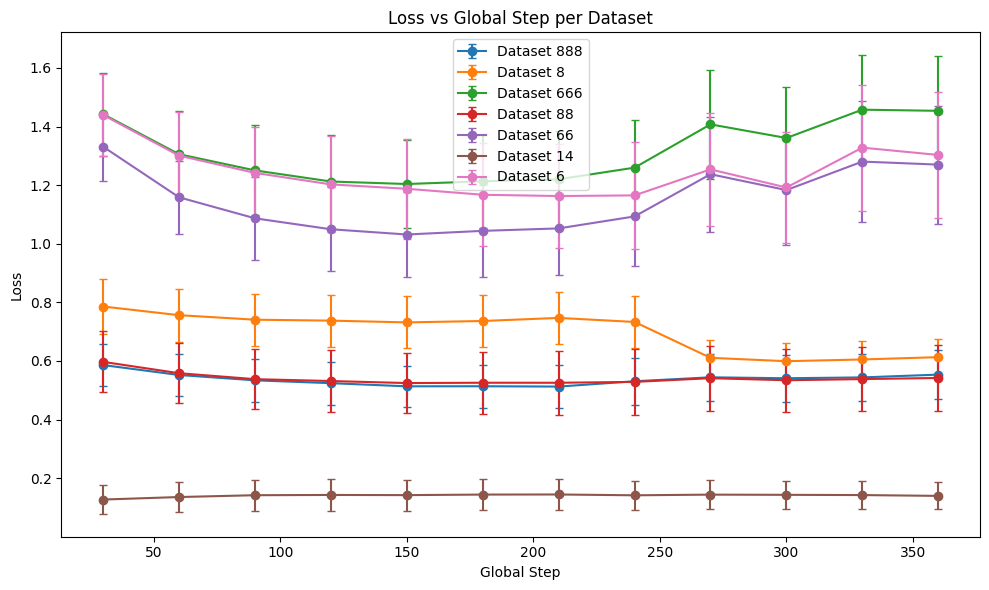

In [1]:
import json
import re
import matplotlib.pyplot as plt

def parse_per_ds_log(fname,settype='train'):
    data_series = {}
    
    with open(fname, "r") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue  # Skip empty lines
            record = json.loads(line)
            step = record.get("global_step")
            # Loop over keys and filter for loss entries.
            for key, value in record.items():
                if key.startswith(f"{settype}_dataset_") and key.endswith("_loss"):
                    # Extract the dataset id using a regex.
                    match = re.match(fr"{settype}_dataset_(\d+)_loss", key)
                    if match:
                        dataset_id = match.group(1)
                        loss = value
                        # Find the corresponding confidence interval (ci).
                        ci_key = f"{settype}_dataset_{dataset_id}_ci"
                        ci = record.get(ci_key, 0)
                        # Initialize the series if it doesn't exist.
                        if dataset_id not in data_series:
                            data_series[dataset_id] = {"steps": [], "loss": [], "ci": []}
                        data_series[dataset_id]["steps"].append(step)
                        data_series[dataset_id]["loss"].append(loss)
                        data_series[dataset_id]["ci"].append(ci)
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    for dataset_id, series in data_series.items():
        plt.errorbar(
            series["steps"],
            series["loss"],
            yerr=series["ci"],
            label=f"Dataset {dataset_id}",
            marker='o',
            capsize=3
        )
    
    plt.xlabel("Global Step")
    plt.ylabel("Loss")
    plt.title("Loss vs Global Step per Dataset")
    plt.legend()
    plt.tight_layout()
    plt.show()
    
output_dir="ft_0to31_interleaved_stdmixsafecombonara_none_mult0"
parse_per_ds_log(f"{output_dir}/per_ds_training_metrics.log",settype='eval')


In [2]:
from collections import defaultdict
def bin_num_shots(num_shots_list, num_bins=3):
    """Bin num_shots dynamically into `num_bins` equal-range bins."""
    num_shots_list = [int(x) for x in num_shots_list]
    min_val = min(num_shots_list)
    max_val = max(num_shots_list)
    bins = np.linspace(min_val, max_val, num_bins + 1)
    return bins
def aggregate_losses_with_steps(per_ds_losses, num_bins=3):
    """Bin num_shots and track loss evolution over time."""
    aggregated_results = {}

    for dataset, num_shots_dict in per_ds_losses.items():
        num_shots_values = list(num_shots_dict.keys())
        bins = bin_num_shots(num_shots_values, num_bins)

        aggregated_results[dataset] = defaultdict(list)

        for i in range(num_bins):
            lower, upper = bins[i], bins[i + 1]
            bin_label = f"{int(lower)}-{int(upper)}"

            # Collect (step, loss) pairs for this bin
            bin_losses = []
            for num_shot, step_loss_list in num_shots_dict.items():
                if lower <= int(num_shot) < upper:
                    bin_losses.extend(step_loss_list)

            # Sort by step before computing stats
            bin_losses.sort()

            # Aggregate over time
            step_to_losses = defaultdict(list)
            for step, loss in bin_losses:
                step_to_losses[step].append(loss)

            # Compute mean & confidence interval per step
            for step, loss_list in step_to_losses.items():
                mean_loss = np.mean(loss_list)
                std_error = np.std(loss_list) / np.sqrt(len(loss_list))  # 95% CI
                aggregated_results[dataset][bin_label].append((step, mean_loss, std_error))

    return aggregated_results

import matplotlib.pyplot as plt

def plot_loss_trends_over_time(aggregated_losses, prefix=""):
    """Plot loss evolution over time for each dataset & num_shot bin, in separate figures."""
    
    # Extract dataset IDs and sort them numerically
    dataset_ids = sorted(aggregated_losses.keys(), key=lambda x: int(x))  # Ensure numeric sorting

    for dataset in dataset_ids:
        plt.figure(figsize=(5, 3))  # Create a new figure for each dataset
        
        for bin_label, loss_series in aggregated_losses[dataset].items():
            steps = [point[0] for point in loss_series]  # Step numbers
            mean_losses = [point[1] for point in loss_series]  # Mean loss
            ci_intervals = [point[2] for point in loss_series]  # Confidence intervals

            plt.errorbar(
                steps,
                mean_losses,
                yerr=ci_intervals,
                fmt='o-',
                label=f"Num Shots: {bin_label}"
            )
        if dataset=='0': dataset_str="Harmful: Fake Asst"
        elif dataset=='1': dataset_str="Lmysys Good Convos: Interleaved Asst"
        elif dataset=='2': dataset_str="Lmysys Good Convos: Final Asst"
        elif dataset=='3': dataset_str="Science Convos: Interleaved Asst"
        elif dataset=='4': dataset_str="My sequence completions"
        elif dataset=='5': dataset_str="Nina's sequence completions"
        elif dataset=='6': dataset_str="Harmful: Final Asst"
        elif dataset=='66': dataset_str="Harmful: Final Asst Bad"
        elif dataset=='7': dataset_str="Harmless: Interleaved Asst"
        elif dataset=='8': dataset_str="Mean: Final Asst"
        elif dataset=='68': dataset_str="Mean: Final Asst Bad"
        elif dataset=='9': dataset_str="Mean: Fake Asst"
        elif dataset=='10': dataset_str="Nice: Interleaved Asst"
        elif dataset=='11': dataset_str="Nice: Fake Asst"
        elif dataset=='12': dataset_str="Lmysys Good Convos: Fake Asst"
        else: dataset_str = dataset
        plt.xlabel("Training Step")
        plt.ylabel("Mean Loss")
        plt.title(f"Loss Evolution for Dataset {dataset_str}")
        plt.legend()
        plt.grid()
        plt.show()
        #plt.savefig(f"{prefix}loss_trend_dataset_{dataset}.png")  # Save each plot separately
        #plt.close()
import json
import numpy as np
output_dir="ft_randalias_0to31_learn_interleaved_stdmixsafe3_orthrandembed4_mult1"
with open(f"{output_dir}/per_ds_training_metrics_detail_train.json", "r") as f:
    per_ds_losses_detail = json.load(f)

aggregated_losses = aggregate_losses_with_steps(per_ds_losses_detail, num_bins=3)
plot_loss_trends_over_time(aggregated_losses, "tworoles_")
